# 第5章: 係り受け解析
夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [1]:
! curl -o neko.txt http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  943k  100  943k    0     0  4034k      0 --:--:-- --:--:-- --:--:-- 4048k


In [2]:
! cabocha -f 1 neko.txt > neko.txt.cabocha

In [3]:
import CaboCha

cabocha = CaboCha.Parser()

In [4]:
# with open("neko.txt", mode="r") as input_file, open("neko.txt.cabocha", mode="w") as output_file:
#     for line in input_file.readlines():
#         output_file.write(cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE))

In [5]:
! head -n 10 neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 -1D 1/1 0.000000
　	記号,空白,*,*,*,*,　,　,　
吾輩は猫である	名詞,固有名詞,一般,*,*,*,吾輩は猫である,ワガハイハネコデアル,ワガハイワネコデアル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675


## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラス`Morph`を実装せよ．このクラスは表層形（`surface`），基本形（`base`），品詞（`pos`），品詞細分類1（`pos1`）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文を`Morph`オブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [6]:
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1

    def __str__(self):
        return "surface: %s\tbase: %s\tpos: %s\tpos1: %s" % (self.surface, self.base, self.pos, self.pos1)

In [7]:
def morphs_in_line(line):
    _morphs_in_line = []
    for result_line in cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE).split("\n"):
        if result_line == "EOS" or result_line == "" or result_line.startswith("*"):
            continue
        else:
            cabocha_result = result_line.split("\t")[1].split(",")
            morph = Morph(
                surface=result_line.split("\t")[0],
                base=cabocha_result[6],
                pos=cabocha_result[0],
                pos1=cabocha_result[1]
            )
            _morphs_in_line.append(morph)
    return _morphs_in_line

In [8]:
def morphs_in_texts(texts):
    _morphs = {}

    for idx, line in enumerate(texts):
        _morphs[str(idx + 1)] = morphs_in_line(line)

    return _morphs

In [9]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
morphs = morphs_in_texts(texts)

In [10]:
for morph in morphs["3"]:
    print(morph)

surface: 　	base: 　	pos: 記号	pos1: 空白
surface: 吾輩は猫である	base: 吾輩は猫である	pos: 名詞	pos1: 固有名詞
surface: 。	base: 。	pos: 記号	pos1: 句点


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラス`Chunk`を実装せよ．このクラスは形態素（`Morph`オブジェクト）のリスト（`morphs`），係り先文節インデックス番号（`dst`），係り元文節インデックス番号のリスト（`srcs`）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文を`Chunk`オブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [11]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

In [12]:
def chunks_in_line(line):
    _chunks_in_line = []
    for result_line in cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE).split("\n"):
        if result_line == "EOS" or result_line == "":
            continue

        elif result_line.startswith("*"):
            cabocha_result = result_line.split(" ")
            chunk = Chunk(
                dat=int(cabocha_result[2].replace("D", "")),
                srcs=[]
            )
            _chunks_in_line.append(chunk)

        else:
            cabocha_result = result_line.split("\t")[1].split(",")
            morph = Morph(
                surface=result_line.split("\t")[0],
                base=cabocha_result[6],
                pos=cabocha_result[0],
                pos1=cabocha_result[1]
            )
            _chunks_in_line[-1].morphs.append(morph)
    
    for idx, chunk in enumerate(_chunks_in_line):
            if chunk.dat != -1:
                _chunks_in_line[chunk.dat].srcs.append(idx)

    return _chunks_in_line

In [13]:
def chunks_in_texts(texts):
    _chunks = {}

    for idx, line in enumerate(texts):
        _chunks[str(idx + 1)] = chunks_in_line(line)
    
    return _chunks

In [14]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [15]:
for chunk in chunks["8"]:
    print(chunk)

morphs: 吾輩は	dat: 5	srcs: []
morphs: ここで	dat: 2	srcs: []
morphs: 始めて	dat: 3	srcs: [1]
morphs: 人間という	dat: 4	srcs: [2]
morphs: ものを	dat: 5	srcs: [3]
morphs: 見た。	dat: -1	srcs: [0, 4]


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [16]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

    def phrase(self):
        return "".join([_morph.surface for _morph in self.morphs if _morph.pos != "記号"])

In [17]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [18]:
for line_index in chunks:
    for chunk in chunks[line_index]:
        if chunk.dat != -1 \
        and len(chunk.phrase()) > 1 \
        and len(chunks[line_index][chunk.dat].phrase()) > 1:
            print("%s\t%s" % (chunk.phrase(), chunks[line_index][chunk.dat].phrase()))            

名前は	無い
まだ	無い
どこで	生れた
生れた	かとんと
かとんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	泣いて
じめじめ	泣いて
した所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	そうだ
あとで	聞くと
聞くと	そうだ
それは	そうだ
書生という	人間中で
人間中で	種族であった
一番	獰悪な
獰悪な	種族であった
種族であった	そうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である
しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
彼の	掌に
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
何だか	フワフワした
フワフワした	感じが
感じが	あったばかりである
掌の	上で
上で	落ちついて
少し	落ちついて
落ちついて	見たのが
書生の	顔を
顔を	見たのが
見たのが	人間という
いわゆる	人間という
人間という	ものの
ものの	見始であろう
妙な	ものだと
ものだと	思った
思った	感じが
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
装飾されべきはずの	顔が
顔が	つるつるして
つるつるして	薬缶だ
まるで	薬缶だ
その後	逢ったが
猫にも	逢ったが
だいぶ	逢ったが
逢ったが	ない
こんな	片輪には
片輪には	ない
一度も	出会わし
出会わし	ない
た事が	ない
のみならず	突起している
顔の	真中が
真中が	突起している
あまりに	突起している
そうして	吹く
その穴の	中から
中から	吹く
時々	吹く
ぷうぷうと	吹く
煙を	吹く
どうも	咽せぽくて
咽せぽくて	弱った
実に	弱った
これが	ものである
人間の	飲む
飲む	煙草という
煙草という	ものである
ものである	事は
事は	知った
ようやく	知った
この	書生の
書生の	掌の
掌の	裏で
裏で	坐って
しばらくは	よい
よい	心持に
心持に	坐って
坐って	おったが
おったが	

二時頃であったが	運ばした
吾輩は	運ばした
昼飯後快よく	一睡した
運動かたがた	茶園へと
この	茶園へと
茶園へと	運ばした
歩を	運ばした
茶の木の	根を
根を	一本一本嗅ぎながら
一本一本嗅ぎながら	くると
西側の	杉垣の
杉垣の	そばまで
そばまで	くると
くると	寝ている
枯菊を	押し倒して
押し倒して	寝ている
その上に	寝ている
大きな	猫が
猫が	寝ている
前後不覚に	寝ている
彼は	眠っている
吾輩の	近づくのも
近づくのも	心付かざるごとくまた
一向	心付かざるごとくまた
心付かざるごとくまた	無頓着なるごとく
心付くも	無頓着なるごとく
無頓着なるごとく	眠っている
大きな	鼾を
鼾を	して
して	眠っている
長々と	眠っている
体を	眠っている
横えて	眠っている
他の	庭内に
庭内に	睡られる
忍び入りたる	ものが
ものが	睡られる
かくまで	睡られる
平気に	睡られる
睡られる	ものかと
ものかと	驚かざるを得なかった
吾輩は	驚かざるを得なかった
窃かに	驚かざるを得なかった
その	度胸に
大胆なる	度胸に
度胸に	驚かざるを得なかった
彼は	黒猫である
純粋の	黒猫である
わずかに	過ぎたる
午を	過ぎたる
過ぎたる	太陽は
太陽は	思われた
透明なる	光線を
光線を	かけて
彼の	皮膚の
皮膚の	上に
上に	かけて
抛げ	かけて
かけて	きらきらする
きらきらする	柔毛の
柔毛の	間より
間より	見えぬ
眼に	見えぬ
見えぬ	炎でも
炎でも	思われた
燃え出ずるように	思われた
彼は	有している
猫中の	大王とも
大王とも	云うべき
云うべき	ほどの
ほどの	体格を
偉大なる	体格を
体格を	有している
吾輩の	倍は
倍は	ある
たしかに	ある
吾輩は	落ちた
嘆賞の	念と
念と	佇立して
好奇の	心に
心に	忘れて
前後を	忘れて
忘れて	佇立して
彼の	前に
前に	佇立して
佇立して	眺めていると
余念も	なく
なく	眺めていると
眺めていると	落ちた
静かなる	小春の
小春の	風が
風が	落ちた
杉垣の	上から
上から	出たる
出たる	梧桐の
梧桐の	枝を
枝を	誘って
軽く	誘って
誘って	落ちた
ばらばらと	二三枚の
二三枚の	葉が
葉が	落ちた
枯菊の	茂みに
茂みに	落ちた
大王は	開いた
かっと	開いた
その	真丸

受けるので	挑撥するのは
大に	挑撥するのは
滑稽的美感を	挑撥するのは
挑撥するのは	面白い
せんだって	ある
ある	学生に
学生に	忠告して
ニコラス・ニックルベーが	忠告して
ギボンに	忠告して
忠告して	大著述なる
彼の	一世の
一世の	大著述なる
大著述なる	仏国革命史を
仏国革命史を	書くのを
仏語で	書くのを
書くのを	やめにして
やめにして	出版させたと
英文で	出版させたと
出版させたと	言ったら
言ったら	滑稽であった
その	学生がまた
学生がまた	男で
馬鹿に	男で
記憶の	善い
善い	男で
男で	繰り返したのは
日本文学会の	演説会で
演説会で	話した
真面目に	話した
僕の	話した
話した	通りを
通りを	繰り返したのは
繰り返したのは	滑稽であった
ところが	おった
その	時の
時の	傍聴者は
傍聴者は	約百名ばかりであったが
約百名ばかりであったが	おった
熱心に	傾聴して
それを	傾聴して
傾聴して	おった
それから	ある
まだ	面白い
面白い	話が
話が	ある
せんだって	出たから
或る	文学者の
文学者の	いる
いる	席で
席で	出たから
ハリソンの	歴史小説セオファーノの
歴史小説セオファーノの	話しが
話しが	出たから
出たから	白眉である
僕は	白眉である
あれは	白眉である
歴史小説の	中で
中で	白眉である
ことに	評したら
女主人公が	死ぬ
死ぬ	ところは
ところは	襲うようだと
鬼気人を	襲うようだと
襲うようだと	評したら
評したら	いった
僕の	向うに
向うに	坐っている
坐っている	知らんと
知らんと	云った
云った	事の
事の	ない
ない	先生が
先生が	いった
そうそうあすこは	名文だと
実に	名文だと
名文だと	いった
それで	知った
僕は	知った
この	男も
男も	読んでおらないという
やはり	読んでおらないという
僕同様	読んでおらないという
この	小説を
小説を	読んでおらないという
読んでおらないという	事を
事を	知った
知った	主人は
神経胃弱性の	主人は
主人は	問いかけた
眼を	丸くして
丸くして	問いかけた
そんな	出鱈目を
出鱈目を	いって
いって	読んでいたら
もし	読んでいたら
相手が	読んでいたら
読んでいたら	するつもりだ
どう	するつもりだ
するつもりだ	欺くのは
あたかも	

云う	顔で
顔で	考え込んでいたが
しばらく	考え込んでいたが
考え込んでいたが	した
ようやく決心を	した
した	ものと
ものと	見えて
見えて	立つ
それじゃ	出ると
出ると	しようと
しようと	思い切って
思い切って	立つ
やはり	着た
黒木綿の	紋付羽織に
紋付羽織に	着た
兄の	紀念とかいう
紀念とかいう	来着古る
二十年	来着古る
来着古る	した結城紬の
した結城紬の	綿入を
綿入を	着た
着た	ままである
いくら	丈夫だって
結城紬が	丈夫だって
丈夫だって	たまらない
こう	着つづけでは
着つづけでは	たまらない
所々が	薄くなって
薄くなって	透かして
日に	透かして
透かして	見ると
見ると	見える
裏から	当てた
つぎを	当てた
当てた	針の
針の	目が
目が	見える
主人の	服装には
服装には	ない
師走も	正月も
正月も	ない
ふだん着も	余所ゆきも
余所ゆきも	ない
出る	ときは
ときは	出る
懐手を	して
して	出る
ぶらりと	出る
ほかに	着る
着る	物が
物が	ないからか
ないからか	着換えないのか
有っても	面倒だから
面倒だから	着換えないのか
着換えないのか	分らぬ
吾輩には	分らぬ
ただし	思われない
これだけは	思われない
失恋の	ためとも
ためとも	思われない
両人が	出て
出て	行った
行った	あとで
あとで	頂戴した
吾輩は	頂戴した
ちょっと	失敬して
失敬して	頂戴した
寒月君の	食い切った
食い切った	蒲鉾の
蒲鉾の	残りを
残りを	頂戴した
吾輩も	猫ではない
この	頃では
頃では	猫ではない
普通一般の	猫ではない
まず	あると
桃川如燕以後の	猫か
猫か	あると
グレーの	金魚を
金魚を	偸んだ
偸んだ	猫くらいの
猫くらいの	資格は
資格は	あると
充分	あると
あると	思う
車屋の	黒などは
黒などは	ない
固より	ない
眼中に	ない
蒲鉾の	一切くらい
一切くらい	頂戴したって
頂戴したって	云われる
人から	云われる
かれこれ	云われる
云われる	事も
事も	なかろう
それに	事ではない
この	人目を
人目を	忍んで
忍んで	するという
間食を	するという
するという	癖は
癖は	事ではない
何も	限った
吾等猫族に	限った
限った	事ではない
うちの	御三などは
御三などは	失敬している
よく	

名が	出来たと
出来たと	忘れて
友人の	迷惑は
迷惑は	忘れて
まるで	忘れて
忘れて	嬉しがったと
一人	嬉しがったと
嬉しがったと	いうが
いうが	話だ
小説中の	人間の
人間の	名前を
名前を	つけるに
つけるに	探険しなくてはならぬようでは
一日巴理を	探険しなくてはならぬようでは
探険しなくてはならぬようでは	話だ
随分	かかる
手数の	かかる
かかる	話だ
贅沢も	出来れば
この	くらい
くらい	出来れば
出来れば	ものだが
結構な	ものだが
ものだが	出ない
吾輩のように	持つ
牡蠣的主人を	持つ
持つ	身の上では
身の上では	出ない
とても	出ない
そんな	気は
気は	出ない
何でも	いい
いい	食えさえすればという
食えさえすればという	気に
気に	なるのも
なるのも	むるところであろう
境遇の	しからし
しからし	むるところであろう
だから	思い出したからである
今雑煮が	食いたくなったのも
食いたくなったのも	結果ではない
決して	結果ではない
贅沢の	結果ではない
結果ではない	食っておこうという
何でも	食える
食える	時に
時に	食っておこうという
食っておこうという	考から
考から	ていはすまいかと
主人の	食い剰した
食い剰した	雑煮が
雑煮が	残っ
もしや	残っ
台所に	残っ
残っ	ていはすまいかと
ていはすまいかと	思い出したからである
台所へ	廻って
廻って	見る
今朝	見た
見た	通りの
通りの	餅が
餅が	膠着している
今朝	見た
見た	通りの
通りの	色で
色で	膠着している
椀の	底に
底に	膠着している
白状するが	ない
餅という	ものは
ものは	ない
今まで	入れた
一辺も	入れた
口に	入れた
入れた	事が
事が	ない
見ると	あるしまた
うまそうにも	あるしまた
あるしまた	わるくもある
少しは	わるくもある
気味が	わるくもある
前足で	かかっている
上に	かかっている
かかっている	菜っ葉を
菜っ葉を	掻き寄せる
爪を	見ると
見ると	ねばねばする
餅の	上皮が
上皮が	引き掛って
引き掛って	ねばねばする
嗅いで	見ると
見ると	する
釜の	底の
底の	飯を
飯を	移す
御櫃へ	移す
移す	時のような
時のような	香が
香が	する
食おうかな	やめようかなと
やめようかなと	見廻す
あたりを	見廻す
幸か

黙っている	訳にも
訳にも	参りませんから
参りませんから	合せたのです
どうも	遺憾ですな
遺憾ですな	遺憾極るですなと
遺憾極るですなと	合せたのです
調子を	合せたのです
合せたのです	ごもっともでと
ごもっともでと	賛成する
主人が	賛成する
何が	ごもっともだか
ごもっともだか	わからん
吾輩には	わからん
すると	見えて
ボイも	見えて
気の毒だと	見えて
見えて	参りましたら
その内	参りましたら
材料が	参りましたら
参りましたら	願いますってんでしょう
どうか	願いますってんでしょう
先生が	使うかねと
材料は	使うかねと
何を	使うかねと
使うかねと	問われると
問われると	笑って
ボイはへへへへと	笑って
笑って	しないんです
返事を	しないんです
材料は	云いましたよ
日本派の	俳人だろうと
俳人だろうと	押し返して
先生が	押し返して
押し返して	聞くと
聞くと	えさようで
ボイはへ	えさようで
えさようで	買われませんので
それだ	ものだから
ものだから	買われませんので
近頃は	買われませんので
横浜へ	行っても
行っても	買われませんので
買われませんので	云いましたよ
まことに	お気の毒様と
お気の毒様と	云いましたよ
云いましたよ	面白いと
アハハハそれが	落ちなんですか
落ちなんですか	面白いと
こりゃ	面白いと
面白いと	笑う
主人は	笑う
いつに	なく
なく	笑う
大きな	声で
声で	笑う
膝が	揺れて
揺れて	落ちかかる
吾輩は	落ちかかる
主人は	笑う
それにも	なく
頓着	なく
なく	笑う
アンドレア・デル・サルトに	罹ったのは
罹ったのは	ものと
自分	一人でないと
一人でないと	云う
云う	事を
事を	知ったので
知ったので	なった
急に	なった
愉快に	なった
なった	ものと
ものと	見える
それから	出ると
二人で	出ると
表へ	出ると
出ると	大得意なんです
どうだ	大得意なんです
うまく	行ったろう
行ったろう	面白かろうと
橡面坊を	使った
種に	使った
使った	ところが
ところが	面白かろうと
面白かろうと	大得意なんです
敬服の	至りですと
至りですと	云って
云って	御別れしたような
御別れしたような	ものの
ものの	延びたので
実は	延びたので
午飯の	時刻が
時刻が	延びたので
延びたので	弱り

苦心此事に	御座候
独りで	苦心しているのじゃないかと
勝手に	苦心しているのじゃないかと
苦心しているのじゃないかと	表しない
主人は	表しない
毫も	表しない
感謝の	意を
意を	表しない
此孔雀の	舌の
舌の	料理は
料理は	居候次第御諒察可被下候
往昔羅馬全盛の	砌り
砌り	居候次第御諒察可被下候
一時	流行致し
非常に	流行致し
流行致し	候ものにて
候ものにて	居候次第御諒察可被下候
豪奢風流の	極度と
極度と	居候次第御諒察可被下候
平生より	動かし
ひそかに	動かし
食指を	動かし
動かし	居候次第御諒察可被下候
何が	御諒察だ
御諒察だ	冷淡である
馬鹿なと	冷淡である
主人は	冷淡である
すこぶる	冷淡である
降って	居候
十六七世紀の	頃迄は
頃迄は	居候
全欧を通じて	居候
孔雀は	居候
宴席に	欠くべからざる
欠くべからざる	好味と
好味と	相成
相成	居候
レスター伯が	招待致し
エリザベス女皇を	招待致し
ケニルウォースに	招待致し
招待致し	候様記憶致候
候節も	候様記憶致候
慥か	候様記憶致候
孔雀を	候様記憶致候
使用致し	候様記憶致候
有名なる	レンブラントが
レンブラントが	画き
画き	広げたる
候饗宴の	図にも
図にも	広げたる
孔雀が	広げたる
尾を	広げたる
広げたる	居り候
儘卓上に	居り候
横わり	居り候
孔雀の	料理史を
料理史を	かくくらいなら
かくくらいなら	こぼす
そんなに	こぼす
多忙でも	こぼす
なさそうだと	不平を
不平を	こぼす
とにかく	食べ続けにては
近頃の	如く御馳走の
如く御馳走の	食べ続けにては
食べ続けにては	必定
さすがの	小生も
小生も	必定
遠からぬ	うちに
うちに	相成るは
大兄の如く	相成るは
胃弱と	相成るは
相成るは	必定
大兄の	ごとくは余計だ
何も	しなくても
僕を	しなくても
胃弱の	標準に
標準に	しなくても
しなくても	済むと
済むと	つぶやいた
主人は	つぶやいた
歴史家の	説に
説に	よれば
よれば	候由
羅馬人は	候由
日に	開き
二度	三度も
三度も	開き
宴会を	開き
開き	候由
日に	醸すべく
二度も	三度も
三度も	醸すべく
方丈の	食饌に
食饌に	就き候えば
就き候えば	醸すべく
如何なる	健胃の
健胃の	人にても
人にても	醸すべく
消化機能に	醸

こりゃなるほど	変ってると
変ってると	吐き返す
迷亭先生は	吐き返す
図に	乗って
乗って	吐き返す
腹の	底から
底から	吐き返す
雲井を	吐き返す
鼻の	孔まで
孔まで	吐き返す
途中で	して
煙が	して
戸迷いを	して
して	引きかかる
咽喉の	出口へ
出口へ	引きかかる
先生は	返る
煙管を	握って
握って	咽び
ごほん	咽び
ごほんと	咽び
咽び	返る
先日	来た
来た	時は
時は	笑われたと
朗読会で	なって
船頭に	なって
なって	笑われたと
女学生に	笑われたと
笑われたと	いっていたよと
いっていたよと	云う
主人は	云う
笑いながら	云う
うむそれそれと	迷亭先生が
迷亭先生が	叩く
煙管で	叩く
膝頭を	叩く
吾輩は	離れる
険呑に	なったから
なったから	離れる
少し	離れる
傍を	離れる
その	朗読会さ
せんだって	御馳走した
トチメンボーを	御馳走した
御馳走した	時にね
その	話しが
話しが	出たよ
何でも	やるつもりだから
第二回には	やるつもりだから
知名の	文士を
文士を	招待して
招待して	やるつもりだから
大会を	やるつもりだから
やるつもりだから	願いたいって
先生にも	願いたいって
是非御臨席を	願いたいって
それから	聞くと
僕が	つもりかいと
今度も	やる
近松の	世話物を
世話物を	やる
やる	つもりかいと
つもりかいと	聞くと
聞くと	御宮ですといったのさ
いえ	云うから
この	次は
次は	しましたと
ずっと	撰んで
新しい	者を
者を	撰んで
撰んで	しましたと
金色夜叉に	しましたと
しましたと	云うから
云うから	御宮ですといったのさ
君にゃ	当ってるかと
何の	役が
役が	当ってるかと
当ってるかと	聞いたら
聞いたら	御宮ですといったのさ
私は	御宮ですといったのさ
東風の	御宮は
御宮は	面白かろう
僕は	思ってるよ
是非出席して	喝采しようと
喝采しようと	思ってるよ
思ってるよ	面白いでしょうと
面白いでしょうと	する
寒月君が	する
妙な	笑い方を
笑い方を	する
しかし	好い
あの男は	好い
どこまでも	誠実で
誠実で	軽薄な
軽薄な	ところが
ところが	ないから
ないから	好い
迷亭などとは	大違いだと
大違いだと	とる
主人は	とる
アンドレア・デル・サルトと	孔雀の
孔雀の	舌と
舌と	

欄干の	上に
上に	乗りましたよ
今度	呼んだら
呼んだら	飛び込もうと
飛び込もうと	決心して
決心して	見つめているとまた
流を	見つめているとまた
見つめているとまた	浮いて来る
憐れな	声が
声が	浮いて来る
糸のように	浮いて来る
ここだと	思って
思って	飛び上がっておいてそして
力を	込めて
込めて	飛び上がっておいてそして
一反	飛び上がっておいてそして
飛び上がっておいてそして	落ちてしまいました
小石か	落ちてしまいました
何ぞのように	なく
未練	なく
なく	落ちてしまいました
とうとう	飛び込んだの
飛び込んだの	かいと
かいと	ぱちつかせて
主人が	ぱちつかせて
眼を	ぱちつかせて
ぱちつかせて	問う
そこまで	行こうとは
行こうとは	思わなかったと
思わなかったと	迷亭が
迷亭が	つまむ
自分の	鼻の
鼻の	頭を
頭を	つまむ
ちょいと	つまむ
飛び込んだ	後は
後は	遠くなって
気が	遠くなって
遠くなって	夢中でした
しばらくは	夢中でした
やがて	さめて
眼が	さめて
さめて	見ると
見ると	寒くはあるが
寒くはあるが	しない
どこも	濡れた
濡れた	所も
所も	ない
何も	ない
ない	しない
水を	飲んだような
飲んだような	感じも
感じも	しない
たしかに	飛び込んだはずだが
飛び込んだはずだが	不思議だ
実に	不思議だ
こりゃ	見渡すと
変だと	気が付いて
気が付いて	見渡すと
そこいらを	見渡すと
見渡すと	驚きましたね
水の	中へ
中へ	飛び込んだつもりで
飛び込んだつもりで	いた
いた	ところが
ところが	残念でした
つい	間違って
間違って	飛び下りたので
橋の	真中へ
真中へ	飛び下りたので
飛び下りたので	残念でした
その	時は
時は	残念でした
実に	残念でした
前と	後ろの
後ろの	間違だけで
間違だけで	出る
あの	声の
声の	出る
出る	所へ
所へ	行く
行く	事が
事が	出来なかったのです
出来なかったのです	寒月は
寒月は	荷厄介にしている
にやにや	笑いながら
笑いながら	荷厄介にしている
例のごとく	荷厄介にしている
羽織の	紐を
紐を	荷厄介にしている
ハハハハこれは	面白い
僕の	経験と
経験と	似ている
善く	似ている
似ている	ところが
ところが	奇だ
やはり	なるね
ゼームス教授の	材料に

火消壺の	中へ
中へ	もぐり込んでいたら
もぐり込んでいたら	あった
下女が	いるのも
吾輩が	いるのも
いるのも	知らんで
知らんで	した
上から	した
蓋を	した
した	事が
事が	あった
その	時の
時の	苦しさは
苦しさは	考えても
考えても	しくなる
しくなる	ほどであった
白君の	説明に
説明に	よると
よると	そうだ
あの苦しみが	続くと
今少し	続くと
続くと	死ぬのである
死ぬのである	そうだ
三毛子の	身代りに
身代りに	なるのなら
なるのなら	ないが
苦情も	ないが
ないが	死にたくはない
あの	苦しみを
苦しみを	受けなくては
受けなくては	死ぬ
死ぬ	事が
事が	出来ないのなら
出来ないのなら	死にたくはない
誰の	ためでも
ためでも	死にたくはない
しかし	こしらえてもらったのだから
猫でも	こしらえてもらったのだから
坊さんの	御経を
御経を	読んでもらったり
読んでもらったり	こしらえてもらったのだから
戒名を	こしらえてもらったのだから
こしらえてもらったのだから	あるまい
心残りは	あるまい
あるまい	全く果報者でございますよ
そうでございますとも	全く果報者でございますよ
ただ	云うと
慾を	云うと
云うと	軽少だったようでございますね
あの	軽少だったようでございますね
坊さんの	御経が
御経が	軽少だったようでございますね
あまり	軽少だったようでございますね
軽少だったようでございますね	おっしゃったよ
少し	短か過ぎたようだったから
短か過ぎたようだったから	したら
大変御	早うございますねと
早うございますねと	したら
御尋ねを	したら
したら	おっしゃったよ
月桂寺さんは	おっしゃったよ
ええ	利目の
利目の	ある
ある	ところを
ところを	やっておきました
ちょいと	やっておきました
やっておきました	なに猫だから
なに猫だから	行かれますと
あのくらいで	行かれますと
充分	行かれますと
浄土へ	行かれますと
行かれますと	おっしゃったよ
おっしゃったよ	あの野良なんかは
あらまあしかし	あの野良なんかは
吾輩は	断っておくのに
名前は	ないと
ないと	断っておくのに
しばしば	断っておくのに
断っておくのに	呼ぶ
この	下女は
下女は	呼ぶ
野良野良と	吾輩を
吾輩を	呼ぶ
失敬な	奴だ
罪が	深いんですから


なるほど踊りでも	おどりそうな
おどりそうな	顔だ
奥さん	猫は
この	猫は
猫は	相好ですぜ
油断の	ならない
ならない	相好ですぜ
昔しの	草双紙に
草双紙に	ある
ある	猫又に
猫又に	似ていますよと
似ていますよと	言いながら
勝手な	事を
事を	言いながら
言いながら	話しかける
しきりに	話しかける
細君に	話しかける
細君は	出てくる
迷惑そうに	やめて
針仕事の	手を
手を	やめて
やめて	出てくる
座敷へ	出てくる
どうも	帰りましょうと
御退屈様	帰りましょうと
もう	帰りましょうと
帰りましょうと	注ぎ
茶を	注ぎ
注ぎ	出す
易えて	出す
迷亭の	前へ
前へ	出す
どこへ	行ったんですかね
行ったんですかね	行ったんでしょう
どこへ	参るにも
参るにも	断わって
断わって	行った
行った	事の
事の	無い
無い	男ですから
男ですから	分りかねますが
分りかねますが	行ったんでしょう
大方	行ったんでしょう
御医者へでも	行ったんでしょう
行ったんでしょう	災難ですな
甘木さんですか	災難ですな
甘木さんも	災難ですな
あんな	病人に
病人に	捕まっちゃ
捕まっちゃ	災難ですな
災難ですな	へえと
へえと	ないと
細君は	ないと
挨拶の	しようも
しようも	ないと
ないと	見えて
見えて	する
簡単な	答えを
答えを	する
迷亭は	頓着しない
一向	頓着しない
近頃は	どうです
どうです	能いんですか
少しは	能いんですか
胃の	加減が
加減が	能いんですか
能いんですか	思いますと
能いか	悪いか
悪いか	分りません
頓と	分りません
分りません	かかったって
いくら	かかったって
甘木さんに	かかったって
かかったって	思いますと
あんなに	ないと
ジャムばかり	ないと
甞めては	ないと
胃病の	直る
直る	訳が
訳が	ないと
ないと	思いますと
思いますと	洩らす
細君は	洩らす
先刻の	不平を
不平を	洩らす
暗に	洩らす
迷亭に	洩らす
そんなに	小供のようですね
ジャムを	小供のようですね
甞めるんですか	小供のようですね
まるで	小供のようですね
小供のようですね	甞めますので
ジャムばかりじゃないんで	甞めますので
この	頃は
頃は	甞めますので
胃病の	薬だとか
薬だとか	云って
云って	甞めますので
大根卸しを	甞めますの

待った	ところなんだ
早速	願おうなあ君と
願おうなあ君と	見る
主人を	見る
主人も	する
やむを得ず	する
うむと	する
生返事を	する
寒月君は	いそがない
コップへ	一杯頂戴しましょうと
水を	一杯頂戴しましょうと
一杯頂戴しましょうと	云う
いよー	やるのか
本式に	やるのか
やるのか	なさるだろうと
次には	なさるだろうと
拍手の	請求とおいで
請求とおいで	なさるだろうと
なさるだろうと	騒ぎ立てる
迷亭は	騒ぎ立てる
独りで	騒ぎ立てる
寒月君は	始める
内隠しから	取り出して
草稿を	取り出して
取り出して	して
徐ろに	して
稽古ですから	願いますと
御遠慮なく御批評を	願いますと
願いますと	して
前置を	して
して	始める
いよいよ	始める
演舌の	御浚いを
御浚いを	始める
罪の	刑に
刑に	処すると
処すると	云う
云う	事は
事は	方法でありまして
重に	行われた
アングロサクソン民族間に	行われた
行われた	方法でありまして
方法でありまして	者であります
それより	溯って
古代に	溯って
溯って	考えますと
考えますと	者であります
首縊りは	者であります
重に	行われた
自殺の方法として	行われた
行われた	者であります
猶太人中に	在っては
在っては	習慣であったそうでございます
罪人を	抛げつけて
石を	抛げつけて
抛げつけて	殺す
殺す	習慣であったそうでございます
旧約全書を	研究して
研究して	見ますと
見ますと	認められます
いわゆる	ハンギングなる
ハンギングなる	語は
語は	認められます
罪人の	死体を
死体を	釣るして
釣るして	する
野獣または	肉食鳥の
肉食鳥の	餌食と
餌食と	する
する	意義と
意義と	認められます
ヘロドタスの	説に従って
説に従って	見ますと
見ますと	思われます
太人は	思われます
エジプトを	去る
去る	以前から
以前から	曝される
夜中死骸を	曝される
曝される	ことを
ことを	忌み嫌ったように
痛く	忌み嫌ったように
忌み嫌ったように	思われます
エジプト人は	したそうで御座います
罪人の	首を
首を	斬って
斬って	して
胴だけを	して
十字架に	して
釘付けに	して
して	したそうで御座います
夜中	したそうで御座います
曝し物に	したそうで御座います
波斯人は	入れる
寒

どこの	会へ
会へ	出ても
出ても	やで
どんな	身分の
身分の	高い人の
高い人の	前でも
前でも	通して行かれる
立派に	通して行かれる
金田夫人で	通して行かれる
通して行かれる	やで
いわんや	やで
こんな	老書生においてを
燻り返った	老書生においてを
老書生においてを	やで
やで	予期していたのである
私の	家は
家は	予期していたのである
向う	横丁の
横丁の	角屋敷ですとさえ
角屋敷ですとさえ	云えば
云えば	驚くだろうと
職業などは	驚くだろうと
聞かぬ	先から
先から	驚くだろうと
驚くだろうと	予期していたのである
金田って	知ってるかと
人を	知ってるかと
知ってるかと	聞く
主人は	聞く
無雑作に	聞く
迷亭に	聞く
知ってるとも	友達だ
金田さんは	友達だ
僕の	伯父の
伯父の	友達だ
この間	なったと
なん	ざ園遊会へ
ざ園遊会へ	なったと
おいでに	なったと
なったと	する
迷亭は	する
真面目な	返事を
返事を	する
へえ	えな誰だい
君の	伯父さんて
伯父さんて	えな誰だい
えな誰だい	牧山男爵さと
牧山男爵さと	迷亭は
迷亭は	真面目である
いよいよ	真面目である
主人が	先に
何か	云おうとして
云おうとして	云わぬ
云わぬ	先に
先に	見る
鼻子は	見る
急に	向き直って
向き直って	見る
迷亭の	方を
方を	見る
迷亭は	すましている
大島紬に	重ねて
古渡更紗か	何か
何か	重ねて
重ねて	すましている
おや	存じませんで
あなたが	いらっしゃいますか
牧山様の	いらっしゃいますか
何で	いらっしゃいますか
いらっしゃいますか	存じませんで
ちっとも	存じませんで
存じませんで	致しました
はなはだ	致しました
失礼を	致しました
牧山様には	致しておりますと
始終	なると
御世話に	なると
なると	致しておりますと
宿で	致しておりますと
毎々	致しておりますと
御噂を	致しておりますと
致しておりますと	して
急に	叮嚀な
叮嚀な	言葉使を
言葉使を	して
して	する
おまけに	する
御辞儀まで	する
する	笑っている
迷亭は	笑っている
へええ	ハハハハと
ハハハハと	笑っている
主人は	見ている
あっ気に	取られて
取られて	見ている
無言で	見ている
二人を	見ている
たしか	つきましても
娘の	縁辺の
縁辺の

活版で	帆懸
帆懸	舟が
舟が	印刷してあって
印刷してあって	書き散らしてある
例の	ごとく
ごとく	書き散らしてある
その	下に
下に	書き散らしてある
何か	書き散らしてある
よべの	泊りの
泊りの	十六小女郎
十六小女郎	親が
親が	ないとて
ないとて	泣いた
荒磯の	千鳥
千鳥	さよの寝覚の
さよの寝覚の	千鳥に
千鳥に	泣いた
うまいの	ねえ
ねえ	話せるじゃありませんか
話せるじゃありませんか	話せますかな
話せますかな	乗りますよ
ええ	乗りますよ
これなら	乗りますよ
三味線に	乗りますよ
乗りますよ	本物だ
三味線に	乗りゃ
乗りゃ	本物だ
こりゃ	如何ですと
如何ですと	迷亭は
迷亭は	無暗に出す
いえ	これだけ拝見すれば
もう	これだけ拝見すれば
これだけ拝見すれば	分りましたからと
ほかのは	沢山で
沢山で	分りましたからと
そんなに	野暮でないんだと
野暮でないんだと	云う
云う	事は
事は	分りましたからと
分りましたからと	合点している
一人で	合点している
鼻子は	致しました
これで	えた
寒月に関する	大抵の
大抵の	質問を
質問を	えた
えた	ものと
ものと	見えて
見えて	致しました
これは	致しました
はなはだ	致しました
失礼を	致しました
どうか	参った
私の	参った
参った	事は
事は	願いますと
寒月さんへは	願いますと
内々に	願いますと
願いますと	する
得手勝手な	要求を
要求を	する
寒月の	事は
事は	聞かなければならないが
何でも	聞かなければならないが
聞かなければならないが	見える
自分の	方の
方の	事は
事は	知らしてはならないと
一切	知らしてはならないと
寒月へ	知らしてはならないと
知らしてはならないと	云う
云う	方針と
方針と	見える
迷亭も	主人も
主人も	すると
はあと	ない
気の	ない
ない	返事を
返事を	すると
すると	立つ
いずれ	致しますからと
御礼は	致しますからと
致しますからと	入れて
念を	入れて
入れて	言いながら
言いながら	立つ
見送りに	出た
出た	両人が
両人が	云うと
席へ	云うと
返るや	否や迷亭が
否や迷亭が	云うと
ありゃ	何だいと
何だいと	云うと
云うと	かける
主人も	かける
ありゃ	何だいと
何だいと	かける
双方から	かける
同じ	問を


ものを	だまって
なぜ	だまって
だまって	貰っ
貰っ	たんだい
たんだい	へえ
へえ	ないだろうじゃないか
御前にさえ	似合うなら
そのくらい	似合うなら
似合うなら	ないだろうじゃないか
妾しにだって	ないだろうじゃないか
おかしい	事あ
事あ	ないだろうじゃないか
ないだろうじゃないか	遊ばします
きっとよく	遊ばします
御似合い	遊ばします
遊ばします	黙っているんだい
似あうのが	分ってる
分ってる	癖に
癖に	黙っているんだい
なぜ	黙っているんだい
そうして	すまして
すまして	掛けているんだよ
掛けているんだよ	悪い剣突は
人の	悪い剣突は
悪い剣突は	連発される
留めども	なく
なく	連発される
この	さき
さき	事局は
事局は	発展するかと
どう	発展するかと
発展するかと	謹聴している
向うの	座敷で
座敷で	呼ぶ
富子や	富子やと
富子やと	呼ぶ
大きな	声で
声で	呼ぶ
金田君が	呼ぶ
令嬢を	呼ぶ
令嬢は	出て行く
やむを得ず	出て行く
はいと	出て行く
電話室を	出て行く
吾輩より	引き集めたような
少し	引き集めたような
大きな	狆が
狆が	引き集めたような
顔の	中心に
中心に	引き集めたような
眼と	口を
口を	引き集めたような
引き集めたような	面を
面を	して
して	付いて行く
吾輩は	帰る
例の	忍び足で
忍び足で	急いで
再び	急いで
勝手から	急いで
往来へ	出て
出て	急いで
急いで	帰る
主人の	家に
家に	帰る
探険は	成績である
まず	成績である
十二分の	成績である
帰って	見ると
見ると	移ったので
奇麗な	家から
家から	移ったので
ない所へ	移ったので
移ったので	する
何だか	入り込んだような
日当りの	善い山の上から
善い山の上から	入り込んだような
薄黒い	洞窟の
洞窟の	中へ
中へ	入り込んだような
入り込んだような	心持ちが
心持ちが	する
探険中は	恋しくなる
ほかの	事に
事に	奪われて
気を	奪われて
奪われて	装飾
部屋の	装飾
装飾	具合などには
障子の	具合などには
具合などには	留らなかったが
眼も	留らなかったが
留らなかったが	恋しくなる
わが	住居の
住居の	下等なるを
下等なるを	感ずると同時に
感ずると同時に	恋しくなる
彼の	月並が
いわゆる	月並が
月並が	恋しくなる

ある	聞き苦しい
何だか	間男のようで
泥棒か	間男のようで
間男のようで	聞き苦しい
吾輩が	行くのは
金田邸へ	行くのは
行くのは	受けないが
招待こそ	受けないが
受けないが	ためではない
決して	ちょろまかしたり
鰹の	切身を
切身を	ちょろまかしたり
ちょろまかしたり	密着している
眼鼻が	密着している
顔の	中心に
中心に	密着している
痙攣的に	密着している
密着している	狆君などと
狆君などと	密談する
密談する	ためではない
もってのほかの	事である
およそ	世の中に
世の中に	賤しい
何が	賤しい
賤しい	家業だと
家業だと	云って
云って	ないと
探偵と	高利貸ほど
高利貸ほど	ないと
下等な	職は
職は	ないと
ないと	思っている
なるほど寒月君の	ために
ために	起して
猫に	あるまじき
あるまじき	ほどの
ほどの	義侠心を
義侠心を	起して
起して	窺った
一度は	窺った
金田家の	動静を
動静を	窺った
余所ながら	窺った
窺った	事は
事は	あるが
あるが	ない
それは	一遍で
ただの	一遍で
一遍で	ない
その後は	致した
決して	致した
猫の	良心に
良心に	恥ずるような
恥ずるような	振舞を
陋劣な	振舞を
振舞を	致した
致した	事は
事は	ない
そんなら	使用した
なぜ	忍び込むと
忍び込むと	云うような
云うような	文字を
胡乱な	文字を
文字を	使用した
さあ	事だて
それが	事だて
すこぶる	ある
意味の	ある
ある	事だて
元来	よると
吾輩の	考に
考に	よると
よると	行くまい
大空は	行くまい
万物を	覆う
覆う	ため
ため	出来ている
大地は	出来ている
万物を	載せる
載せる	ために
ために	出来ている
出来ている	行くまい
いかに	執拗な
執拗な	議論を
議論を	好む
好む	人間でも
人間でも	否定する
この	事実を
事実を	否定する
否定する	訳には
訳には	行くまい
さて	しておらぬではないか
この	大空大地を
大空大地を	製造する
製造する	ために
ために	費やしているかと
彼等人類は	費やしているかと
どの	くらいの
くらいの	労力を
労力を	費やしているかと
費やしているかと	云うと
云うと	しておらぬではないか
尺寸の	手伝も
手伝も	しておらぬではないか
自分が	製造しておらぬ
製造しておら

事だから	行かんが
必ず	やると
水島に	やると
やると	極める
極める	訳にも
訳にも	行かんが
行かんが	悪くもないようだから
だんだん	聞いて
聞いて	見ると
見ると	悪くもないようだから
学問も	人物も
人物も	悪くもないようだから
悪くもないようだから	構わん
もし	勉強して
当人が	勉強して
勉強して	近い
近い	内に
内に	なったらあるいは
博士にでも	なったらあるいは
なったらあるいは	もらう
もらう	事が
事が	出来るかも
出来るかも	知れんくらいは
知れんくらいは	構わん
それとなく	ほのめかしても
ほのめかしても	構わん
そう	云って
云って	やったら
やったら	事でしょう
当人も	なって
励みに	なって
なって	勉強する
勉強する	事でしょう
それから	事だが
あの	事だが
妙な	事だが
事だが	事だと
水島にも	似合わん
似合わん	事だと
事だと	思うが
思うが	困る
あの	変物の
変物の	苦沙弥を
苦沙弥を	云って
先生先生と	云って
云って	云う
苦沙弥の	云う
云う	事は
事は	様子だから
大抵	聞く
聞く	様子だから
様子だから	困る
なにそりゃ	限る
何も	限る
水島に	限る
限る	訳では
訳では	ないのだから
無論	ないのだから
ないのだから	せんが
苦沙弥が	云って
何と	云って
云って	せんが
邪魔を	しようと
しようと	せんが
わしの	方は
方は	せんが
別に	せんが
差支えも	せんが
水島さんが	可哀そうですからねと
可哀そうですからねと	出す
鼻子夫人が	出す
口を	出す
水島と	云う
云う	人には
人には	ございませんが
逢った	事も
事も	ございませんが
ございませんが	ないのでしょう
とにかく	出来れば
こちらと	御縁組が
御縁組が	出来れば
出来れば	幸福で
生涯の	幸福で
幸福で	ないのでしょう
本人は	ないのでしょう
無論	ないのでしょう
異存は	ないのでしょう
ええ	貰いたがっているんですが
水島さんは	貰いたがっているんですが
貰いたがっているんですが	ものですから
苦沙弥だの	迷亭だのって
迷亭だのって	ものですから
変り者が	かんだとか
何だとか	かんだとか
かんだとか	云う
云う	ものですから
そりゃ	事で
善くない	事で
事で	所作ですな
相当の	教育の
教育の	ある
ある	ものにも
ものにも	

気の毒そうにでも	している
している	事か
事か	ぱちつかせて
乗る	権利も
権利も	ない
ない	布団の
布団の	上に
上に	構えて
傲然と	構えて
構えて	ぱちつかせて
丸い	眼を
無愛嬌な	眼を
眼を	ぱちつかせて
ぱちつかせて	見つめている
御前は	見つめている
誰だいと	云わぬばかりに
云わぬばかりに	見つめている
鈴木君の	顔を
顔を	見つめている
これが	条件である
平均を	破壊する
破壊する	第三の
第三の	条件である
これほど	あるなら
不平が	あるなら
あるなら	ものだが
吾輩の	頸根っこを
頸根っこを	捉えて
捉えて	引きずり卸したら
引きずり卸したら	ものだが
宜さそうな	ものだが
ものだが	見ている
鈴木君は	見ている
だまって	見ている
堂々たる	人間が
人間が	恐れて
猫に	恐れて
恐れて	せぬと
手出しを	せぬと
せぬと	云う
云う	事は
事は	ないのに
有ろうはずが	ないのに
ないのに	云うと
なぜ	処分して
早く	処分して
吾輩を	処分して
処分して	洩らさないかと
自分の	不平を
不平を	洩らさないかと
洩らさないかと	云うと
云うと	察せらるる
これは	察せらるる
全く	維持する
鈴木君が	維持する
一個の	人間として
人間として	維持する
自己の	体面を
体面を	維持する
維持する	自重心の
自重心の	故であると
故であると	察せらるる
もし	訴えたなら
腕力に	訴えたなら
訴えたなら	上下し得るであろうが
三尺の	童子も
童子も	上下し得るであろうが
吾輩を	上下し得るであろうが
自由に	上下し得るであろうが
上下し得るであろうが	出来ぬのである
体面を	重んずる
重んずる	点より
点より	考えると
考えると	出来ぬのである
いかに	股肱たる
金田君の	股肱たる
股肱たる	鈴木藤十郎
鈴木藤十郎	人も
その	人も
人も	出来ぬのである
この	二尺四方の
二尺四方の	真中に
真中に	鎮座まします
鎮座まします	猫大明神を
猫大明神を	する
如何とも	する
する	事が
事が	出来ぬのである
いかに	見ていぬ
人の	見ていぬ
見ていぬ	場所でも
場所でも	したと
猫と	座席争いを
座席争いを	したと
したと	あっては
あっては	威厳に関する
いささか	威厳に関する
人間の	威厳に関する
真面目に	して
猫を	して
相手に	して
し

今日は	ものだ
諸君から	ひやかされに
ひやかされに	来たような
来たような	ものだ
なんぼ	田舎者だって
田舎者だって	持ってるよ
これでも	持ってるよ
街鉄を	持ってるよ
六十株	持ってるよ
そりゃ	出来ないな
馬鹿に	出来ないな
僕は	持っていたが
八百八十八株半	持っていたが
持っていたが	ない
惜しい	事に
事に	喰ってしまって
大方虫が	喰ってしまって
喰ってしまって	ない
今じゃ	ない
半株ばかりしか	ない
もう少し	早く
早く	出てくれば
君が	出てくれば
東京へ	出てくれば
出てくれば	した
虫の	喰わない
喰わない	ところを
ところを	やる
十株ばかり	やる
やる	ところだったが
ところだったが	した
惜しい	事を
事を	した
相変らず	悪るい
口が	悪るい
しかし	高くなるばかりだから
冗談は	高くなるばかりだから
冗談として	高くなるばかりだから
ああ	云う
云う	株は
株は	持ってて
持ってて	ないよ
損は	ないよ
ないよ	高くなるばかりだから
年々	高くなるばかりだから
そうだ仮令	持ってる
半株だって	持ってる
千年も	持ってる
持ってる	うち
うち	建つからな
にゃ倉が	建つからな
三つくらい	建つからな
君も	才子だが
僕も	才子だが
その辺に	ない
ぬかりは	ない
ない	当世の
当世の	才子だが
才子だが	ものだ
そこへ	行くと
行くと	ものだ
苦沙弥などは	ものだ
憐れな	ものだ
株と	云えば
云えば	考えているんだからと
大根の	兄弟分くらいに
兄弟分くらいに	考えているんだからと
考えているんだからと	出る
また	出る
羊羹を	つまんで
つまんで	見ると
主人の	方を
方を	見ると
見ると	出る
主人も	伝染して
迷亭の	食い気が
食い気が	伝染して
伝染して	出る
自ずから	出る
菓子皿の	方へ
方へ	出る
手が	出る
世の中では	有している
万事積極的の	ものが
ものが	有している
人から	有している
真似ら	有している
るる	有している
権利を	有している
株などは	構わんが
どうでも	構わんが
構わんが	乗らしてやりたかったと
僕は	いいから
曾呂崎に	一度で
一度で	いいから
いいから	乗らしてやりたかったと
電車へ	乗らしてやりたかったと
乗らしてやりたかったと	眺める
主人は	眺める
喰い欠けた	羊羹の
羊羹の

ねえ	苦沙弥君
苦沙弥君	君大に
君大に	奮闘したじゃないか
それでも	そうだ
君より	そうだ
僕の	方が
方が	そうだ
評判が	いい
いい	そうだ
アハハハなかなか	強い
自信が	強い
強い	男だ
それでなくては	出ちゃいられん訳だ
サヴェジ・チーなんて	からかわれて
生徒や	教師に
教師に	からかわれて
からかわれて	出ちゃいられん訳だ
すまして	出ちゃいられん訳だ
学校へ	出ちゃいられん訳だ
僕も	劣らんつもりだが
意志は	劣らんつもりだが
決して	劣らんつもりだが
人に	劣らんつもりだが
劣らんつもりだが	至りだ
そんなに	図太くは
図太くは	出来ん
出来ん	至りだ
敬服の	至りだ
生徒や	教師が
教師が	言ったって
少々	言ったって
愚図愚図	言ったって
言ったって	ある
何が	恐ろしい
恐ろしい	ものか
ものか	ある
サントブーヴは	ある
古今独歩の	評論家であるが
評論家であるが	した
巴里大学で	した
講義を	した
した	時は
時は	不評判で
非常に	不評判で
不評判で	ある
彼は	ある
学生の	攻撃に
攻撃に	応ずる
応ずる	ため
ため	なした
必ず	持って
匕首を	持って
袖の下に	持って
持って	なした
防禦の	具と
具と	なした
なした	事が
事が	ある
ブルヌチェルが	攻撃した
やはり	攻撃した
巴里の	大学で
大学で	攻撃した
ゾラの	小説を
小説を	攻撃した
攻撃した	時は
だって	何でもないじゃないか
ゃ大学の	教師でも
教師でも	何でもないじゃないか
高が	引くのは
リードルの	先生で
先生で	引くのは
そんな	大家を
大家を	引くのは
例に	引くのは
引くのは	もんだ
雑魚が	喩えるような
鯨を	もって
もって	喩えるような
自ら	喩えるような
喩えるような	もんだ
もんだ	事を
そんな	事を
事を	云うと
云うと	からかわれるぜ
なお	からかわれるぜ
サントブーヴだって	くらいな学者だ
俺だって	くらいな学者だ
同じ	くらいな学者だ
大変な	見識だな
しかし	いいよ
懐剣を	もって
もって	行くだけは
行くだけは	あぶないから
あぶないから	真似ない
真似ない	方が
方が	いいよ
大学の	教師が
教師が	懐剣なら
懐剣なら	ところだな
リードルの	教師は
教師は	ところだな
まあ	小刀くらいな
小刀くらいな	ところだな
しかし	

恐れ入っているようである	恐れ入り方である
なるほど	恐れ入り方である
人間の	観察点から
観察点から	云えば
云えば	恐れ入り方である
もっともな	恐れ入り方である
しかし	出来る
猫の	立場から
立場から	云うと
云うと	証明しているとも
同一の	事実が
事実が	証明しているとも
かえって	証明しているとも
神の	無能力を
無能力を	証明しているとも
証明しているとも	出来る
解釈が	出来る
もし	無能でなくとも
全然	無能でなくとも
無能でなくとも	出来るだろうと
人間以上の	能力は
能力は	出来るだろうと
決して	ない
ない	者であると
者であると	出来るだろうと
断定が	出来るだろうと
出来るだろうと	思う
神が	製造したと
人間の	数だけ
数だけ	製造したと
それだけ	製造したと
多くの	顔を
顔を	製造したと
製造したと	云うが
云うが	分らんではないか
当初から	あってか
胸中に	あってか
成算が	あってか
あってか	ほどの
ほどの	変化を
変化を	示した
示した	ものかまたは
ものかまたは	造ろうと
猫も杓子も	同じ
同じ	顔に
顔に	造ろうと
造ろうと	思ってやり
思ってやり	見たが
かけて	見たが
見たが	分らんではないか
とうてい	行かなくて
旨く	行かなくて
行かなくて	出来るのも
出来るのも	出来るのも
出来るのも	作り損ねて
作り損ねて	陥った
この	状態に
乱雑な	状態に
状態に	陥った
陥った	ものか
ものか	分らんではないか
彼等	顔面の
顔面の	構造は
構造は	るるではないか
神の	成功の
成功の	紀念と
紀念と	見ら
見ら	るるではないか
るると同時に	るるではないか
失敗の	痕迹とも
痕迹とも	判ぜら
判ぜら	るるではないか
全能とも	云えようが
云えようが	ない
無能と	評したって
評したって	差し支えは
差し支えは	ない
彼等	人間の
人間の	眼は
眼は	並んでいるので
平面の	上に
上に	並んでいるので
二つ	並んでいるので
並んでいるので	出来んから
左右を	見る
一時に	見る
見る	事が
事が	出来んから
出来んから	這入らんのは
事物の	半面だけしか
半面だけしか	這入らんのは
視線内に	這入らんのは
這入らんのは	次第である
気の毒な	次第である
立場を	換えて
換えて	見れば
見れば	起りつつあるのだが
この

縮緬の	腹合せの
腹合せの	帯です
黒繻子と	縮緬の
縮緬の	腹合せの
腹合せの	帯一筋
帯一筋	いくらくらいだ
価は	いくらくらいだ
生意気に	しめてるな
高い帯を	しめてるな
今度から	にしておけ
一円	五十銭くらいの
五十銭くらいの	にしておけ
そんな	帯が
帯が	ある
ある	ものですか
それだから	云うんです
あなたは	云うんです
不人情だと	云うんです
女房なんどは	構わないんでしょう
どんな	風を
汚ない	風を
風を	していても
していても	構わないんでしょう
けりゃ	構わないんでしょう
まあ	いいや
いいや	何だ
それから	何だ
糸織の	羽織です
羽織です	もらったんで
あれは	もらったんで
河野の	叔母さんの
叔母さんの	形身に
形身に	もらったんで
もらったんで	違います
同じ	糸織でも
糸織でも	違います
今の	糸織とは
糸織とは	違います
たちが	違います
そんな	講釈は
講釈は	いい
聞かんでも	いい
値段は	いくらだ
十五円の	羽織を
羽織を	着るなんて
着るなんて	身分不相当だ
いいじゃありませんか	買っていただき
あなたに	買っていただき
買っていただき	ゃあしまいし
その	次は
次は	何だ
黒足袋が	一足
あなたんで	さあね
代価が	二十七銭
山の芋が	一箱
山の芋まで	持って
持って	行ったのか
煮て	食うつもりか
食うつもりか	とろろ汁にする
とろろ汁にする	つもりか
どう	する
する	つもりか
つもりか	知りません
泥棒の	ところへ
ところへ	行って
行って	聞いていらっしゃい
山の芋の	ねだんまでは
ねだんまでは	知りません
そんなら	しておこう
十二円五十銭くらいに	しておこう
馬鹿馬鹿しいじゃありませんか	たまるもんですか
いくら	掘って来たって
唐津から	掘って来たって
掘って来たって	たまるもんですか
山の芋が	十二円五十銭して
十二円五十銭して	たまるもんですか
しかし	ないか
御前は	知らんと
知らんと	云うじゃ
云うじゃ	ないか
知りませんわ	知りませんが
知りませんが	法外です
十二円五十銭なんて	法外です
法外です	もの
知らんけれども	何だ
十二円五十銭は	何だ
法外だとは	何だ
まるで	合わん
論理に	合わん
それだから	云うんだ
貴様は	オタンチン・パレオロガスだと
オタンチン・パレオロガスだと	云うん

ところの	書生を
書生を	していたのか
していたのか	尋ねるからと
小石川の	寺で
寺で	して
いっしょに	して
自炊を	して
して	おった
おった	事が
事が	ある
ある	云うてくれ
今度	行ったら
行ったら	云うてくれ
宜しく	云うてくれ
云うてくれ	尋ねるからと
僕も	尋ねるからと
尋ねるからと	云っていました
近頃東京へ	来たそうだな
ええ今まで	おりましたが
九州の	炭坑に
炭坑に	おりましたが
おりましたが	なりました
こないだ	なりました
東京詰に	なりました
なかなか	旨いです
私なぞにでも	話します
朋友のように	話します
先生あの男が	貰ってると
いくら	貰ってると
貰ってると	思いなさる
月給が	つきますから
二百五十円で	つきますから
盆暮に	つきますから
配当が	つきますから
つきますから	ばい
何でも	なります
平均	四五百円に
四五百円に	なります
なります	ばい
あげな男が	おるのに
かしこ取って	おるのに
おるのに	馬鹿気ておりますなあ
先生は	馬鹿気ておりますなあ
リーダー専門で	馬鹿気ておりますなあ
十年	一狐裘じゃ
一狐裘じゃ	馬鹿気ておりますなあ
実際	馬鹿気ているなと
馬鹿気ているなと	主人のような
主人のような	超然主義の
超然主義の	人でも
人でも	ない
金銭の	観念は
観念は	ない
普通の	人間と
人間と	異なる
異なる	ところは
ところは	ない
困窮するだけに	欲しいのかも知れない
人一倍	欲しいのかも知れない
金が	欲しいのかも知れない
多々良君は	ものだから
充分	吹聴して
実業家の	利益を
利益を	吹聴して
吹聴して	云う
もう	云う
云う	事が
事が	無くなった
無くなった	ものだから
奥さん	先生の
先生の	ところへ
ところへ	云う
水島寒月と	云う
云う	人が
人が	来ますか
ええ	いらっしゃいます
善く	いらっしゃいます
どげんな	人物ですか
大変学問の	出来る方だそうです
ホホホホ多々良さんくらいな	ものでしょう
そうですか	ものですかと
私くらいな	ものですかと
ものですかと	真面目である
多々良君	真面目である
どうして	知っているのかいと
寒月の	名を
名を	知っているのかいと
知っているのかいと	聞く
主人が	聞く
せんだって	頼まれました
或る	人から
人から	頼まれました
そんな	事を


穴の	横へ
横へ	すくんで
すくんで	待っている
なかなか	出て来る
出て来る	景色は
景色は	ない
皿の	音は
音は	やんだが
やがて	やんだが
やんだが	掛ったらしい
今度は	掛ったらしい
どんぶりか	何かに
何かに	掛ったらしい
掛ったらしい	する
重い	音が
音が	する
時々	する
ごとごとと	する
しかも	おらん
戸を	隔てて
隔てて	やっている
すぐ	やっている
向う側で	やっている
やっている	鼻づらと
吾輩の	鼻づらと
鼻づらと	したら
距離に	したら
したら	おらん
三寸も	離れて
離れて	おらん
時々は	ない
ちょろちょろと	近寄るがまた
穴の	口まで
口まで	近寄るがまた
足音が	近寄るがまた
近寄るがまた	ない
遠のいて	出す
一匹も	出す
顔を	出す
出す	ものは
ものは	ない
一枚向うに	逞しくしているのに
現在	逞しくしているのに
敵が	逞しくしているのに
暴行を	逞しくしているのに
逞しくしているのに	長い話だ
吾輩は	長い話だ
じっと	待っておらねばならん
穴の	出口で
出口で	待っておらねばならん
待っておらねばならん	随分気の
随分気の	長い話だ
鼠は	うしている
旅順椀の	中で
中で	うしている
盛に	うしている
舞踏会を	うしている
せめて	開けておけば
吾輩の	這入れるだけ
這入れるだけ	開けておけば
御三が	開けておけば
この	戸を
戸を	開けておけば
開けておけば	善いのに
善いのに	山出しだ
気の	利かぬ
利かぬ	山出しだ
今度は	鳴る
へっついの	影で
影で	鳴る
吾輩の	鮑貝が
鮑貝が	鳴る
ことりと	鳴る
敵は	来たなと
この	方面へも
方面へも	来たなと
来たなと	近寄ると
そーっと	近寄ると
忍び足で	近寄ると
近寄ると	隠れてしまった
手桶の	間から
間から	たぎり
尻尾が	たぎり
ちらと	たぎり
見え	たぎり
たぎり	隠れてしまった
流しの	下へ
下へ	隠れてしまった
しばらく	すると
すると	当る
風呂場で	当る
うがい茶碗が	当る
金盥に	当る
かちりと	当る
今度は	馳け込む
後方だと	振りむく
振りむく	途端に
途端に	馳け込む
五寸近く	ある
ある	奴が
大な	奴が
奴が	落して
ひらりと	落して
歯磨の	袋を
袋を	落して
落して	馳け込む
椽の	下へ
下へ	馳け込む
逃がす	ものかと
もの

頭へ	かいたまま
汗を	かいたまま
かいたまま	する
御辞儀を	する
いえ	来たばかりなんですよ
今風呂場で	貰ってね
御三に	貰ってね
水を	貰ってね
掛けて	貰ってね
ようやく	生き帰った
生き帰った	ところで
ところで	暑いじゃありませんか
どうも	暑いじゃありませんか
暑いじゃありませんか	暑うございます
この	両三日は
両三日は	暑うございます
ただ	じっとしておりましても
じっとしておりましても	出る
汗が	出る
出る	くらいで
くらいで	暑うございます
大変御	暑うございます
でも	ございませんでと
御変りも	ございませんでと
ございませんでと	とらない
細君は	とらない
依然として	とらない
鼻の	汗を
汗を	とらない
なに	暑いくらいで
暑いくらいで	変り
そんなに	変り
変り	ゃしませんや
しかし	別物ですよ
この	暑さは
暑さは	別物ですよ
どうも	だるくってね
体が	だるくってね
だるくってね	やりますかね
私しなども	ないんでございますが
ついに	致した
昼寝などを	致した
致した	事が
事が	ないんでございますが
ないんでございますが	やりますかね
こう	暑いと
暑いと	やりますかね
寝られて	寝られりゃ
寝られりゃ	さあと
こんな	事は
結構な	事は
事は	ないで
ないで	さあと
さあと	見たが
あいかわらず	呑気な
呑気な	事を
事を	並べて
並べて	見たが
見たが	質でね
それだけでは	質でね
不足と	見えて
見えて	質でね
私なん	寝たくない
寝たくない	質でね
沙弥君などのように	来る
来る	たんびに
たんびに	寝ている
寝ている	人を
人を	見ると
見ると	羨しいですよ
もっとも	答えるからね
胃弱に	答えるからね
この	暑さは
暑さは	答えるからね
丈夫な	人でも
人でも	載せてるのが
今日なんかは	載せてるのが
首を	載せてるのが
肩の	上に
上に	載せてるのが
載せてるのが	さあ
儀で	さあ
さればと	云って
云って	載ってる
載ってる	以上は
以上は	行かずねと
もぎとる	訳にも
訳にも	行かずねと
行かずねと	窮している
迷亭君	いつに
いつに	なく
なく	窮している
首の	処置に
処置に	窮している
奥さんなんざ首の	上へ
上へ	載っけておく
まだ	載っけておく
載っけておく	ものが
ものが	あるんだから
あるんだ

被って	して
両足を	して
埃だらけに	して
して	やってくる
いや	御入来だが
好男子の	御入来だが
御入来だが	失敬しますよと
喰い掛けた	ものだから
ものだから	失敬しますよと
ちょっと	失敬しますよと
失敬しますよと	平げる
迷亭君は	平げる
衆人環座の	裏に
裏に	あって
あって	残った
臆面も	なく
なく	残った
残った	蒸籠を
蒸籠を	平げる
今度は	結構だった
先刻のように	目覚しい
目覚しい	食方も
食方も	しなかった
しなかった	代りに
代りに	使って
ハンケチを	使って
使って	入れると
中途で	入れると
息を	入れると
入れると	云う
云う	不体裁も
不体裁も	なく
なく	やってのけたのは
蒸籠二つを	やってのけたのは
安々と	やってのけたのは
やってのけたのは	結構だった
寒月君	博士論文は
博士論文は	脱稿するのかねと
もう	脱稿するのかねと
脱稿するのかねと	聞くと
主人が	聞くと
聞くと	云う
迷亭も	云う
その後から	云う
金田令嬢が	お待ちかねだから
お待ちかねだから	早々呈出したまえと
早々呈出したまえと	云う
寒月君は	云う
例のごとく	云う
薄気味の	悪い笑を
悪い笑を	洩らして
洩らして	云う
罪ですから	出して安心させてやりたいのですが
なるべく	出して安心させてやりたいのですが
早く	出して安心させてやりたいのですが
出して安心させてやりたいのですが	要するのですからと
何しろ	問題で
問題が	問題で
問題で	要するのですからと
よほど	入る
労力の	入る
入る	研究を
研究を	要するのですからと
要するのですからと	云う
本気の	沙汰とも
沙汰とも	思われない
思われない	事を
事を	云う
本気の	沙汰らしく
沙汰らしく	云う
そうさ問題が	問題だから
問題だから	ならないね
そう	言う
鼻の	言う
言う	通りにも
通りにも	ならないね
もっとも	あの鼻なら
あの鼻なら	うかがうだけの
充分	うかがうだけの
鼻息を	うかがうだけの
うかがうだけの	価値は
価値は	あるがねと
あるがねと	する
迷亭も	する
寒月流な	挨拶を
挨拶を	する
比較的に	真面目なのは
真面目なのは	主人である
君の	論文の
論文の	問題は
問題は	云ったっけな
何とか	云ったっけな
云ったっけな	云うのです
蛙の	眼球の
眼球の	電動作用に

その	娘が
娘が	丸薬缶でなくって
丸薬缶でなくって	連れて
めでたく	連れて
東京へでも	連れて
連れて	なったら
御帰りに	なったら
なったら	恨事ですねえ
先生は	恨事ですねえ
なお	元気かも知れませんよ
元気かも知れませんよ	禿であったのは
とにかく	禿であったのは
せっかくの	娘が
娘が	禿であったのは
禿であったのは	恨事ですねえ
千秋の	恨事ですねえ
それにしても	思う
そんな	若い女が
若い女が	抜けてしまったんでしょう
どうして	抜けてしまったんでしょう
毛が	抜けてしまったんでしょう
抜けてしまったんでしょう	思う
僕も	考えたんだが
それについては	考えたんだが
だんだん	考えたんだが
考えたんだが	相違ないと
全く蛇飯を	食い過ぎた
食い過ぎた	せいに
せいに	相違ないと
相違ないと	思う
蛇飯て	のぼせるからね
奴は	のぼせるからね
のぼせるからね	結構でございましたね
しかし	結構でございましたね
あなたは	結構でございましたね
どこも	なくて
何とも	なくて
なくて	結構でございましたね
結構でございましたね	なりましたと
僕は	すんだが
禿には	ならずに
ならずに	すんだが
すんだが	なりましたと
その	代りに
代りに	なりましたと
この	通り
通り	なりましたと
その	時から
時から	なりましたと
近眼に	なりましたと
なりましたと	拭いている
金縁の	眼鏡を
眼鏡を	とって
とって	拭いている
ハンケチで	拭いている
叮嚀に	拭いている
しばらく	して
して	思い出したように
主人は	思い出したように
思い出したように	見る
全体どこが	神秘的なんだいと
神秘的なんだいと	聞いて
念の	ために
ために	聞いて
聞いて	見る
あの	鬘は
鬘は	買ったのか
どこで	買ったのか
買ったのか	神秘さと
拾ったのかどう	考えても
考えても	分らないから
未だに	分らないから
分らないから	神秘さと
そこが	神秘さと
神秘さと	かける
迷亭君はまた	かける
眼鏡を	かける
元のごとく	かける
鼻の	上へ
上へ	かける
まるで	聞くようでござん
噺し家の	話を
話を	聞くようでござん
聞くようでござん	すねとは
すねとは	批評であった
細君の	批評であった
迷亭の	駄弁も
駄弁も	告げたから
これで	告げたから
一段落を	告げたから
告げたから

まず	話すが
道具立てから	話すが
話すが	いい
これも	簡単なのが
簡単なのが	いい
舞台の	真中へ
真中へ	植え付けてね
大きな	柳を
柳を	植え付けてね
一本	植え付けてね
それから	出させて
その	柳の
柳の	幹から
幹から	出させて
一本の	枝を
枝を	出させて
右の	方へ
方へ	出させて
ヌッと	出させて
出させて	一羽とまらせる
その	枝へ
枝へ	一羽とまらせる
烏を	一羽とまらせる
一羽とまらせる	じっとしていればいいがと
烏が	じっとしていればいいがと
じっとしていればいいがと	心配した
主人が	心配した
独り言のように	心配した
何わけは	有りません
有りません	縛り付けておくんです
烏の	足を
足を	縛り付けておくんです
糸で	縛り付けておくんです
枝へ	縛り付けておくんです
その	下へ
下へ	出しましてね
行水盥を	出しましてね
美人が	なって
横向きに	なって
なって	使っているんです
手拭を	使っているんです
使っているんです	デカダンだね
そいつは	デカダンだね
少し	デカダンだね
第一	なるんだいと
誰が	なるんだいと
その	女に
女に	なるんだいと
なるんだいと	聞く
迷亭が	聞く
これも	出来ます
すぐ	出来ます
美術学校の	モデルを
モデルを	雇ってくるんです
雇ってくるんです	云いそうだなと
そりゃ	云いそうだなと
警視庁が	云いそうだなと
やかましく	云いそうだなと
云いそうだなと	心配している
主人はまた	心配している
だって	構わんじゃありませんか
興行さえ	しなければ
しなければ	構わんじゃありませんか
そんな	事を
事を	云った
とやかく	云った
にゃ学校で	ざ出来っこ
裸体画の	写生なん
写生なん	ざ出来っこ
ざ出来っこ	ありません
ありません	違うよ
しかし	違うよ
あれは	ためだから
稽古の	ためだから
ためだから	違うよ
ただ	見ているのとは
見ているのとは	違うよ
少し	違うよ
違うよ	駄目です
先生方が	云った
そんな	事を
事を	云った
云った	日には
日には	駄目です
日本も	駄目です
まだ	駄目です
絵画だって	芸術ですと
演劇だって	芸術ですと
おんなじ	芸術ですと
芸術ですと	吹く
寒月君	吹く
大いに	吹く
気焔を	吹く
まあ	いいが
議論は	いいが
いいが	だいと
それから	するの
どう	す

あっての	上の
上の	事で
事で	なってしまう
この	刺激を
刺激を	取り去ると
取り去ると	なってしまう
索然として	なってしまう
没趣味な	ものに
ものに	なってしまう
懸賞的興奮剤が	ないと
ないと	すれば
すれば	見たい
何か	ある
芸の	ある
ある	運動が
運動が	して
して	見たい
吾輩は	考えた
いろいろ	考えた
台所の	廂から
廂から	飛び上がる方
家根に	飛び上がる方
家根の	天辺に
天辺に	ある
ある	梅花形の
梅花形の	瓦の
瓦の	上に
上に	立つ
四本足で	立つ
物干竿を	渡る
これは	成功しない
とうてい	成功しない
成功しない	立たない
竹が	滑べって
つるつる	滑べって
滑べって	立たない
爪が	立たない
後ろから	飛びつく
不意に	飛びつく
小供に	飛びつく
これは	逢うから
すこぶる	ある
興味の	ある
ある	運動の
運動の	一だが
一だが	やると
滅多に	やると
やると	逢うから
ひどい	目に
目に	逢うから
逢うから	試みない
高々	試みない
月に	試みない
三度くらいしか	試みない
紙袋を	かぶせら
頭へ	かぶせら
これは	苦しいばかりで
苦しいばかりで	乏しい
はなはだ	乏しい
興味の	乏しい
乏しい	方法である
ことに	おらんと
人間の	相手が
相手が	おらんと
おらんと	成功しないから
成功しないから	駄目
書物の	表紙を
表紙を	引き掻く
爪で	引き掻く
これは	働かない
主人に	見付かると
見付かると	どやされる
必ず	どやされる
どやされる	危険が
危険が	あるのみならず
あるのみならず	働かない
割合に	器用ばかりで
手先の	器用ばかりで
器用ばかりで	働かない
総身の	筋肉が
筋肉が	働かない
これらは	者である
吾輩の	者である
いわゆる	旧式運動なる
旧式運動なる	者である
新式の	うちには
うちには	深いのが
なかなか	深いのが
興味の	深いのが
深いのが	ある
第一に	蟷螂狩り
蟷螂狩りは	ない
鼠狩りほどの	大運動でない
大運動でない	代りに
代りに	ない
それほどの	危険が
危険が	ない
夏の	半から
半から	かけてやる
秋の	始めへ
始めへ	かけてやる
かけてやる	遊戯としては
遊戯としては	ものだ
もっとも	ものだ
上乗の	ものだ
その	方法を
方法を	云うと
云うと	さがし出す
まず	さがし出

遅くすると	降りるので
降りるので	なる
降りるのを	早くすると
早くすると	落ちる
落ちる	事に
事に	なる
落ちると	降りるのは
降りるのは	差である
ちとりの	差である
吾輩は	降りなければならない
松の木の	上から
上から	落ちるのは
落ちるのは	いやだから
いやだから	降りなければならない
落ちるのを	緩めて
緩めて	降りなければならない
即ち	ある
ある	ものを
ものを	もって
もって	落ちる
落ちる	速度に
速度に	抵抗しなければならん
吾輩の	爪は
爪は	皆後ろ向きであるから
申す	通り
通り	皆後ろ向きであるから
皆後ろ向きであるから	訳である
もし	して
頭を	して
上に	して
して	立てれば
爪を	立てれば
立てれば	訳である
この	爪の
爪の	力は
力は	訳である
悉く	訳である
落ちる	勢に
勢に	利用出来る
逆って	利用出来る
利用出来る	訳である
従って	なる
落ちるが	なる
変じて	降りるに
降りるに	なる
実に	見易き
見易き	道理である
しかるにまた	見給え
身を	して
逆に	して
して	見給え
義経流に	やって
松の	木越を
木越を	やって
やって	見給え
爪は	あっても
あっても	立たん
役には	立たん
ずるずる	滑って
滑って	持ち答える
どこにも	持ち答える
自分の	体量を
体量を	持ち答える
持ち答える	事は
事は	出来なくなる
ここにおいてか	変化して
せっかく	降りようと
降りようと	企てた
企てた	者が
者が	変化して
変化して	落ちる
落ちる	事に
事に	なる
この	通り
通り	むずかしい
鵯越は	むずかしい
猫の	うちで
うちで	出来る
この	芸が
芸が	出来る
出来る	者は
者は	吾輩のみであろう
恐らく	吾輩のみであろう
それだから	云うのである
吾輩は	云うのである
この	運動を
運動を	称して
称して	云うのである
松滑りと	云うのである
最後に	一言する
垣巡りについて	一言する
主人の	庭は
庭は	しきられている
竹垣を	もって
もって	しきられている
四角に	しきられている
椽側と	平行している
平行している	一片は
一片は	あろう
八九間も	あろう
左右は	過ぎん
双方共	四間に
四間に	過ぎん
吾輩の	云った
云った	垣巡りと
垣巡りと	云う
云う	運動は
運動は	一周するのである
この	垣の

志願兵にも	なれないが
なれないが	ざる化装道具である
開校式には	ざる化装道具である
欠くべから	ざる化装道具である
云う	ところから
ところから	行って
仕方がない	呉服屋へ
呉服屋へ	行って
行って	七買って来て
黒布を	七買って来て
三十五反八分	七買って来て
七買って来て	きせた
例の	獣類の
獣類の	人間に
人間に	きせた
ことごとく	きせた
着物を	きせた
失礼が	あっては
あっては	ならんと
ならんと	きせた
念に	入れて
念を	入れて
入れて	きせた
顔まで	きせた
着物を	きせた
かように	して
して	すましたと
ようやくの	事滞り
事滞り	なく
なく	すましたと
式を	すましたと
すましたと	云う
云う	話が
話が	ある
その	くらい
くらい	ものである
衣服は	ものである
人間にとって	ものである
大切な	ものである
近頃は	あるが
裸体画裸体画と	云って
云って	主張する
しきりに	主張する
裸体を	主張する
主張する	先生も
先生も	あるが
あるが	あやまっている
あれは	あやまっている
生れてから	至るまで
今日に	至るまで
至るまで	なった
一日も	なった
裸体に	なった
なった	事が
事が	ない
ない	吾輩から
吾輩から	見ると
見ると	間違っている
どうしても	間違っている
裸体は	做れていたのだから
希臘	羅馬の
羅馬の	遺風が
遺風が	誘われてから
文芸復興時代の	淫靡の
淫靡の	風に
風に	誘われてから
誘われてから	流行りだした
流行りだした	もので
もので	做れていたのだから
希臘人や	羅馬人は
羅馬人は	做れていたのだから
做れていたのだから	思い及ばなかったのだろうが
これを	もって
もって	あるなどとは
風教上の	利害の
利害の	関係が
関係が	あるなどとは
あるなどとは	思い及ばなかったのだろうが
毫も	思い及ばなかったのだろうが
思い及ばなかったのだろうが	所だ
北欧は	所だ
寒い	所だ
日本でさえ	なる
裸で	なる
道中が	なる
なる	ものかと
ものかと	云うくらいだから
云うくらいだから	死んでしまう
独逸や	英吉利で
英吉利で	なって
裸に	なって
なって	おれば
おれば	死んでしまう
死んでしまってはつまらないから	きる
着物を	きる
みんなが	きれば
着物を	きれば
きれば	なる
人間は	なる
服装の

この	流しに
流しに	ごろごろしている
ごろごろしている	ものは
ものは	団体であるから
文明の	人間に
人間に	必要な
必要な	服装を
服装を	脱ぎ棄てる
脱ぎ棄てる	化物の
化物の	団体であるから
団体であるから	いかん
無論	もって
常規常道を	もって
もって	律する
律する	訳には
訳には	いかん
何を	したって
したって	構わない
肺の	所に
所に	陣取って
胃が	陣取って
陣取って	なって
和唐内が	なって
清和源氏に	なって
なって	不信用でもよかろう
民さんが	不信用でもよかろう
しかし	化物ではない
一たび流しを	上がれば
出て板の間に	上がれば
上がれば	化物ではない
もう	化物ではない
普通の	人類の
人類の	生息する
生息する	娑婆へ
娑婆へ	出たのだ
出たのだ	着物を
文明に	必要なる
必要なる	着物を
着物を	きるのだ
従って	とらなければならんはずである
人間らしい	行動を
行動を	とらなければならんはずである
今主人が	踏んでいる
踏んでいる	ところは
ところは	敷居である
流しと	板の間の
板の間の	境に
境に	ある
ある	敷居の
敷居の	上であって
上であって	間際である
当人は	間際である
これから	しようと
歓言愉色	円転滑脱の
円転滑脱の	世界に
世界に	しようと
逆戻りを	しようと
しようと	云う
云う	間際である
その	間際ですら
間際ですら	頑固であるなら
かくのごとく	頑固であるなら
頑固であるなら	相違ない
この	頑固は
頑固は	相違ない
本人にとって	相違ない
牢として	抜くべからざる
抜くべからざる	病気に
病気に	相違ない
病気なら	矯正する
容易に	矯正する
矯正する	事は
事は	出来まい
この	病気を
病気を	癒す
癒す	方法は
方法は	ある
愚考に	よると
よると	ある
ただ	ある
一つ	ある
校長に	依頼して
依頼して	免職して
免職して	貰う
貰う	事即ち
事即ち	これなり
免職に	なれば
なれば	極ってる
融通の	利かぬ
利かぬ	主人の
主人の	事だから
事だから	極ってる
きっと	迷うに
路頭に	迷うに
迷うに	極ってる
路頭に	迷う
迷う	結果は
結果は	しなければならない
のたれ死にを	しなければならない
換言すると	なるのである
免職は	なるのである
主人にとって	なるのである
死の	遠因

この	空地が
空地が	紹介仕るが
騒動の	種であると
種であると	云う
云う	珍譚を
珍譚を	紹介仕るが
紹介仕るが	いけない
決して	いけない
主人に	いけない
いっては	いけない
これぎりの	話しである
そもそも	事である
この	空地に関して
空地に関して	事である
第一の	事は
不都合なる	事は
事は	事である
垣根の	ない
ない	事である
吹き払い	吹き通し
吹き通し	空地である
抜け裏	通行御免天下晴れての
通行御免天下晴れての	空地である
あると	云うと
云うと	つくようで
嘘を	つくようで
つくようで	ない
よろしく	ない
実を	云うと
云うと	あったのである
しかし	分からない
話しは	溯らんと
過去へ	溯らんと
溯らんと	分からない
源因が	分からない
源因が	分からないと
分からないと	迷惑する
医者でも	迷惑する
処方に	迷惑する
だから	話し始める
ここへ	引き越して来た
引き越して来た	当時から
当時から	話し始める
ゆっくりと	話し始める
吹き通しも	ものだ
夏は	ものだ
せいせいして	いい
心持ちが	いい
いい	ものだ
ものだ	ない
不用心だって	ない
金の	ない
ない	ところに
ところに	ある
盗難の	ある
ある	はずは
はずは	ない
だから	不要である
主人の	家に
家に	不要である
乃至は	不要である
乱杭	逆茂木の
逆茂木の	類は
類は	不要である
全く	不要である
しかしながら	思う
これは	問題であろうと
空地の	向うに
向うに	住居する
住居する	人間もしくは
人間もしくは	種類如何によって
動物の	種類如何によって
種類如何によって	問題であろうと
せらるる	問題であろうと
問題であろうと	思う
従って	せんければならん
この	問題を
問題を	決する
決する	ためには
ためには	せんければならん
勢い	陣取っている
向う側に	陣取っている
陣取っている	君子の
君子の	性質を
性質を	明かに
明かに	せんければならん
人間だか	動物だか
動物だか	分らない
分らない	先に
先に	称するのは
君子と	称するのは
称するのは	ない
はなはだ	早計のようではあるが
早計のようではあるが	ない
大抵君子で	ない
間違は	ない
梁上の君子などと	云って
云って	云う
泥棒さえ	君子と
君子と	云う
云う	世の中である
但し	君子で

なるほど	潜れそうにない
いくら	出来ていても
風通しが	出来ていても
よく	出来ていても
出来ていても	潜れそうにない
人間には	潜れそうにない
この	竹を
竹を	もって
もって	組み合せたる
組み合せたる	四寸角の
四寸角の	穴を
穴を	ぬける
ぬける	事は
事は	むずかしい
清国の	奇術師張世尊
奇術師張世尊	人といえども
その	人といえども
人といえども	むずかしい
だから	相違ない
人間に対しては	相違ない
充分	相違ない
垣の	功能を
功能を	つくしているに
つくしているに	相違ない
主人が	上ったのを
その	出来
出来	上ったのを
上ったのを	見て
見て	ない
これなら	喜んだのも
よかろうと	喜んだのも
喜んだのも	ない
無理は	ない
しかし	ある
主人の	論理には
論理には	ある
大なる	穴が
穴が	ある
この	垣よりも
垣よりも	ある
大いなる	穴が
穴が	ある
呑舟の	魚をも
魚をも	洩らすべき
洩らすべき	大穴が
大穴が	ある
彼は	出立している
垣は	あらずとの
ゆべき	ものに
ものに	あらずとの
あらずとの	仮定から
仮定から	出立している
いやしくも	仮定したのである
学校の	生徒たる以上は
生徒たる以上は	仮定したのである
いかに	ついて
粗末の	垣でも
垣でも	ついて
垣と	云う
云う	名が
名が	ついて
ついて	ないと
分界線の	区域さえ
区域さえ	判然すれば
判然すれば	乱入される
決して	乱入される
乱入される	気遣は
気遣は	ないと
ないと	仮定したのである
次に	論断したのである
彼は	論断したのである
その	仮定を
仮定を	打ち崩して
しばらく	打ち崩して
打ち崩して	乱入する
よし	乱入する
乱入する	者が
者が	あっても
あっても	論断したのである
大丈夫と	論断したのである
四つ目垣の	穴を
穴を	潜り得る
潜り得る	事は
事は	ないと速定してしまったのである
いかなる	小僧といえども
小僧といえども	出来る
とうてい	出来る
出来る	気遣は
気遣は	ないから
ないから	ないと速定してしまったのである
乱入の	虞は
虞は	ないと速定してしまったのである
決して	ないと速定してしまったのである
なるほど	ない
彼等が	猫でない
猫でない	限りは
限りは	出来まいが
この	四角の
四角の	目を
目を	ぬけてくる
ぬけて

頭を	振り立て振り立て
振り立て振り立て	あるいていた
太陽に	照らしつけて
照らしつけて	あるいていた
往来を	あるいていた
これが	もとである
間違いの	もとである
禿げ	見ると
頭を	あてて
日に	あてて
あてて	見ると
遠方から	見ると
見ると	ものだ
大変	光る
よく	光る
光る	ものだ
高い	木には
木には	あたる
風が	あたる
あたる	あたらなくては
光かる	頭にも
頭にも	あたらなくては
何か	あたらなくては
あたらなくては	ならん
イスキラスの	頭の
頭の	上に
上に	舞っていたが
一羽の	鷲が
鷲が	舞っていたが
舞っていたが	ままである
見ると	ままである
どこかで	生捕った
生捕った	一疋の
一疋の	亀を
亀を	攫んだ
爪の	先に
先に	攫んだ
攫んだ	ままである
スッポンなどは	相違ないが
美味に	相違ないが
相違ないが	つけている
希臘時代から	つけている
堅い	甲羅を
甲羅を	つけている
いくら	する
美味でも	する
甲羅つきでは	する
どう	する
する	事も
事も	出来ん
海老の	鬼殻焼は
鬼殻焼は	あるが
あるが	極っている
亀の	子の
子の	甲羅煮は
甲羅煮は	くらいだから
今で	さえない
さえない	くらいだから
くらいだから	なかったに
当時は	なかったに
無論	なかったに
なかったに	極っている
さすがの	鷲も
鷲も	持て余した
少々	持て余した
持て余した	折柄
折柄	者が
遥かの	下界に
下界に	光った
ぴかと	光った
光った	者が
者が	ある
鷲は	しめたと
しめたと	思った
あの	ものの
光った	ものの
ものの	上へ
上へ	落したなら
亀の	子を
子を	落したなら
落したなら	まった
甲羅は	まった
正しく	砕けるに
砕けるに	まった
極わ	まった
砕けた	あとから
あとから	舞い下りて
舞い下りて	頂戴すれば
中味を	頂戴すれば
頂戴すれば	ない
訳は	ない
そうだそうだと	覗を
覗を	定めて
定めて	落した
かの	亀の
亀の	子を
子を	落した
高い所から	落した
挨拶も	無く
無く	落した
頭の	上へ
上へ	落した
生憎	軟らかであった
作家の	頭の
頭の	方が
方が	軟らかであった
亀の甲より	軟らかであった
軟らかであった	ものだから
ものだから	遂げた
禿は	遂げた
めちゃめちゃに	砕けて
砕けて	遂げた


立つ	あとにまた
擂粉木の	あとにまた
あとにまた	立っている
一人	立っている
これは	立っている
臥竜窟に	むけて
顔を	むけて
むけて	立っている
突っ	立っている
かくのごとく	向い合っているのが
一直線に	ならんで
ならんで	向い合っているのが
向い合っているのが	砲手である
ある	人の
人の	説に
説に	よると
よると	そうだ
これは	そうだ
ベースボールの	練習であって
練習であって	そうだ
決して	戦闘準備ではない
戦闘準備ではない	そうだ
吾輩は	文盲漢である
ベースボールの	何物たるを
何物たるを	解せぬ
解せぬ	文盲漢である
しかし	そうだ
聞く	ところに
ところに	よれば
よれば	そうだ
これは	そうだ
米国から	輸入された
輸入された	遊戯で
遊戯で	そうだ
今日	中学程度以上の
中学程度以上の	学校に
学校に	行わるる
行わるる	運動の
運動の	うちで
うちで	流行する
もっとも	流行する
流行する	ものだ
ものだ	そうだ
米国は	国柄であるから
突飛な	事ばかり
事ばかり	考え出す
考え出す	国柄であるから
国柄であるから	親切であったかも知れない
砲隊と	間違えても
間違えても	しかるべき
しかるべき	遊戯を
近所迷惑の	遊戯を
遊戯を	くだけ
日本人に	くだけ
うべ	くだけ
くだけ	親切であったかも知れない
それだけ	親切であったかも知れない
また	心得ているのだろう
米国人は	心得ているのだろう
これを	もって
もって	心得ているのだろう
真に	心得ているのだろう
一種の	運動遊戯と
運動遊戯と	心得ているのだろう
しかし	立つ
純粋の	遊戯でも
遊戯でも	かように
かように	驚かすに
四隣を	驚かすに
驚かすに	足る
足る	能力を
能力を	有している
有している	以上は
以上は	立つ
使いようで	立つ
砲撃の	用には
用には	立つ
充分	立つ
吾輩の	眼を
眼を	もって
もって	観察した
観察した	ところでは
ところでは	思われない
彼等は	思われない
この	運動術を
運動術を	利用して
利用して	収めんと
砲火の	功を
功を	収めんと
収めんと	企てつつあるとしか
企てつつあるとしか	思われない
物は	ものだ
云いようで	なる
どうでも	なる
なる	ものだ
慈善の	名を
名を	ある
借りて詐偽を	働らき
働らき	者が
インスピ

少しは	考えているといいのですけれども
自分の	社会上の
社会上の	地位を
地位を	考えているといいのですけれども
考えているといいのですけれども	一人天下ですから
まるで	一人天下ですから
金に	云うから
頭は	云うから
さげん	実業家なんぞとか
実業家なんぞとか	何とか
何とか	云うから
いろいろ	小生意気な
小生意気な	事を
事を	云うから
云うから	やろうと
そんなら	やろうと
実業家の	腕前を
腕前を	見せて
見せて	やろうと
やろうと	思ってね
こないだから	大分弱らしているんだが
大分弱らしているんだが	頑張っているんだ
やっぱり	頑張っているんだ
どうも	奴だ
剛情な	奴だ
どうも	云う
損得と	云う
云う	観念の
観念の	乏しい
乏しい	奴ですから
奴ですから	張るんでしょう
無暗に	張るんでしょう
痩我慢を	張るんでしょう
昔から	云う
ああ	云う
云う	癖の
癖の	ある
ある	男で
男で	気が付かないんですから
つまり	気が付かないんですから
自分の	損に
損に	なる
なる	事に
事に	気が付かないんですから
気が付かないんですから	度し難いです
あははは	度し難い
ほんとに	度し難い
いろいろ	見るんだがね
手を	見るんだがね
易え品を	易えてやって
易えてやって	見るんだがね
とうとう	やらした
しまいに	やらした
学校の	生徒に
生徒に	やらした
そいつは	妙案ですな
利目が	ございましたか
これにゃあ	大分困ったようだ
奴も	大分困ったようだ
もう	いる
遠からず	落城するに
落城するに	いる
極って	いる
そりゃ	結構です
いくら	威張っても
威張っても	多勢に無勢ですからな
そうさ	仕方がねえ
一人じゃあ	仕方がねえ
それで	大分弱ったようだが
大分弱ったようだが	云うのさ
まあ	行って
どんな	様子か君に
様子か君に	行って
行って	見て来てもらおうと
見て来てもらおうと	云うのさ
はあ	そうですか
なに訳は	ありません
すぐ	行って
行って	見ましょう
容子は	して
帰りがけに	致す
御報知を	致す
致す	事に
事に	して
面白いでしょう	頑固なのが
あの	頑固なのが
頑固なのが	意気銷沈している
意気銷沈している	ところは
ところは	きっと見物ですよ
ああ	待っているから
それじゃ	御寄り
帰りに	御寄り
御寄り	待っているか

大に	感心した
感心した	ものらしく
ものらしく	笑った
久し振りで	笑った
ハハハと	笑った
そんなら	何だい
君は	何だい
僕か	ところだろう
そう	ところだろう
さな僕なんかは	ところだろう
まあ	自然薯くらいな
自然薯くらいな	ところだろう
長くなって	埋ってるさ
泥の	中に
中に	埋ってるさ
君は	気楽なようだが
始終	気楽なようだが
泰然として	気楽なようだが
気楽なようだが	羨ましいな
なに普通の	人間と
人間と	同じようにしているばかりさ
別に	羨まれるに
羨まれるに	足る
足る	ほどの
ほどの	事も
事も	ない
ただ	起らんから
ありがたい	事に
事に	羨む
人を	羨む
羨む	気も
気も	起らんから
起らんから	いいね
それだけ	いいね
会計は	豊かかね
近頃	豊かかね
なに	事さ
同じ	事さ
足るや	足らずさ
しかし	大丈夫
食うているから	大丈夫
僕は	不愉快で
不愉快で	たまらん
肝癪が	起って
起って	たまらん
どっちを	向いても
向いても	不平ばかりだ
不平も	いいさ
不平が	起ったら
起ったら	起してしまえば
起してしまえば	なれる
当分は	なれる
いい	心持ちに
心持ちに	なれる
人間は	いろいろだから
いろいろだから	勧めたって
そう	自分のように
自分のように	なれと
人にも	なれと
なれと	勧めたって
勧めたって	ものではない
なれる	ものではない
箸は	持たんと
人と	同じように
同じように	持たんと
持たんと	食いにくいが
飯が	食いにくいが
食いにくいが	いいようだ
自分の	麺麭は
麺麭は	切るのが
自分の	勝手に
勝手に	切るのが
切るのが	いいようだ
一番	いいようだ
都合が	いいようだ
上手な	仕立屋で
仕立屋で	こしらえれば
着物を	こしらえれば
こしらえれば	持ってくるが
着たてから	合ったのを
からだに	合ったのを
合ったのを	持ってくるが
持ってくるが	駄目さ
下手の	裁縫屋に
裁縫屋に	誂えたら
誂えたら	我慢しないと
当分は	我慢しないと
我慢しないと	駄目さ
しかし	合わしてくれるから
世の中は	もので
うまくした	もので
もので	方で
着ている	うちには
うちには	方で
洋服の	方で
方で	合わしてくれるから
こちらの	骨格に
骨格に	合わしてくれるから
今の	世に
世に	合うように
合うように	生ん

ために	種え付けたのではない
一面に	種え付けたのではない
疱瘡を	種え付けたのではない
これでも	したのである
実は	したのである
種え疱瘡を	したのである
不幸にして	えたと
腕に	えたと
えたと	思ったのが
思ったのが	伝染していたのである
いつの間にか	伝染していたのである
顔へ	伝染していたのである
その	頃は
頃は	ものだから
小供の	事で
事で	なかった
今のように	なかった
色気も	なにも
なにも	なかった
なかった	ものだから
ものだから	そうだ
痒い	痒いと
痒いと	云いながら
云いながら	引き掻いたのだ
無暗に顔中	引き掻いたのだ
引き掻いたのだ	そうだ
ちょうど	破裂して
噴火山が	破裂して
破裂して	流れたような
ラヴァが	流れたような
顔の	上を
上を	流れたような
流れたような	もので
もので	してしまった
親が	生んでくれた
生んでくれた	顔を
顔を	してしまった
台なしに	してしまった
主人は	云っている
折々	向って
細君に	向って
向って	せぬ
疱瘡を	せぬ
せぬ	うちは
うちは	男子であったと
玉のような	男子であったと
男子であったと	云っている
浅草の	観音様で
観音様で	見た
西洋人が	見た
振り反って	見た
見た	くらい
くらい	奇麗だったなどと
奇麗だったなどと	自慢する
自慢する	事さえ
事さえ	ある
ただ	残念である
誰も	いないのが
保証人の	いないのが
いないのが	残念である
いくら	なっても
功徳に	なっても
なっても	なっても
訓戒に	なっても
なっても	ものだから
きたない	者は
者は	ものだから
やっぱり	きたない
きたない	ものだから
ものだから	揉み潰そうとした
物心が	ついて以来と
ついて以来と	云う
云う	もの主人は
もの主人は	揉み潰そうとした
大に	心配し出して
あばたについて	心配し出して
心配し出して	揉み潰そうとした
あらゆる	手段を
手段を	尽して
尽して	揉み潰そうとした
この	醜態を
醜態を	揉み潰そうとした
ところが	ものではない
宗伯老の	かごと
かごと	違って
違って	ものではない
いやになったからと	云うて
云うて	打ちやられる
そう急に	打ちやられる
打ちやられる	ものではない
今だに	残っている
歴然と	残っている
この	歴然が
歴然が	かかると
多少	かかると
気

容貌が	出来上ったと
出来上ったと	思ったら
思ったら	気がついたと
いや	駄目だと
これは	駄目だと
駄目だと	気がついたと
当人も	気がついたと
気がついたと	見えて
見えて	やめてしまった
早々	やめてしまった
なぜ	顔だろうと
こんなに	毒々しい
毒々しい	顔だろうと
顔だろうと	去る
少々	去る
不審の	体で
体で	去る
鏡を	去る
眼を	去る
去る	三寸ばかりの
三寸ばかりの	所へ
所へ	引き寄せる
右の	人指しゆびで
人指しゆびで	撫でて
小鼻を	撫でて
撫でて	あった
撫でた	指の
指の	頭を
頭を	あった
机の	上に
上に	あった
あった	吸取り紙の
吸取り紙の	上へ
上へ	押しつける
うんと	押しつける
吸い取られた	鼻の
鼻の	膏が
膏が	丸る
丸る	紙の
紙の	上へ
上へ	浮き出した
いろいろな	芸を
芸を	やる
やる	ものだ
それから	やって退けた
主人は	やって退けた
鼻の	膏を
膏を	塗抹した
塗抹した	指頭を
指頭を	転じて
転じて	裏返して
ぐいと	裏返して
右眼の	下瞼を
下瞼を	裏返して
裏返して	云う
俗に	云う
云う	べっかんこうを
べっかんこうを	やって退けた
見事に	やって退けた
あばたを	研究しているのか
研究しているのか	しているのか
鏡と	睨め
睨め	しているのか
競を	しているのか
しているのか	不明である
その	辺は
辺は	不明である
少々	不明である
気の	多い
多い	主人の
主人の	事だから
事だから	見える
見ている	うちに
うちに	いろいろになると
いろいろになると	見える
もし	もって
善意を	もって
もって	解釈してやれば
蒟蒻問答的に	解釈してやれば
解釈してやれば	演じているのかも知れない
主人は	演じているのかも知れない
見性自覚の	方便としてかように
方便としてかように	演じているのかも知れない
鏡を	相手に
相手に	演じているのかも知れない
いろいろな	仕草を
仕草を	演じているのかも知れない
すべて	云う
人間の	研究と
研究と	云う
云う	ものは
ものは	研究するのである
自己を	研究するのである
天地と	云い
云い	云い
山川と	云い
云い	云い
日月と	云い
云い	云うも
星辰と	云うも
云うも	過ぎぬ
皆自己の	異名に
異名に	過ぎぬ
自己を	措いて
措いて	研究すべき
他に	研

士が	好んで
好んで	産する
産する	所なり
朝鮮に	故に
人参	多し
多し	先生
先生	何が
何が	故に
故に	服せざる
在巣鴨	天道公平再拝
針作君は	九拝であったが
九拝であったが	再拝だけである
この	男は
男は	再拝だけである
単に	再拝だけである
寄附金の	依頼でないだけに
依頼でないだけに	構えている
七拝ほど	構えている
横風に	構えている
寄附金の	依頼ではないが
依頼ではないが	分りにくい
その	代り
代り	分りにくい
すこぶる	分りにくい
分りにくい	ものだ
どこの	雑誌へ
雑誌へ	なる
出しても	なる
没書に	なる
なる	価値は
価値は	あるのだから
充分	あるのだから
あるのだから	打ち返し読み直している
頭脳の	不透明をもって
不透明をもって	鳴る
鳴る	主人は
主人は	引き裂いてしまうだろうと
必ず	引き裂いてしまうだろうと
寸断寸断に	引き裂いてしまうだろうと
引き裂いてしまうだろうと	打ち返し読み直している
思の	ほか
ほか	打ち返し読み直している
打ち返し	打ち返し読み直している
こんな	手紙に
手紙に	あると
意味が	あると
あると	考えて
考えて	究めようという
あくまで	究めようという
その	意味を
意味を	究めようという
究めようという	決心かも知れない
およそ	天地の
天地の	間に
間に	あるが
わからん	ものは
ものは	あるが
沢山	あるが
あるが	つかない
意味を	つけて
つけて	つかない
つかない	ものは
ものは	ない
一つも	ない
どんな	文章でも
むずかしい	文章でも
文章でも	解釈しようとすれば
解釈しようとすれば	出来る
容易に	出来る
解釈の	出来る
出来る	ものだ
人間は	馬鹿であると
馬鹿であると	云おうが
云おうが	わかる事だ
人間は	利口であると
利口であると	云おうが
云おうが	わかる事だ
手も	なく
なく	わかる事だ
人間は	命題ではない
犬であると	云っても
云っても	云っても
豚であると	云っても
云っても	命題ではない
別に	苦しむ
苦しむ	ほどの
ほどの	命題ではない
山は	低いと
低いと	云っても
云っても	構わん
構わん	狭いと
宇宙は	狭いと
狭いと	云っても
云っても	ない
差し支えは	ない
烏が	白くて
白くて	ない
小町が	ない
醜婦で	ない
苦沙弥先生が	ない
君子でも	

事も	ある
また	教えている
仏家では	云うのが
中峯和尚と	云うのが
云うのが	云う
具不退転と	云う
云う	事を
事を	教えている
なかなか	分らん
容易には	分らん
とうてい	分りっこありませんね
御前は	あるかい
沢菴禅師の	不動智神妙録という
不動智神妙録という	ものを
ものを	読んだ
読んだ	事が
事が	あるかい
いいえ	ありません
聞いた	事も
事も	ありません
心を	置こうぞ
どこに	置こうぞ
敵の	身の
身の	働に
働に	置けば
心を	置けば
置けば	取らるるなり
敵の	身の
身の	働に
働に	取らるるなり
心を	取らるるなり
敵の	太刀に
太刀に	置けば
心を	置けば
置けば	取らるるなり
敵の	太刀に
太刀に	取らるるなり
心を	取らるるなり
敵を	切らんと
切らんと	思う
思う	ところに
ところに	置けば
心を	置けば
置けば	切らんと
敵を	切らんと
切らんと	思う
思う	ところに
ところに	取らるるなり
心を	取らるるなり
わが	太刀に
太刀に	置けば
心を	置けば
置けば	取らるるなり
我太刀に	取らるるなり
心を	取らるるなり
われ	切られじと
切られじと	思う
思う	ところに
ところに	置けば
心を	置けば
置けば	切られじと
切られじと	思う
思う	ところに
ところに	取らるるなり
心を	取らるるなり
人の	構に
構に	置けば
心を	置けば
置けば	取らるるなり
人の	構に
構に	取らるるなり
心を	取らるるなり
とかく	ないと
心の	置きどころは
置きどころは	ないと
ないと	ある
よく	忘れずに
忘れずに	暗誦した
暗誦した	ものですね
伯父さんも	いい
なかなか	いい
記憶が	いい
沙弥君	分ったかい
なるほどと	なる
今度も	なる
なる	ほどですましてしまった
なあ	ござりましょう
あなた	ござりましょう
そうで	ござりましょう
心を	置こうぞ
どこに	置こうぞ
置こうぞ	置けば
敵の	身の
身の	働に
働に	置けば
心を	置けば
置けば	取らるるなり
敵の	身の
身の	働に
働に	取らるるなり
心を	取らるるなり
敵の	太刀に
太刀に	置けば
心を	置けば
伯父さん苦沙弥君は	心得ているんですよ
そんな	事は
事は	心得ているんですよ
よく	心得ているんですよ
近頃は	しているんですから
毎日書斎で	しているんですから


本物に	なってしまった
本物た	あ何だい
とうとう	天上して
鰻が	天上して
天上して	なったのさ
豚が	なったのさ
仙人に	なったのさ
何の	事だい
事だい	それは
八木が	独仙なら
独仙なら	なかったが
立町は	なかったが
豚仙さ	くらい
あの	くらい
くらい	きたない
食い意地の	きたない
きたない	男は
男は	なかったが
なかったが	助からない
あの	禅坊主の
食意地と	禅坊主の
禅坊主の	わる意地が
わる意地が	併発したのだから
併発したのだから	助からない
始めは	気がつかなかったが
僕らも	気がつかなかったが
気がつかなかったが	並べていたよ
今から	考えると
考えると	並べていたよ
妙な	事ばかり
事ばかり	並べていたよ
僕の	うちなどへ
うちなどへ	来て
来て	飛んできやしませんかの
君あの	飛んできやしませんかの
松の木へ	飛んできやしませんかの
カツレツが	飛んできやしませんかの
飛んできやしませんかの	泳いでいますのって
僕の	国では
国では	泳いでいますのって
蒲鉾が	泳いでいますのって
板へ	乗って
乗って	泳いでいますのって
泳いでいますのって	ものさ
しきりに	吐いた
警句を	吐いた
吐いた	ものさ
ただ	吐いている
吐いている	うちは
うちは	よかったが
よかったが	行きましょうと
君表の	どぶへ
どぶへ	金とんを
金とんを	掘りに
掘りに	行きましょうと
行きましょうと	至っては
促が	至っては
すに	至っては
至っては	降参したね
僕も	降参したね
それから	すると
二三日	すると
すると	収容されてしまった
ついに	豚仙になって
豚仙になって	収容されてしまった
巣鴨へ	収容されてしまった
元来	なる
豚なんぞが	なる
気狂に	なる
なる	資格は
資格は	ないんだが
ないんだが	漕ぎ付けたんだね
全く	漕ぎ付けたんだね
独仙の	御蔭で
御蔭で	漕ぎ付けたんだね
あすこまで	漕ぎ付けたんだね
独仙の	勢力も
勢力も	えらいよ
なかなか	えらいよ
へえ	いるのかい
今でも	いるのかい
巣鴨に	いるのかい
自大狂で	吐いている
大気焔を	吐いている
近頃は	云うので
立町老梅なんて	つまらないと
名は	つまらないと
つまらないと	云うので
云うので	任じている
自ら	号して
天道公平と	号して
号して	任じている
天道の	権化を
権

いっこう	顧みる
顧みる	景色が
景色が	ない
生れ	ついての
ついての	お多角だから
お多角だから	疎いのは
人情に	疎いのは
疎いのは	上だが
とうから	上だが
承知の	上だが
上だが	手際である
そこを	泣き立てて
うまく	泣き立てて
泣き立てて	起させるのが
同情を	起させるのが
起させるのが	手際である
こっちの	手際である
今度はに	見た
ゃごにゃごとやって	見た
その	泣き声は
泣き声は	足ると
吾ながら	帯びて
悲壮の	音を
音を	帯びて
帯びて	して
天涯の	遊子を
遊子を	して
して	足ると
断腸の	思あらしむるに
思あらしむるに	足ると
足ると	信ずる
御三は	顧みない
恬として	顧みない
この女は	聾なのかも知れない
聾では	ないが
下女が	勤まる
勤まる	訳が
訳が	ないが
ないが	聾なのだろう
ことに	よると
よると	聾なのだろう
猫の	声だけには
声だけには	聾なのだろう
世の中には	色盲というのが
色盲というのが	あって
あって	具えているつもりでも
当人は	具えているつもりでも
完全な	視力を
視力を	具えているつもりでも
具えているつもりでも	片輪だそうだが
医者から	云わせると
云わせると	片輪だそうだが
片輪だそうだが	声盲なのだろう
この	御三は
御三は	声盲なのだろう
声盲だって	違いない
片輪に	違いない
片輪の	くせに
くせに	ものだ
いやに	横風な
横風な	ものだ
夜中なぞでも	開けてくれろと
いくら	あるから
こっちが	あるから
用が	あるから
あるから	開けてくれろと
開けてくれろと	云っても
云っても	開けてくれた
決して	開けてくれた
開けてくれた	事が
事が	ない
たまに	出してくれたと
出してくれたと	思うと
思うと	入れてくれない
今度は	入れてくれない
どうしても	入れてくれない
夏だって	毒だ
夜露は	毒だ
いわんや	やで
霜においてを	やで
やで	待つのは
軒下に	立ち明かして
立ち明かして	待つのは
日の出を	待つのは
待つのは	ものではない
どんなに	辛いか
辛いか	出来る
とうてい	出来る
想像が	出来る
出来る	ものではない
この間	食った
しめ出しを	食った
食った	時なぞは
時なぞは	ところを
野良犬の	襲撃を
襲撃を	蒙って
蒙って	見えた
すでに	見えた
危うく	見えた
見えた	と

とん子は	拾い始めた
驚ろく	景色も
景色も	なく
なく	拾い始めた
こぼれた	飯を
飯を	拾い始めた
鄭寧に	拾い始めた
拾って	するかと
何に	するかと
するかと	思ったら
思ったら	入れてしまった
みんな	入れてしまった
御はちの	中へ
中へ	入れてしまった
少し	きたないようだ
坊ばが	試みて
一大活躍を	試みて
試みて	刎ね上げた
箸を	刎ね上げた
刎ね上げた	時は
時は	時である
ちょうど	よそい
とん子が	よそい
飯を	よそい
よそい	了った
了った	時である
さすがに	姉だけで
姉は	姉だけで
姉だけで	とりかかる
坊ばの	顔の
顔の	乱雑なのを
いかにも	乱雑なのを
乱雑なのを	見かねて
見かねて	云いながら
あら坊ばちゃん	大変よ
大変よ	御ぜん粒だらけよと
顔が	御ぜん粒だらけよと
御ぜん粒だらけよと	云いながら
云いながら	とりかかる
早速	とりかかる
坊ばの	顔の
顔の	掃除に
掃除に	とりかかる
第一に	寄寓していたのを
鼻の	寄寓していたのを
あたまに	寄寓していたのを
寄寓していたのを	取払う
取払って	捨てると
捨てると	入れてしまったのには
思の	ほか
ほか	入れてしまったのには
すぐ	入れてしまったのには
自分の	口の
口の	なかへ
なかへ	入れてしまったのには
入れてしまったのには	驚ろいた
それから	かかる
頬っ	ぺたに
ぺたに	かかる
ここには	あったろう
大分群を	なして
なして	したら
数に	したら
したら	あったろう
両方を	合せて
合せて	あったろう
約二十粒も	あったろう
姉は	食い
丹念に	食い
一粒ずつ	食い
取っては	食い
食い	食い
取っては	食い
食い	食ってしまった
とうとう	ある
妹の	顔中に
顔中に	ある
ある	奴を
奴を	残らず
一つ	残らず
残らず	食ってしまった
ただ今までは	かじっていたすん子が
おとなしく	かじっていたすん子が
沢庵を	かじっていたすん子が
かじっていたすん子が	抛り込んだ
急に	しゃくい出して
盛り立ての	味噌汁の
味噌汁の	中から
中から	くずれたのを
薩摩芋の	くずれたのを
くずれたのを	しゃくい出して
しゃくい出して	抛り込んだ
よく	抛り込んだ
口の	内へ
内へ	抛り込んだ
諸君も	御承知であろうが
御承知であろうが	ない
汁に	した
した	薩摩芋の
薩摩芋の	

こしらえて	欲しいだろう
さあ	欲しいだろう
欲しいだろう	引っ込ましたりしたが
欲しけれ	引っ込ましたりしたが
ば取りに	出したり
おいでと	札を
札を	出したり
出したり	引っ込ましたりしたが
引っ込ましたりしたが	立たないんですって
これも	立たないんですって
まるで	立たないんですって
益に	立たないんですって
よっぽど	頑固な
頑固な	地蔵様なのよ
すこし	似ているわ
叔父さんに	似ているわ
ええ	やめてしまったんですとさ
まるで	叔父さんよ
叔父さんよ	やめてしまったんですとさ
しまいに	利口な
利口な	人も
人も	やめてしまったんですとさ
愛想を	つかして
つかして	やめてしまったんですとさ
それで	片づけて見せますから
その	あとからね
あとからね	片づけて見せますから
大きな	法螺を
法螺を	吹く
吹く	人が
人が	私なら
出て	私なら
私なら	片づけて見せますから
きっと	片づけて見せますから
片づけて見せますから	受合ったそうです
ご安心なさいと	受合ったそうです
さも	容易い
容易い	事のように
事のように	受合ったそうです
その	法螺を
法螺を	吹く
吹く	人は
人は	したんです
何を	したんです
それが	面白いのよ
最初に	はね
はね	きて
巡査の	服を
服を	きて
きて	して
付け髯を	して
して	きて
地蔵様の	前へ
前へ	きて
きて	威張って見せたんですとさ
こらこら	威張って見せたんですとさ
動かんと	その方の
その方の	ために
ために	ならんぞ
ならんぞ	威張って見せたんですとさ
警察で	棄てて
棄てて	威張って見せたんですとさ
おかんぞと	威張って見せたんですとさ
今の	世に
世に	使ったって
警察の	仮声なんか
仮声なんか	使ったって
使ったって	聞きゃしないわね
誰も	聞きゃしないわね
本当ね	動いたの
それで	動いたの
地蔵様は	動いたの
動くもんですか	もの
叔父さんです	もの
でも	恐れ入っているのよ
叔父さんは	恐れ入っているのよ
警察には	恐れ入っているのよ
大変	恐れ入っているのよ
あらそう	顔を
あんな	顔を
顔を	して
それじゃ	ないわね
そんなに	怖い
怖い	事は
事は	ないわね
けれども	いるんですとさ
地蔵様は	動かないんですって
動かないんですって	いるんですとさ
平気で	いるんですとさ
それで	怒

睨めながら	答えた
主人は	出て行く
客間へ	出て行く
吾輩も	廻った
種取り兼人間研究の	ため
ため	廻った
主人に	尾して
尾して	廻った
忍びやかに	廻った
椽へ	廻った
人間を	研究するには
研究するには	択ばないと
何か	択ばないと
波瀾が	択ばないと
ある時を	択ばないと
択ばないと	出て来ない
一向	出て来ない
結果が	出て来ない
平生は	人であるから
大方の	人が
人が	人であるから
大方の	人であるから
人であるから	平凡である
見ても	聞いても
聞いても	平凡である
張合の	ない
ない	くらい
くらい	平凡である
しかし	あらわれてくる
いざと	なると
なると	云えば
この	平凡が
平凡が	持ち上がって
急に	霊妙なる
霊妙なる	神秘的作用の
神秘的作用の	ために
ために	持ち上がって
むくむくと	持ち上がって
持ち上がって	もの
奇な	もの
もの	もの
変な	もの
もの	もの
妙な	もの
もの	異なもの
異なもの	一と
一と	云えば
口に	云えば
云えば	至る
吾輩	猫共から
猫共から	見て
見て	なるような
すこぶる	なるような
後学に	なるような
なるような	事件が
事件が	至る
至る	ところに
ところに	あらわれてくる
横風に	あらわれてくる
雪江さんの	紅涙のごときは
紅涙のごときは	一つである
まさしく	一つである
その	現象の
現象の	一つである
かくのごとく	有している
不可思議	不可測の
不可測の	心を
心を	有している
有している	雪江さんも
雪江さんも	思わなかったが
細君と	している
話を	している
している	うち
うち	思わなかったが
はさほどとも	思わなかったが
思わなかったが	了った
主人が	帰ってきて
帰ってきて	抛り出すやいなや
油壺を	抛り出すやいなや
抛り出すやいなや	了った
たちまち死竜に	して
蒸汽喞筒を	して
注ぎかけたるごとく	勃然として
勃然として	して
その	深奥に
深奥に	して
して	窺知すべからざる
窺知すべからざる	麗質を
巧妙なる	美妙なる
美妙なる	奇妙なる
奇妙なる	麗質を
霊妙なる	麗質を
麗質を	了った
惜気も	なく
なく	発揚し
発揚し	了った
しかして	麗質である
その	麗質は
麗質は	麗質である
天下の	女性に
女性に	麗質である
共通なる	麗質である
ただ	惜しい
惜しい	

ものを	云って
芸術的良心の	強い
強い	人と
人と	云って
云って	珍重される
これは	珍重される
世間から	珍重される
大変	珍重される
だから	ない
人から	珍重される
珍重される	人間ほど
人間ほど	怪しい
怪しい	ものは
ものは	ない
試して	見れば
見れば	分る
すぐ	分る
この	点において
点において	よろしい
主人は	属すると
むしろ	拙な
拙な	部類に
部類に	属すると
属すると	云って
云って	よろしい
拙だから	珍重されない
珍重されないから	発表している
内部の	冷淡を
冷淡を	隠す
存外	隠す
隠す	ところも
ところも	なく
なく	発表している
彼が	繰り返しているのでも
武右衛門君に対して	繰り返しているのでも
そう	さなを
さなを	繰り返しているのでも
繰り返しているのでも	分る
這裏の	消息は
消息は	分る
よく	分る
諸君は	嫌ってはいけない
冷淡だからと	云って
云って	嫌ってはいけない
けっして	主人のような
主人のような	善人を
善人を	嫌ってはいけない
冷淡は	性質であって
人間の	本来の
本来の	性質であって
性質であって	人である
その	性質を
性質を	かくそうと
かくそうと	力めないのは
力めないのは	人である
正直な	人である
もし	かかる
諸君が	かかる
かかる	際に
際に	望んだら
冷淡以上を	望んだら
望んだら	買い被ったと
それこそ	買い被ったと
人間を	買い被ったと
買い被ったと	云わなければならない
正直ですら	予期するのは
払底な	予期するのは
世に	予期するのは
それ以上を	予期するのは
予期するのは	注文である
馬琴の	小説から
小説から	抜けだして
志乃や	小文吾が
小文吾が	抜けだして
抜けだして	引き越した
向う三軒両隣へ	引き越した
八犬伝が	引き越した
引き越した	時でなくては
時でなくては	注文である
あてに	ならない
ならない	注文である
無理な	注文である
主人は	して
まず	して
この	くらいに
くらいに	して
して	取りかかるが
次には	取りかかるが
茶の間で	笑ってる
笑ってる	女連に
女連に	取りかかるが
取りかかるが	嬉しがっている
これは	嬉しがっている
主人の	冷淡を
冷淡を	跨いで
一歩	跨いで
向へ	跨いで
跨いで	嬉しがっている
滑稽の	領分に
領分に	躍り込んで

御手際が	落ちますね
あの	表面は
表面は	あらわせないですと
超絶的曲線で	あらわせないですと
とうてい	あらわせないですと
普通の	ファンクションでは
ファンクションでは	あらわせないですと
あらわせないですと	云うと
理学者だけに	云うと
むずかしい	事を
事を	云うと
云うと	主人は
そうさねと	した
好い加減な	挨拶を
挨拶を	した
この	様子では
様子では	表した
いつまで	していても
嘆願を	していても
していても	表した
とうてい	ないと
見込が	ないと
ないと	思い切った
思い切った	武右衛門君は
武右衛門君は	表した
突然かの	頭蓋骨を
偉大なる	頭蓋骨を
頭蓋骨を	圧しつけて
畳の	上に
上に	圧しつけて
圧しつけて	表した
無言の	裡に
裡に	表した
暗に	表した
訣別の	意を
意を	表した
主人は	云った
帰るかいと	云った
武右衛門君は	出た
悄然として	引きずって
薩摩下駄を	引きずって
引きずって	出た
門を	出た
打ちゃって	置くと
置くと	書いて
巌頭の	吟でも
吟でも	書いて
書いて	飛び込むかも知れない
華厳滝から	飛び込むかも知れない
元を	糺せば
糺せば	起った
金田令嬢の	ハイカラと
ハイカラと	起った
生意気から	起った
起った	事だ
もし	死んだら
武右衛門君が	死んだら
死んだら	いい
幽霊に	なって
なって	取り殺してやるが
令嬢を	取り殺してやるが
取り殺してやるが	いい
あんな	ものが
ものが	なくなったって
世界から	二人消えて
一人や	二人消えて
二人消えて	なくなったって
なくなったって	困らない
男子は	困らない
すこしも	困らない
寒月君は	いい
もっと	令嬢らしいのを
令嬢らしいのを	貰うが
貰うが	いい
大変	頭ですね
大きな	頭ですね
学問は	出来ますか
頭の	割には
割には	出来ないがね
出来ないがね	するよ
時々	妙な
妙な	質問を
質問を	するよ
こないだ	訳して下さいって
コロンバスを	訳して下さいって
訳して下さいって	弱った
大に	弱った
全く頭が	大き過ぎますから
大き過ぎますから	するんでしょう
そんな	質問を
余計な	質問を
質問を	するんでしょう
先生	おっしゃいました
何と	おっしゃいました
なあに	事を
好い加減な	事を
事を	云って
云って	訳してやった
それでも	訳

また	促した
相手を	促した
君は	始めたのかい
ヴァイオリンを	いつ
いつ	頃から
頃から	始めたのかい
僕も	習おうと
少し	習おうと
習おうと	思うのだが
思うのだが	ものだそうだねと
よっぽど	むずかしい
むずかしい	ものだそうだねと
ものだそうだねと	聞いている
東風君が	聞いている
寒月君に	聞いている
うむ	一と
一と	通りなら
通りなら	出来るさ
誰にでも	出来るさ
同じ	芸術だから
芸術だから	早いだろうと
詩歌の	趣味の
趣味の	ある
ある	ものは
ものは	早いだろうと
やはり	早いだろうと
音楽の	方でも
方でも	早いだろうと
上達が	早いだろうと
早いだろうと	どうだろう
ひそかに	どうだろう
恃むところがあるんだが	どうだろう
君なら	上手になるよ
きっと	上手になるよ
君は	始めたのかね
いつ頃から	始めたのかね
先生私しの	ヴァイオリンを
ヴァイオリンを	習い出した
習い出した	顛末を
顛末を	お話しした
お話しした	事が
事が	ありましたかね
いいえ	聞かない
まだ	聞かない
高等学校時代に	あってやり
先生でも	あってやり
あってやり	出したの
出したの	かい
なあに先生も	ありゃしない
何も	ありゃしない
独習なら	限った
天才と	限った
限った	事も
事も	なかろうと
なかろうと	つんとする
寒月君は	つんとする
天才と	云われて
云われて	するのは
つんと	するのは
するのは	寒月君だけだろう
そりゃ	いいが
どうでも	いいが
いいが	聞かしたまえ
どう	云う
云う	風に
風に	独習したのか
独習したのか	聞かしたまえ
ちょっと	聞かしたまえ
参考に	したいから
話しても	いい
先生	話しましょうかね
ああ	話したまえ
今では	あるいておりますが
若い人が	さげて
ヴァイオリンの	箱を
箱を	さげて
さげて	あるいておりますが
よく	あるいておりますが
往来などを	あるいておりますが
あるいておりますが	なかったのです
その	時分は
時分は	なかったのです
高等学校生で	やった
西洋の	音楽などを
音楽などを	やった
やった	ものは
ものは	なかったのです
ほとんど	なかったのです
ことに	おった
私の	おった
おった	学校は
学校は	ないと
田舎の	田舎で
田舎で	ないと
麻裏草履さえ	ないと
ないと	云うくらいな
云うくら

真面目な	顔で
顔で	大変だろう
そんな	所に
所に	住んでいては
住んでいては	通うのが
学校へ	通うのが
通うのが	大変だろう
何里くらい	あるんですかと
あるんですかと	聞いた
学校までは	四五丁です
たった	四五丁です
元来	して
学校から	して
して	あるんですから
寒村に	あるんですから
それじゃ	とってるんでしょうと
学生は	とってるんでしょうと
その辺に	とってるんでしょうと
だいぶ	とってるんでしょうと
宿を	とってるんでしょうと
とってるんでしょうと	承知しない
独仙君は	承知しない
なかなか	承知しない
ええ	います
たいていな	百姓家には
百姓家には	います
一人や	二人は
二人は	います
必ず	います
それで	人迹稀なんですかと
人迹稀なんですかと	喰わせる
正面攻撃を	喰わせる
ええ学校が	なかったら
なかったら	稀ですよ
全く人迹は	稀ですよ
当夜の	服装と
服装と	云うと
云うと	しました
手織木綿の	綿入の
綿入の	上へ
上へ	着て
金釦の	制服外套を
制服外套を	着て
着て	つかないような
外套の	頭巾を
頭巾を	被って
すぽりと	被って
被って	つかないような
なるべく	つかないような
人の	目に
目に	つかないような
つかないような	注意を
注意を	しました
折柄柿落葉の	時節で
時節で	出るまでは
宿から	出るまでは
南郷街道へ	出るまでは
出るまでは	一杯です
木の葉で	一杯です
路が	一杯です
一歩	運ぶ
運ぶ	ごとに
ごとに	さするのが
がさが	さするのが
さするのが	かかります
気に	かかります
誰かあとを	つけて来そうで
つけて来そうで	たまりません
振り向いて	見ると
見ると	写っています
東嶺寺の	森が
森が	黒く
こんもりと	黒く
黒く	写っています
暗い	中に
中に	写っています
暗く	写っています
この	東嶺寺と
東嶺寺と	云うのは
云うのは	菩提所で
松平家の	菩提所で
菩提所で	あって
庚申山の	麓に
麓に	あって
あって	梵刹です
私の	宿とは
宿とは	梵刹です
一丁くらいしか	梵刹です
隔って	梵刹です
いない	幽邃な
すこぶる	幽邃な
幽邃な	梵刹です
森から	流れています
上は	流れています
のべつ	星月夜で
幕なしの	星月夜で
星月夜で	流れています
例の	天の河が
天の河が	横切って
長瀬

事は	読めるが
読めるが	手ひどいね
こりゃ何だは	手ひどいね
何でも	いいから
いいから	見ろ
ちょっと	訳して
英語に	訳して
訳して	見ろ
見ろは	烈しいね
まるで	従卒のようだね
従卒でも	いいから
いいから	何だ
まあ	拝聴仕ろうじゃないか
羅甸語などは	拝聴仕ろうじゃないか
あとに	して
して	拝聴仕ろうじゃないか
ちょっと	拝聴仕ろうじゃないか
寒月君の	ご高話を
ご高話を	拝聴仕ろうじゃないか
今大変な	ところだよ
いよいよ	露見するか
露見するか	かかってるんだ
しないか	危機一髪と
危機一髪と	云う
云う	安宅の関へ
安宅の関へ	かかってるんだ
ねえ寒月君	それから
それから	したいと
どう	したいと
したいと	なってまた
急に	なってまた
乗気に	なってまた
なってまた	する
ヴァイオリンの	仲間入りを
仲間入りを	する
主人は	取り残された
情けなくも	取り残された
寒月君は	説明する
これに	説明する
勢を	説明する
得て隠し所を	説明する
とうとう	隠しました
古つづらの	中へ
中へ	隠しました
この	つづらは
つづらは	ものですが
国を	出る
御祖母さんが	くれた
餞別に	くれた
くれた	ものですが
ものですが	ものだそうです
何でも	くる
御祖母さんが	くる
嫁に	くる
持って来た	ものだそうです
そいつは	古物だね
ヴァイオリンとは	調和しないようだ
少し	調和しないようだ
ええ	調和せんです
ちと	調和せんです
天井裏だって	調和しないじゃ
調和しないじゃ	ないかと
ないかと	やり込めた
寒月君は	やり込めた
東風先生を	やり込めた
調和は	しないが
しないが	給え
句には	なるよ
なるよ	給え
安心し	給え
淋し	つづらに
つづらに	かくす
かくす	ヴァイオリンは
ヴァイオリンは	両君
どう	両君
だい	両君
先生今日は	出来ますね
大分俳句が	出来ますね
今日に	限った
限った	事じゃない
いつでも	出来てるのさ
腹の中で	出来てるのさ
僕の	俳句における
俳句における	造詣と
造詣と	云ったら
云ったら	ものさ
故子規子も	驚ろいた
舌を	捲いて
捲いて	驚ろいた
驚ろいた	くらいの
くらいの	ものさ
先生	子規さんとは
子規さんとは	御つき合でしたかと
御つき合でしたかと	かける
正直な	東風君は
東風君は	かける
真率な

帰って	見廻
あたりを	見廻
見廻	わすと
わすと	庚申山一面は
庚申山一面は	しない
しんとして	しない
雨垂れほどの	音も
音も	しない
はてな	考えた
今の	音は
音は	考えた
何だろうと	考えた
人の	声に
声に	しては
しては	鋭すぎるし
鋭すぎるし	大き過ぎるし
鳥の	声に
声に	しては
しては	大き過ぎるし
大き過ぎるし	おるまい
猿の	声に
声に	しては
しては	おるまい
この辺に	おるまい
よもや	おるまい
猿は	おるまい
何だろうと	云う
云う	問題が
問題が	起ると
頭の	なかに
なかに	起ると
起ると	云うので
これを	解釈しようと
解釈しようと	云うので
云うので	かけ廻る
今まで	静まり返っていた
静まり返っていた	やからが
やからが	かけ廻る
紛然雑然糅然として	かけ廻る
あたかも	かけ廻る
コンノート殿下歓迎の	当時における
当時における	都人士狂乱の
都人士狂乱の	態度を以て
態度を以て	かけ廻る
脳裏を	かけ廻る
その	うちに
うちに	蒸発して行く
総身の	毛穴が
毛穴が	吹きかけた
急に	吹きかけた
あいて	焼酎を
焼酎を	吹きかけた
吹きかけた	毛脛のように
毛脛のように	蒸発して行く
勇気	胆力
胆力	分別
分別	沈着などと
沈着などと	号する
号する	お客様が
お客様が	蒸発して行く
すうすうと	蒸発して行く
心臓が	踊り出す
肋骨の	下で
下で	踊り出す
ステテコを	踊り出す
両足が	はじめる
紙鳶の	うなりのように
うなりのように	はじめる
震動を	はじめる
これは	たまらん
いきなり	寝てしまった
毛布を	かぶって
頭から	かぶって
かぶって	飛び下りて
ヴァイオリンを	掻い込んで
小脇に	掻い込んで
掻い込んで	飛び下りて
ひょろひょろと	飛び下りて
一枚岩を	飛び下りて
飛び下りて	かけ下りて
一目散に	かけ下りて
山道	八丁を
八丁を	かけ下りて
麓の	方へ
方へ	かけ下りて
かけ下りて	寝てしまった
宿へ	帰って
帰って	寝てしまった
布団へ	くるまって
くるまって	寝てしまった
考えても	ないよ
あんな	気味の
気味の	わるかった
わるかった	事は
事は	ないよ
ないよ	東風君
それで	おしまいさ
ヴァイオリンは	弾かないのかい
弾きたくっても	弾かれないじゃないか
ギャーだ	もの
君だって	弾かれないよ


事だから	おろした
先生	突然どうですと
突然どうですと	云いながら
云いながら	おろした
どさりと	おろした
椅子へ	おろした
腰を	おろした
ところが	もんだ
女皇の	後ろに
後ろに	立っていた
立っていた	大勢の
大勢の	官女が
侍従や	官女が
官女が	笑い出した
みんな	笑い出した
くすくす	笑い出した
笑い出した	出したのではない
出したのではない	出そうと
出そうと	したのさ
したのさ	云うんだが
すると	向いて
女皇が	向いて
後ろを	向いて
向いて	したら
ちょっと	したら
何か	したら
相図を	したら
したら	かけて
多勢の	侍従官女が
侍従官女が	かけて
いつの間にか	かけて
みんな	かけて
椅子へ	かけて
腰を	かけて
かけて	云うんだが
カーライルは	失わなかったと
面目を	失わなかったと
失わなかったと	云うんだが
云うんだが	もんだ
随分	入った
御念の	入った
入った	親切も
親切も	あった
あった	もんだ
カーライルの	事なら
事なら	知れませんよと
みんなが	立ってても
立ってても	知れませんよと
平気だったかも	知れませんよと
知れませんよと	試みた
寒月君が	試みた
短評を	試みた
親切の	方の
方の	自覚心は
自覚心は	いいがねと
まあ	いいがねと
いいがねと	進行する
独仙君は	進行する
自覚心が	あるだけ
あるだけ	するにも
親切を	するにも
するにも	折れる
骨が	折れる
折れる	訳に
訳に	なる
気の毒な	事さ
文明が	進むに従って
進むに従って	なくなる
殺伐の	気が
気が	なくなる
なくなる	交際が
個人と	個人の
個人の	交際が
交際が	おだやかになるなどと
おだやかになるなどと	云うが
普通	云うが
云うが	大間違いさ
こんなに	強くって
自覚心が	強くって
強くって	なれる
どうして	なれる
おだやかに	なれる
なれる	ものか
なるほど	無事なようだが
ちょっと	見ると
見ると	無事なようだが
ごく	しずかで
しずかで	無事なようだが
無事なようだが	苦しいのさ
御互の	間は
間は	苦しいのさ
非常に	苦しいのさ
ちょうど	組んで
相撲が	組んで
土俵の	真中で
真中で	組んで
四つに	組んで
組んで	動かないような
動かないような	ものだろう
はたから	見ると
見ると	至極だが
平穏	至極だが
至極だが	打

事に	致します
いや	冗談のようだが
冗談のようだが	寒月君と
実際	なる
参考に	なる
なる	話ですよ
話ですよ	寒月君と
寒月君と	向いだした
独仙君は	向いだした
寒月君に	向いだした
今苦沙弥君か	迷亭君が
迷亭君が	結婚したのが
君が	結婚したのが
無断で	結婚したのが
結婚したのが	穏当でないから
穏当でないから	謝罪しろと
金田とか	云う
云う	人に
人に	謝罪しろと
謝罪しろと	忠告したら
忠告したら	どうです
謝罪する	了見ですか
謝罪は	あずかりたいですね
御容赦に	あずかりたいですね
向うが	あやまるなら
あやまるなら	ありません
特別	方では
私の	方では
方では	ありません
そんな	慾は
慾は	ありません
警察が	あやまれと
君に	あやまれと
あやまれと	命じたら
命じたら	どうです
なおなお	蒙ります
御免	蒙ります
大臣とか	華族なら
華族なら	どうです
いよいよもって	蒙ります
御免	蒙ります
それ	見たまえ
昔と	今とは
今とは	変ってる
人間が	変ってる
それだけ	変ってる
昔は	時代です
御上の	御威光なら
御威光なら	出来た
何でも	出来た
出来た	時代です
その	次には
次には	時代です
御上の	御威光でも
御威光でも	出来ない
出来ない	ものが
ものが	出来てくる
出来てくる	時代です
今の	世は
世は	世の中です
いかに	出来ない
殿下でも	閣下でも
閣下でも	出来ない
ある程度以上に	のしかかる
個人の	人格の
人格の	上に
上に	のしかかる
のしかかる	事が
事が	出来ない
出来ない	世の中です
はげしく	云えば
云えば	ある
先方に	あれば
権力が	あれば
あれば	ある
ある	ほど
ほど	世の中です
のしかかられる	ものの
ものの	方では
方では	世の中です
不愉快を	感じて
感じて	反抗する
反抗する	世の中です
だから	世の中です
今の	世は
世は	しと
しと	違って
違って	世の中です
御上の	御威光だから
御威光だから	出来ないのだと
出来ないのだと	云う
云う	新現象の
新現象の	あらわれる
あらわれる	時代です
時代です	考えると
昔しの	ものから
ものから	考えると
考えると	世の中です
ほとんど	考えられない
考えられない	事柄が
くらいな	事柄が
事柄が	通る
道理で	通る
通る	世の中です
世態

彼を	困憊起つ
困憊起つ	むるを
あたわざるに至らし	むるを
むるを	得れば
得れば	なりと
婦女と	無学をもって
世界における	二大厄と
マーカス・オーレリアスは	似たりと
女子は	似たりと
制御し難き	点において
点において	似たりと
船舶に	似たりと
似たりと	云い
云い	せり
プロータスは	せり
女子が	飾るの
綺羅を	飾るの
飾るの	性癖を
性癖を	もって
もって	蔽うの
その	天稟の
天稟の	醜を
醜を	蔽うの
蔽うの	陋策に
陋策に	もとづく
もとづく	ものと
ものと	せり
ヴァレリアスかつ	おくって
て書を	おくって
その	友某に
友某に	おくって
おくって	告げて
告げて	ものあらず
曰く天下に	ものあらず
何事も	ものあらず
女子の	忍んで
忍んで	なし得ざる
なし得ざる	ものあらず
願わくは	垂れて
皇天憐を	垂れて
垂れて	むるなかれと
君を	して
して	陥らし
彼等の	術中に
術中に	陥らし
陥らし	むるなかれと
彼また	何ぞ
曰く女子とは	何ぞ
友愛の	敵に
敵に	あらずや
避くべからざる	苦しみに
苦しみに	あらずや
あらずや	あらずや
必然の	害に
害に	あらずや
あらずや	あらずや
自然の	誘惑に
誘惑に	あらずや
あらずや	毒に
蜜に	似たる
似たる	毒に
毒に	あらずや
もし	不徳ならば
女子を	不徳ならば
棄つるが	不徳ならば
不徳ならば	云わざるべからず
彼等を	棄てざるは
棄てざるは	云わざるべからず
一層の	呵責と
呵責と	云わざるべからず
もう	沢山です
沢山です	先生
その	くらい
くらい	拝聴すれば
愚妻の	わる口を
わる口を	拝聴すれば
拝聴すれば	ありません
申し分は	ありません
まだ	あるから
四五ページ	あるから
あるから	どうだ
ついでに	聞いたら
聞いたら	どうだ
もう	するが
たいていに	するが
するが	いい
もう	刻限だろうと
奥方の	御帰りの
御帰りの	刻限だろうと
刻限だろうと	迷亭先生が
迷亭先生が	からかい掛けると
からかい掛けると	方で
茶の間の	方で
清や	清やと
清やと	呼ぶ
細君が	呼ぶ
下女を	呼ぶ
呼ぶ	声が
声が	する
こいつは	大変だ
ちゃんと	いるぜ
ウフフフフと	云った
主人は	云った
笑いながら	云った
構う	ものかと
ものかと	云った
奥さん	奥さん
いつの間に	御帰

口癖のように	苦しと
良薬口に	苦しと
苦しと	言って
言って	ひくと
風邪などを	ひくと
ひくと	飲む
顔を	しかめて
しかめて	飲む
変な	ものを
ものを	飲む
飲むから	癒るのか
癒るのか	癒るのに
癒るのに	飲むのか
飲むのか	幸だ
今まで	疑問であったが
疑問であったが	幸だ
ちょうど	いい
いい	幸だ
この	問題を
問題を	解決してやろう
ビールで	解決してやろう
飲んで	にがくなったら
腹の中まで	にがくなったら
にがくなったら	教えてやってもいい
もし	三平のように
三平のように	忘れる
前後を	忘れる
忘れる	ほど
ほど	愉快になれば
愉快になれば	教えてやってもいい
空前の	儲け者で
儲け者で	教えてやってもいい
近所の	猫へ
猫へ	教えてやってもいい
まあ	なるか
どう	なるか
なるか	任せて
運を	任せて
天に	任せて
任せて	やっつけると
やっつけると	決心して
決心して	出した
再び	出した
舌を	出した
眼を	あいていると
あいていると	飲みにくいから
飲みにくいから	眠ってまた
しっかり	眠ってまた
眠ってまた	始めた
ぴちゃぴちゃ	始めた
吾輩は	起った
我慢に	重ねて
我慢を	重ねて
重ねて	飲み干した
ようやく	飲み干した
一杯のビールを	飲み干した
妙な	現象が
現象が	起った
始めは	苦しかったのが
舌が	ぴりぴりして
ぴりぴりして	圧迫されるように
口中が	圧迫されるように
外部から	圧迫されるように
圧迫されるように	苦しかったのが
苦しかったのが	折れなくなった
飲むに従って	なって
ようやく楽に	なって
なって	片付ける
一杯目を	片付ける
片付ける	時分には
時分には	折れなくなった
別段	折れなくなった
骨も	折れなくなった
もう	やっつけた
大丈夫と	二杯目は
二杯目は	やっつけた
難なく	やっつけた
ついでに	こぼれたのも
盆の	上に
上に	こぼれたのも
こぼれたのも	拭うがごとく
拭うがごとく	収めた
腹内に	収めた
それから	すくんでいた
しばらくの	間は
間は	すくんでいた
自分で	伺う
自分の	動静を
動静を	伺う
伺う	ため
ため	すくんでいた
じっと	すくんでいた
次第に	暖かになる
からだが	暖かになる
眼の	ふちが
ふちが	する
ぽうっと	する
耳が	ほてる
歌が	うたいたくなる
猫じゃ	踊り

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [19]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

    def phrase(self):
        return "".join([_morph.surface for _morph in self.morphs if _morph.pos != "記号"])

    def include_pos(self, pos):
        return any([_morph.pos == pos for _morph in self.morphs])

In [20]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [21]:
for line_index in chunks:
    for chunk in chunks[line_index]:
        dat_chunk = chunks[line_index][chunk.dat]
        if chunk.dat != -1 \
        and len(chunk.phrase()) > 1 \
        and len(dat_chunk.phrase()) > 1 \
        and chunk.include_pos("名詞") \
        and dat_chunk.include_pos("動詞"):
            print("%s\t%s" % (chunk.phrase(), dat_chunk.phrase()))  

どこで	生れた
かとんと	つかぬ
見当が	つかぬ
した所で	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
一度も	出会わし
真中が	突起している
中から	吹く
煙を	吹く
咽せぽくて	弱った
人間の	飲む
事は	知った
裏で	坐って
心持に	坐って
速力で	運転し始めた
書生が	動くのか
動くのか	動くのか
自分だけが	動くのか
動くのか	分らないが
眼が	廻る
胸が	悪くなる
音が	して
眼から	出た
火が	出た
それまでは	記憶しているが
記憶しているが	分らない
あとは	分らない
事やら	分らない
気が	付いて
書生は	いない
たくさん	おった
兄弟が	見えぬ
一疋も	見えぬ
母親さえ	隠してしまった
姿を	隠してしまった
所とは	違って
眼を	明いていられぬくらいだ
吾輩は	棄てられたのである
上から	棄てられたのである
急に	棄てられたのである
中へ	棄てられたのである
思いで	這い出すと
笹原を	這い出すと
向うに	ある
池が	ある
吾輩は	見た
前に	坐って
分別も	出ない
書生がまた	来てくれるかと
迎に	来てくれるかと
ニャーと	やって
誰も	来ない
池の上を	渡って
風が	渡って
日が	かかる
暮れ	かかる
腹が	減って来た
非常に	減って来た
食物の	ある
所まで	ある
決心を	して
池を	廻り始めた
左りに	廻り始めた
そこを	我慢して
我慢して	這って行くと
無理やりに	這って行くと
事で	出た
所へ	出た
ここへ	這入ったら
竹垣の	崩れた
穴から	もぐり込んだ
邸内に	もぐり込んだ
もので	餓死したかも知れんのである
竹垣が	破れていなかったなら
吾輩は	餓死したかも知れんのである
路傍に	餓死したかも知れんのである
蔭とは	云った
穴は	なっている
今日に	至るまで
吾輩が	訪問する
三毛を	訪問する
通路に	なっている
邸へは	忍び込んだものの
うちに	暗くなる
腹は	減る
雨が	降って来るという

落ち	尽した
椽側に	傾いて
日脚が	傾いて
木枯の	吹かない
日は	する
稀になってから	狭められたような
時間も	狭められたような
気が	する
主人は	行く
毎日学校へ	行く
書斎へ	立て籠る
人が	来ると
厭だと	いう
水彩画も	かかない
滅多に	かかない
タカジヤスターゼも	やめてしまった
小供は	かよう
感心に	休まないで
幼稚園へ	かよう
唱歌を	歌って
毬を	ついて
吾輩を	ぶら下げる
尻尾で	ぶら下げる
吾輩は	食わないから
御馳走も	食わないから
健康で	ならずに
跛にも	ならずに
その日を	暮している
鼠は	取らない
名前は	つけてくれないが
生涯	終るつもりだ
猫で	終るつもりだ
吾輩は	有名になったので
新年来	有名になったので
猫ながら	感ぜらるるのは
鼻が	感ぜらるるのは
元朝	来た
許へ	来た
絵端書が	来た
年始状であるが	書いてある
上部を	塗って
下部を	塗って
深緑りで	塗って
真中に	踞っている
動物が	踞っている
ところを	書いてある
パステルで	書いてある
主人は	いう
書斎で	眺めたりして
絵を	眺めたりして
横から	見たり
竪から	眺めたりして
うまい色だなと	いう
ものだから	見たりしている
やめに	するかと
横から	見たり
竪から	見たりしている
からだを	拗じ向けたり
手を	延ばして
年寄が	見るようにしたり
三世相を	見るようにしたり
見るようにしたり	見ている
方へ	むいて
先まで	持って来たりして
膝が	揺れて
事で	劇しくなくなったと
動揺が	劇しくなくなったと
劇しくなくなったと	思ったら
声で	かいたのだろうと
何を	かいたのだろうと
かいたのだろうと	云う
主人は	感服したが
色には	感服したが
感服したが	見える
正体が	分らぬので
さっきから	した
苦心を	した
ものと	見える
絵端書かと	思いながら
眼を	開いて
上品に	開いて
半ば	開いて
落ちつき	払って
主人のように	極め込んだ
アンドレア・デル・サルトを	極め込んだ
ものでもあるまいが	出来ている
画家だけに	整って
色彩も	整って
誰が	見たって
眼識の	ある
ものなら	描いてある
事が	わかるように
判然と	わかるように
わかるように	描いてある
立派に	描いてある
事を	分らずに
かくまで	苦心するかと
苦心するかと	思うと
人

気は	出ない
何でも	いい
気に	なるのも
境遇の	しからし
今雑煮が	食いたくなったのも
結果ではない	食っておこうという
何でも	食える
時に	食っておこうという
考から	ていはすまいかと
主人の	食い剰した
雑煮が	残っ
台所に	残っ
ていはすまいかと	思い出したからである
台所へ	廻って
今朝	見た
餅が	膠着している
今朝	見た
色で	膠着している
底に	膠着している
今まで	入れた
一辺も	入れた
口に	入れた
うまそうにも	あるしまた
気味が	わるくもある
前足で	かかっている
上に	かかっている
菜っ葉を	掻き寄せる
爪を	見ると
上皮が	引き掛って
飯を	移す
御櫃へ	移す
香が	する
あたりを	見廻す
不幸か	いない
誰も	いない
御三は	ついている
春も	して
顔を	して
羽根を	ついている
小供は	歌っている
奥座敷で	歌っている
兎さんを	歌っている
機を	はずすと
味を	知らずに
吾輩は	感得した
刹那に	感得した
猫ながら	感得した
真理を	感得した
機会は	せしむ
動物を	して
事をも	せしむ
吾輩は	食いたくはないのである
実を	云うと
雑煮を	食いたくはないのである
様子を	熟視すれば
熟視すれば	する
食うのが	厭になったのである
御三でも	開けたなら
勝手口を	開けたなら
足音が	近付くのを
こちらへ	近付くのを
近付くのを	聞き得たなら
吾輩は	浮ばなかったろう
椀を	見棄てたろうしかも
事は	浮ばなかったろう
来年まで	浮ばなかったろう
念頭に	浮ばなかったろう
誰も	来ない
いくら躇していても	来ない
誰も	来ない
心持が	する
吾輩は	念じた
中を	覗き込みながら
誰か	来てくれればいいと
誰も	来てくれない
吾輩は	食わなければならぬ
雑煮を	食わなければならぬ
最後に	落すようにして
重量を	落すようにして
底へ	落すようにして
落すようにして	食い込んだ
角を	食い込んだ
一寸ばかり	食い込んだ
力を	込めて
食い付いたのだから	噛み切れる訳だが
ものなら	噛み切れる訳だが
噛み切れる訳だが	引けない
歯を	引こうとすると
一辺	噛み直そうとすると
動きが	とれない
魔物だなと	疳づいた
沼へでも	落ちた
人が	抜こうと
足を	抜こうと
たびに	沈むように
沈むように	重くなる
口が	重くなる
歯が	動かなくなる

想像すると	笑わずにはいられない
咽喉仏が	鳴る
主人は	撫でてくれる
柔かに	撫でてくれる
頭を	撫でてくれる
人を	笑って
ところも	ある
事でと	述べている
主人は	述べている
正月	述べている
弔詞を	述べている
第二回からは	やるつもりなので
奮発して	やるつもりなので
盛大に	やるつもりなので
やるつもりなので	仰ぎたいので
今日	出ましたのも
全くそのためで	仰ぎたいので
先生にも	仰ぎたいので
御尽力を	仰ぎたいので
僕には	起せませんよと
癪なんか	起せませんよと
主人は	断わりかける
名簿がと	云いながら
風呂敷から	出す
大事そうに	出す
帳面を	出す
これへ	願いたいのでと
御捺印を	願いたいのでと
帳面を	開いたまま
前へ	開いたまま
開いたまま	置く
名が	している
勢揃を	している
はあ賛成員に	ならん
事も	ありませんが
義務が	あるのですかと
あるのですかと	見える
牡蠣先生は	見える
体に	見える
義務と	申して
御名前だけを	御記入下さって
御記入下さって	御表し被下れば
意さえ	御表し被下れば
結構です	這入りますと
そんなら	這入りますと
義務の	かからぬ
事を	知るや
主人は	気軽になる
急に	気軽になる
事が	分って
連判状へでも	書き入れますと
名を	書き入れますと
顔付を	する
加之	列ねている
学者が	列ねている
名前を	列ねている
中に	入籍させるのは
姓名だけでも	入籍させるのは
今まで	出合った
事に	出合った
勢の	あるのも
失敬と	這入る
主人は	這入る
書斎へ	這入る
印を	とりに
吾輩は	落ちる
上へ	落ちる
東風子は	頬張る
カステラを	つまんで
一口に	頬張る
吾輩は	思い出す
雑煮事件を	思い出す
主人が	出て来た
書斎から	持って
印形を	持って
中に	落ちついた
カステラが	落ちついた
主人は	着かぬらしい
カステラが	足りなくなった
一切	足りなくなった
事には	着かぬらしい
気が	着かぬらしい
気が	つくと
第一に	疑われる
東風子が	帰ってから
主人が	入って
書斎に	入って
上を	見ると
手紙が	来ている
真面目だと	思う
主人が	思う
この間などは	云うのが
其後別に	着せる
婦人も	参らず
無之	参らず
方より	参らず
艶書も	参らず
無事に	消光罷り
消光罷り	在り
乍憚御休心

本屋へも	払ったじゃないか
先月	払ったじゃないか
今月は	余らなければならんと
鼻毛を	眺めている
奇観のごとく	眺めている
あなたが	なる
御飯を	召し
上らんで	御食べになったり
麺麭を	御食べになったり
御食べになったり	なる
ジャムを	御舐めに
幾缶	舐めたの
かい	入りましたよ
今月は	入りましたよ
八つ	入りましたよ
あなたばかりじゃ	舐めます
子供も	舐めます
ものだと	ける
主人は	ける
顔で	ける
鼻毛を	ける
一本一本丁寧に	ける
上へ	ける
植付	ける
肉が	付いているので
針を	立てたごとくに
主人は	見る
発見を	して
体で	見る
頑固だなと	吹く
主人は	吹く
一生懸命に	吹く
ジャムばかりじゃないんです	ありますと
ほかに	買わなけりゃ
物も	ありますと
妻君は	漲らす
大に	漲らす
気色を	漲らす
両頬に	漲らす
指を	突っ込んで
一本真白なのが	ある
大に	驚いた
様子で	眺めていた
穴の	開く
主人は	挟んだまま
股へ	挟んだまま
挟んだまま	出す
鼻毛を	出す
前へ	出す
いやだと	しかめて
妻君は	しかめて
顔を	しかめて
手を	突き戻す
大に	感動した
妻君も	笑いながら
茶の間へ	這入る
経済問題は	断念したらしい
主人はまた	取り懸る
天然居士に	取り懸る
鼻毛で	追払った
妻君を	追払った
安心と	云わぬばかりに
鼻毛を	抜いては
原稿を	かこうと
体であるが	動かない
筆は	動かない
焼芋を	食うも
割愛しようと	抹殺する
句も	抹殺する
唐突だから	已めろと
所は	なってしまった
空間を	研究し
研究し	読む
論語を	読む
人であると	云う
一句に	なってしまった
主人は	簡単過ぎるようだなと
これでは	簡単過ぎるようだなと
簡単過ぎるようだなと	考えていたが
文章は	御廃しにして
御廃しにして	しろと
銘だけに	しろと
筆を	揮って
十文字に	揮って
上へ	よくかく
蘭を	よくかく
苦心も	残らず
一字	残らず
落第と	なった
裏を	返して
空間に	生れ
空間を	究め
空間に	死す
天然居士噫と	連ねている
語を	連ねている
ところへ	這入って来る
例のごとく	這入って来る
迷亭が	這入って来る
ものと	心得ているのか
心得ているのか	乞わず
案内も	乞わず
時には	舞い込む
勝手口から	舞い込む
飄然と	舞い

失策物語を	及ぼうと
御報道に	及ぼうと
ところを	来たんだよ
事を	云う
ハハハハハ不埒と	云わんより
それだけは	関係するからな
区別しておいて	貰わんと
名誉に	関係するからな
おんなし事だと	嘯いている
主人は	嘯いている
日曜に	行ったんだ
東風子が	行ったんだ
高輪泉岳寺に	行ったんだ
よせばいいのに	参るのは
第一今時	参るのは
泉岳寺などへ	参るのは
東京を	知らない
君が	留める
それを	留める
寺内に	云う
義士遺物保存会と	云う
見世物が	あるだろう
泉岳寺へ	行った
事は	あるだろう
大変東風を	弁護すると
弁護すると	思った
江戸っ子が	知らないのは
泉岳寺を	知らないのは
教師は	務まるからなと
主人は	なる
天然居士に	なる
展覧場へ	這入って
東風が	這入って
見物していると	来たんだって
そこへ	来たんだって
独逸人が	来たんだって
夫婦連で	来たんだって
日本語で	質問した
東風に	質問した
何か	質問した
独逸語が	見たくて
二口三口べらべら	やって
出来たんだ	考えると
あとで	考えると
本さね	どうしたと
主人は	釣り込まれる
独逸人が	見て
印籠を	見て
これを	買いたいが
日本人は	云ったんだとさ
君子ばかりだから	云ったんだとさ
駄目だと	云ったんだとさ
方では	聞くそうだ
通弁を	得た
つもりでし	聞くそうだ
きりに	聞くそうだ
ないんだが	得ないのさ
早口で	問い掛ける
ものだから	得ないのさ
要領を	得ないのさ
事を	聞かれる
先生	翻訳して善いのか
何と	翻訳して善いのか
主人は	表する
身の上に	引き較べて
同情を	表する
ところへ	集ってくる
閑人が	集ってくる
物珍しそうに	集ってくる
仕舞には	見物する
独逸人を	取り巻いて
四方から	取り巻いて
東風は	へどもどする
顔を	赤くして
勢に	引き
結局	なっ
仕舞に	我慢出来なくなったと
東風が	我慢出来なくなったと
我慢出来なくなったと	見えて
さいならと	云って
日本語で	云って
君の国では	感心した
さよならを	云うかって
さいならと	云うかって
西洋人だから	計る
調和を	計る
ために	感心した
さいならにしたんだって	感心した
東風子は	感心した
時でも	感心した
調和を	忘れない
男だと	感心した
さいなら	どうした
はいいが	どうした
西洋

男爵で	いらっしゃるんですかと
いらっしゃるんですかと	尋ねる
細君が	尋ねる
不思議そうに	尋ねる
聖堂で	固まった
朱子学か	固まった
何かに	こり
ものだから	頂いているんです
下で	頂いているんです
ちょん髷を	頂いているんです
ありませんと	撫で廻す
顋を	撫で廻す
君は	云ったようだぜ
女に	云ったようだぜ
牧山男爵と	云ったようだぜ
云ったようだぜ	聞いておりましたと
私も	聞いておりましたと
茶の間で	聞いておりましたと
細君も	同意する
これだけは	同意する
意見に	同意する
迷亭は	笑う
僕に	ありゃ
伯父が	ありゃ
局長くらいに	なって
変だと	思ったと
顔付を	する
真面目で	付けますねえ
嘘が	付けますねえ
御上手で	いらっしゃる
事と	感心する
細君は	感心する
非常に	感心する
みんな	あって
魂胆が	あって
猿智慧から	割り出した
術数と	混同されちゃ
滑稽趣味と	混同されちゃ
混同されちゃ	立ち至りますからな主人は
神様も	立ち至りますからな主人は
訳に	立ち至りますからな主人は
立ち至りますからな主人は	云う
俯目に	なって
妻君は	云う
事ですわと	云う
今まで	向う
横丁へ	踏み込んだ
足を	踏み込んだ
構えか	見た
事さえ	始めてである
今が	始めてである
家で実業家が	上った
話頭に	上った
飯を	食う
吾輩までが	無関係なるのみならず
方面には	無関係なるのみならず
先刻	受けて
訪問を	受けて
談話を	拝聴し
拝聴し	想像しまた
艶美を	想像しまた
想像しまた	見ると
権勢を	思い浮べて
猫ながら	寝転んでいられなくなった
安閑として	寝転んでいられなくなった
椽側に	寝転んでいられなくなった
しかのみならず	堪えん
吾輩は	堪えん
寒月君に対して	堪えん
至りに	堪えん
先方では	探偵しているのに
天璋院まで	買収して
買収して	知らぬ
間に	欠けたのさえ
前歯の	欠けたのさえ
欠けたのさえ	探偵しているのに
探偵しているのに	しているのは
方では	しているのは
紐ばかり	しているのは
気に	しているのは
しているのは	過ぎる
理学士に	せよ
能が	過ぎる
なさ	過ぎる
鼻を	安置している
中に	安置している
事件に関しては	過ぎる
主人は	過ぎる
無頓着でかつ	過ぎる
銭が	過ぎる
なさ	過ぎる
迷亭は	しないが


間に	出る
下へ	出る
事を	した
何も	隠れる
ないのだが	出ずるであろう
そこが	云う
人間と	云う
無法者に	逢っては
不運と	諦めるより
世間が	なったら
熊坂長範ばかりに	なったら
君子も	出ずるであろう
態度に	出ずるであろう
実業家であるから	振り廻す
熊坂長範のように	振り廻す
五尺三寸を	振り廻す
処に	よれば
人を	思わぬ
人と	思わぬ
病気が	あるそうである
人を	思わない
人と	思わない
猫とも	思うまい
猫でも	出来ぬ
邸内で	出来ぬ
油断は	出来ぬ
油断の	出来ぬ
吾輩が	出入するのも
かくまでに	出入するのも
門を	出入するのも
出入するのも	知れぬ
危険が	冒して
それは	御吹聴仕ろう
脳裏を	解剖し得た
模様だなと	見渡すと
上に	押しつけて
顎を	押しつけて
前面を	見渡すと
客間を	明け放って
春に	明け放って
鼻が	向いて
こっちを	向いて
池越しに	睨め付けている
上を	睨め付けている
正面から	睨め付けている
鼻に	睨まれたのは
睨まれたのは	始めてである
今日が	始めてである
金田君は	相対しているから
横顔を	向けて
客と	相対しているから
相対しているから	見えぬが
部分は	見えぬが
半分	かくれて
在所が	判然しない
口髯が	茂生しているので
所から	茂生しているので
乱雑に	茂生しているので
茂生しているので	出来る
上に	あるはずだと
孔が	あるはずだと
二つ	あるはずだと
あるはずだと	出来る
結論だけは	出来る
春風も	云う
滑かな顔ばかり	吹いていたら
楽だろうと	見た
想像を	逞しゅうして
御客さんは	有している
中で	有している
一番	有している
普通な容貌を	有している
紹介するに	足るような
普通と	云うと
堂に	上り
室に	入ったのは
面構を	有すべき
宿命を	帯びて
昭代に	生れて来たのは
例のごとく	行って
下まで	行って
わらなくては	分らぬ
妻が	出掛けて
所まで	出掛けて
容子を	聞いたんだがねと
なるほどあの男が	教えた
水島さんを	教えた
事が	ございますので
要領を	得んので
沙弥じゃ	得ない
要領を	得ない
訳で	煮え切らない
あの男は	煮え切らない
私が	している
いっしょに	している
下宿を	している
時分から	煮え切らない
そりゃ御困りでございましたろうと	向く
御客さん

三四冊も	抱えて来る
毎晩	抱えて来た
大字典さえ	抱えて来た
病気で	鳴る
人が	鳴る
竜文堂に	鳴る
音を	聞かないと
主人も	置かないと
書物を	置かないと
枕元に	置かないと
眠れないのであろうして	見ると
書物は	読む者ではない
眠を	誘う
今夜も	有るだろうと
何か	有るだろうと
薄い本が	つかえる
先に	つかえる
地位に	開かれて
半分	開かれて
拇指が	挟まった
間に	挟まった
ところから	推すと
五六行	読んだ
本と	並んで
例のごとく	放っている
袂時計が	似合わぬ
春に	似合わぬ
寒き色を	放っている
細君は	外している
乳呑児を	放り出して
一尺ばかり	放り出して
先へ	放り出して
口を	開いて
いびきを	かいて
枕を	外している
口を	開けて
生涯	かいた
恥を	かいた
音を	出す
空気を	吐呑する
北の方へ	行くと
人間が	無精になって
無精になって	あくまいと
口を	あくまいと
倹約を	する
結果鼻で	使うような
言語を	使うような
ズーズーも	あるが
鼻を	閉塞して
閉塞して	弁じているのは
口ばかりで	弁じているのは
用を	弁じているのは
第一天井から	落ちた
糞でも	落ちた
方はと	見ると
これも	寝そべっている
親に	劣らぬ
体たらくで	寝そべっている
とん子は	のせている
権利は	のせている
ものだと	云わぬばかりに
手を	延ばして
上へ	のせている
妹の	すん
子は	反り返っている
復讐に	反り返っている
上に	あげて
片足を	あげて
双方共	寝た
姿勢より	廻転している
九十度は	廻転している
姿勢を	維持しつつ
維持しつつ	云わず
両人とも	云わず
不平も	云わず
天真爛漫ながら	極まる
無風流	極まる
裏に	惜しめとばかり
良夜を	惜しめとばかり
床しげに	やいて
何時だろうと	見廻すと
中を	見廻すと
しんとして	聞える
遠方で	する
歯軋りを	する
人から	すると
歯軋りを	すると
いつでも	否定する
これを	否定する
私は	主張する
今日に	至るまで
歯軋りを	した
覚は	主張する
強情を	張って
御気の毒でございますとも	云わず
覚は	主張する
事実は	困る
事が	あるから
世の中には	しておりながら
事を	しておりながら
自分は	ある
どこまでも	考えている
善人だと	考えている
ものが	ある
これは	自信し

先生は	出なすったか
どこぞ	出なすったか
いいえ書斎に	います
ごと	勉強しなさると
わたしに	言っても
駄目だから	おっしゃい
あなたが	おっしゃい
先生に	おっしゃい
そればってんがと	言い掛けた
三平君は	馳け出して来る
座敷中を	見廻
わして	聞いているや
今日は	見えんなと
御嬢さんも	見えんなと
半分妻君に	聞いているや
次の間から	すん
とん子と	すん
子が	馳け出して来る
多々良さん	持って来て
今日は	持って来て
御寿司を	持って来て
とん子は	否や催促する
約束を	覚えていて
顔を	見るや
多々良君は	掻きながら
頭を	掻きながら
よう	覚えているのう
次は	持って来ます
今日は	忘れたと
姉が	云うと
妹も	して
真似を	して
細君は	なる
御機嫌が	直って
笑顔に	なる
寿司は	持って来んが
山の芋は	上げたろう
喰べ	なさったか
姉が	きくと
妹が	して
今度もまた	して
真似を	して
三平君に	尋ねる
御母あさんに	煮て
東京のとは	違って
三平君が	すると
国自慢を	すると
細君は	付いて
気が	付いて
喰べて見なすったか	つめて来たから
折れんように	つめて来たから
箱を	つめて来たから
山の芋を	取られてしまって
夕べ泥棒に	取られてしまって
男が	おりますか
三平君大に	感心している
夕べ泥棒が	這入ったの
姉が	尋ねる
細君は	答える
泥棒が	這入ってそうして
泥棒が	這入って
顔を	して
今度は	聞く
妹が	聞く
奇問には	分らんので
細君も	答えてよいか
顔を	して
返事を	して
方を	見る
多々良さん	見たような
頭を	掻く
後部には	ある
禿が	ある
一カ月前から	出来だして
医者に	見て
禿を	見付けたのは
第一番に	見付けたのは
多々良君とは	吹き出したが
話も	出来ぬので
何も	出来ぬので
さあさあ御前さん達は	なさい
御庭へ	なさい
出て御遊び	なさい
今に	上げるからと
あさまが	上げるからと
御菓子を	上げるからと
細君は	追いやって
子供を	追いやって
頭は	どうしたのと
真面目に	聞いて
虫が	食いました
奥さんも	有んなさるか
虫が	食うなんて
そりゃ髷で	釣る
女だから	禿げますさ
英語で	云うでしょう
事を	云うでしょう
禿は	云います
ボールドとか	云います
それじゃないの	あるでしょう
長い名

遶ると	思えば
口から	飛び出した
弾丸のごとく	飛び出した
者が	あらばこそ
間も	あらばこそ
風を	切って
耳へ	喰いつく
これに	続く
影は	廻るかと
後ろに	廻るかと
尻尾へ	ぶら下がる
吾輩は	跳上る
器械的に	跳上る
力を	込めて
毛穴に	込めて
怪物を	振り落とそうとする
耳に	喰い下がったのは
喰い下がったのは	懸る
中心を	失って
横顔に	懸る
先が	這入る
思い掛なく	這入る
口に	這入る
手懸りに	ふると
啣えながら	ふると
左右に	ふると
尾のみは	跳ね返る
間に	残って
胴体は	跳ね返る
古新聞で	張った
壁に	当って
上に	跳ね返る
ところを	乗し掛れば
毬を	蹴たるごとく
鼻づらを	掠めて
縁に	縮めて
足を	縮めて
彼は	見上ぐる
上から	見おろす
吾輩を	見おろす
吾輩は	見上ぐる
板の間から	見上ぐる
彼を	見上ぐる
中に	差し込む
月の	光りが
帯を	張るごとく
空に	張るごとく
横に	差し込む
吾輩は	飛び上がろうとした
前足に	込めて
力を	込めて
上に	飛び上がろうとした
前足だけは	かかったが
縁に	かかったが
後足は	もがいている
宙に	もがいている
尻尾には	喰い下っている
ものが	喰い下っている
勢で	喰い下っている
前足を	懸け
易えて足懸りを	深くしようとする
度に	浅くなる
重みで	浅くなる
二三分	滑れば
棚板を	掻きむしる
爪で	掻きむしる
がりがりと	聞える
これでは	ならぬと
前足を	抜き
拍子に	懸け損じたので
爪を	懸け損じたので
見事に	懸け損じたので
吾輩は	下った
爪一本で	下った
棚から	下った
ぶら	下った
尻尾に	喰いつく
時まで	せずに
身動きも	せずに
覘いを	つけていた
怪物は	飛び下りる
ここぞと	懸けて
額を	懸けて
上から	飛び下りる
石を	飛び下りる
投ぐるがごとく	飛び下りる
爪は	失う
かかりを	失う
塊まりが	なって
一つと	なって
月の光を	切って
竪に	切って
下へ	落ちる
段に	乗せてあった
摺鉢と	なって
空缶が	なって
一塊と	なって
下に	ある
火消壺を	誘って
半分は	転がり出す
半分は	転がり出す
上へ	転がり出す
すべてが	寒からしめた
深夜に	寒からしめた
物音を	寒からしめた
魂をさえ	寒からしめた
泥棒と	飛び出して来る
主人は	飛び出して来

迷亭も	云う
その後から	云う
金田令嬢が	お待ちかねだから
早々呈出したまえと	云う
寒月君は	云う
例のごとく	云う
悪い笑を	洩らして
罪ですから	出して安心させてやりたいのですが
出して安心させてやりたいのですが	要するのですからと
問題で	要するのですからと
労力の	入る
研究を	要するのですからと
要するのですからと	云う
沙汰とも	思われない
事を	云う
沙汰らしく	云う
問題だから	ならないね
鼻の	言う
通りにも	ならないね
あの鼻なら	うかがうだけの
鼻息を	うかがうだけの
価値は	あるがねと
迷亭も	する
挨拶を	する
問題は	云ったっけな
影響と	云うのです
寒月先生だ	振ってるよ
眼球は	振ってるよ
論文脱稿前に	報知しておいては主人は
問題だけでも	報知しておいては主人は
金田家へ	報知しておいては主人は
報知しておいては主人は	聞く
迷亭の	云う
事には	取り合わないで
骨の	折れる
研究かねと	聞く
寒月君に	聞く
実験も	しなくちゃなりませんが
球を	こしらえて
それから	思っています
やろうと	思っています
ガラス屋へ	行けば
寒月先生少々	なる
反身に	なる
直線とか	云うのは
定義に	合ったような
もんです	出す
もんなら	出す
迷亭が	出す
口を	出す
実験上	差し支えない
球を	作って
せんだってから	やり始めたのです
やり始めたのです	出来たかいと
主人が	きく
ないように	きく
ものですかと	云ったが
寒月君が	云ったが
これでは	気が付いたと
矛盾だと	気が付いたと
半径が	長過ぎるからと
そっちを	落すと
心持	落すと
さあ大変	長くなる
今度は	長くなる
向側が	長くなる
そいつを	磨り潰したかと
骨を	折って
形が	いびつになるんです
思いで	取ると
いびつを	取ると
直径に	出来ます
狂いが	出来ます
始めは	なります
ものが	小さくなって
苺ほどに	なります
大豆ほどに	なります
大豆ほどに	なっても
円は	出来ませんよ
私も	磨りましたが
熱心に	磨りましたが
正月から	磨り潰しましたよと
ガラス玉を	磨り潰しましたよと
六個	磨り潰しましたよと
本当だか	つかぬ
見当の	つかぬ
ところを	述べる
喋々と	述べる
どこで	磨っているんだい
実験室です	磨るんですが
とき	休んで
それから	暗くなるまで
あ

本舞台に	懸った
眼を	あげて
前面を	見ると
柳が	あって
影で	浴びている
女が	浴びている
湯を	浴びている
上を	見ると
枝に	まって
烏が	まって
一羽と	まって
行水を	見下ろしている
虚子先生大に	感動したと
俳味に	感動したと
感動したと	云う
思い入れが	あって
五十秒ばかり	あって
女に	惚れる
烏かなと	一句朗吟するのを
声で	一句朗吟するのを
合図に	引く
拍子木を	入れて
幕を	引く
君御宮に	なるより
虚子に	なる
東風君は	足らぬと
人情を	加味した
欲しいようだと	答える
真面目に	答える
今まで	おとなしくしていた
説に	よると
滑稽とか	云う
音だそうだが	云ったよ
敏君だけ	あって
事を	云ったよ
物を	やって
それこそ	笑われるばかりだ
上田君から	笑われるばかりだ
何だか	分らないじゃないか
消極的で	分らないじゃないか
実験室で	磨いてる
珠を	磨いてる
俳劇なんぞ	百作ったって
百作ったって	作ったって
二百	作ったって
つもりなんですが	弁解しかける
どっちでも	構わん
事を	弁解しかける
虚子先生が	惚れる
女に	惚れる
烏かなと	捕えて
烏を	捕えて
女に	惚れさした
積極的だろうと	思います
理学士として	考えて
烏が	惚れるなどと
女に	惚れるなどと
ごもっとも	聞えません
事を	言い放って
無雑作に	言い放って
無理に	聞えません
主人が	疑った
調子で	割り込んだが
寒月は	頓着しない
無理に	聞えないかと
これは	説明すると
心理的に	説明すると
説明すると	分ります
実を	云うと
人に	存する
ところ	感じるのは
烏は	惚れてるなと
感じるのは	惚れているんでさあ
訳じゃない	惚れているんでさあ
自分が	惚れているんでさあ
虚子自身が	行水している
女の	行水している
ところを	見て
途端に	惚れ込んだに
さあ自分が	惚れた
眼で	見つめているのを
烏が	見つめているのを
上で	見つめているのを
動きも	見つめているのを
しないで	見つめているのを
下を	見つめているのを
見つめているのを	見た
ものだからは	参ってるなと
あいつも	参ってるなと
癇違いを	したのです
自分だけ	感じた
事を	拡張して
上に	拡張して
拡張して	して
知らん顔を	して
先生	驚くに違いない
なるほど御名論だね	驚くに違い

鳴くのと	とられるより
猫に	とられるより
秋の初は	取る
こいつを	取る
これを	称して
蝉取り運動と	云う
諸君に	話しておくが
蝉と	つく
名の	つく
以上は	はおらん
上に	転がって
上に	落ちている
ものには	ついている
蟻が	ついている
吾輩の	取るのは
領分に	寝転んでいる
枝に	とまって
おしいつくつくと	鳴いている
連中を	捕えるのである
ついでだから	聞きたいが
人間に	聞きたいが
あれは	おしいつくつくと
鳴くのか	鳴くのか
鳴くのか	あると
解釈次第によっては	あると
関係が	あると
猫に	優る
ところは	存するので
ところに	存するので
自ら	誇る
点に	あるのだから
今即答が	出来ないなら
蝉取り運動上は	しても
どっちに	しても
声を	しるべに
木を	上って
先方が	夢中になって
夢中になって	鳴いている
ところを	捕えるばかりだ
運動に	見えて
骨の	折れる
吾輩は	思わない
足を	有しているから
大地を	行く
事においては	思わない
動物には	劣るとは
数学的智識から	判断して
判断して	見て
人間には	負けないつもりである
木登りに	至っては
大分吾輩より	いる
奴が	いる
猿は	いる
別物として	いる
人間にも	侮るべからざる
手合が	いる
元来が	逆らっての
引力に	逆らっての
事業だから	出来なくても
恥辱とは	思わんけれども
蝉取り運動上には	与える
不便を	与える
幸に	云う
爪と	云う
利器が	あるので
こうか登りは	する
はたで	見る
楽では	ござらん
蟷螂君と	違って
一たび	飛んでしまったが
択むところなしと	云う
悲運に	際会する
最後に	かけられる
蝉から	かけられる
小便を	かけられる
危険が	ある
小便が	覘ってし
眼を	覘ってし
逃げるのは	致したい
仕方がないから	垂れんように
小便ばかりは	垂れんように
垂れんように	致したい
間際に	仕るのは
溺りを	仕るのは
生理的器械に	及ぼす
あまりか	しらん
不意に	出でて
余裕を	作る
方便か	知らん
墨を	吐き
刺物を	見せ
主人が	弄する
羅甸語を	弄する
綱目に	入るべき
事項と	なる
蝉学上	忽かせに
研究すれば	ある
これだけで	ある
価値は	ある
余事だから	帰る
本題に	帰る
もっとも集	注するのは
集合だが	する
陳腐だから	する
集注に

卑怯だからね	出来たんだ
ものが	出来たんだ
なんでも	渡った
義経が	渡った
蝦夷から	渡った
満洲へ	渡った
時に	話しだね
男で	できる
大変学の	できる
人がくっ	付いて
むすこが	攻めたんだが
大明を	攻めたんだが
攻めたんだが	困るから
大明じゃ	困るから
三代将軍へ	よこして
使を	よこして
兵隊を	借してくれろと
三代様が	帰さねえ
そいつを	留めておいて
何でも	云う使だ
その使を	とめておいて
二年	とめておいて
長崎で	見せたんだがね
女郎を	見せたんだがね
女郎に	出来た
国へ	帰って
大明は	亡ぼされていた
国賊に	亡ぼされていた
何を	云うのか
云うのか	分らない
後ろに	した
顔を	した
男が	たでている
ぼんやりして	たでている
所を	たでている
湯で	たでている
何かで	苦しんでいると
横に	喋舌ってるのは
頃は	喋舌ってるのは
十七八で	喋舌ってるのは
事を	喋舌ってるのは
背中が	見える
中から	押し込んだように
寒竹を	押し込んだように
押し込んだように	出ている
節が	出ている
歴々と	出ている
左右に	並んでいる
十六むさしに	似たる
形が	並んでいる
四個ずつ	並んでいる
十六むさしが	爛れて
周囲に	もっているのも
膿を	もっているのも
もっているのも	ある
順々に	書いてくると
事が	多過ぎて
手際には	出来ん
一斑さえ	形容する
事が	出来ん
これは	見われた
事を	やり始めた
者だと	辟易していると
辟易していると	見われた
方に	見われた
着物を	見われた
坊主が	見われた
坊主は	存じます
化物に	一礼して
一礼して	存じます
どなた様も	存じます
毎日相変らず	存じます
湯へ	出たり
番頭さんや	上げてなと
湯加減を	見て
番頭さんは	答えた
あれでなくては	出来ないよと
商買は	出来ないよと
大に	激賞した
爺さんを	激賞した
吾輩は	した
異な爺さんに	逢って
驚ろいたから	した
記述は	した
爺さんを	観察する
専門に	観察する
事に	した
爺さんは	出す
男の子を	見て
おいでと	出す
手を	出す
小供は	出す
大福を	踏み付けたような
爺さんを	見て
大変だと	思ったか
悲鳴を	揚げて
これはと	感嘆した
仕方がないものだから	転じて
機鋒を	転じて
親に	向った
近江屋へ	這入った
何と	云う


人は	食った
インスピレーションを	得る
ために	食った
毎日	食った
渋柿を	食った
十二個ずつ	食った
渋柿を	食えば
便秘する	便秘すれば
便秘すれば	起るという
逆上は	起るという
理論から	来た
人は	飛び込んだ
かん徳利を	持って
鉄砲風呂へ	飛び込んだ
中で	飲んだら
酒を	飲んだら
逆上するに	考えたのである
説に	よると
これで	成功しなければ
成功しなければ	這入れば
湯を	わかして
一返で	あると
功能が	あると
事が	出来なくて
最後に	したら
真似を	したら
インスピレーションが	起るだろうと
者が	ある
これは	応用したのである
態度動作を	真似ると
心的状態も	似てくると
人に	似てくると
学説を	応用したのである
酔っぱらいのように	捲いていると
管を	捲いていると
心持に	なる
坐禅を	して
線香一本の	間我慢していると
間我慢していると	なれる
気分に	なれる
昔から	受けた
インスピレーションを	受けた
所作を	真似れば
ところに	よれば
上へ	寝転んで
趣向を	考えた
そうだから	見つめていれば
船へ	乗って
青空を	見つめていれば
スチーヴンソンは	上ってくる
腹這に	寝て
小説を	書いた
そうだから	上ってくる
伏しに	なって
筆を	持てば
きっと血が	上ってくる
逆かさに	上ってくる
人が	考え出したが
事を	考え出したが
誰も	成功しない
ところでは	なっている
人為的逆上は	なっている
事と	なっている
早晩	起し得る
随意に	起し得る
インスピレーションを	起し得る
時機の	到来するは
事で	切望するのである
吾輩は	切望するのである
ために	来らん
一日も	来らん
事を	切望するのである
充分だろうと	思うから
これより	取りかかる
事件に	取りかかる
前には	起る
小事件が	起る
大事件のみを	述べて
小事件を	逸するのは
逆上も	加えて
小事件に	逢う
度に	加えて
劇甚を	加えて
大事件を	引き起したのであるから
引き起したのであるから	して
発達を	述べないと
主人が	逆上しているか
逆上しているか	分りにくい
逆上は	帰して
空名に	帰して
世間からは	見くびられるかも知れない
逆上しても	謡われなくては
逆上と	謡われなくては
大小に	係らず
主人に	取って
不名誉であるならば	しておきたい
逆上であ

これより	起る
後に	起る
余瀾を	描き
結びを	付けるつもりである
いい加減と	思う
読者も	あるかも知れないが
裏に	包含するは
一大哲理を	包含するは
包含するは	層連続すると
一字一句が	層連続すると
層連続すると	照らして
首尾相応じ前後相	照らして
瑣談繊話と	思って
ものが	豹変して
豹変して	なるんだから
法語と	なるんだから
なるんだから	演じてはいけない
足を	出して
五行ごとに	読むのだなどと
一度に	読むのだなどと
読むのだなどと	云う
無礼を	演じてはいけない
柳宗元は	致したい
文を	読む
ごとに	清めたと
水で	清めたと
手を	清めたと
文に対しても	買って来て
自腹で	買って来て
雑誌を	買って来て
御余りを	合わすと
借りて間に	合わすと
事に	致したい
述べるのは	号するのだけれど
自ら余瀾と	号するのだけれど
号するのだけれど	する
余瀾なら	極っている
後悔を	する
是非しまいまで	精読しなくては
精読しなくては	いかん
大事件の	あった
翌日	出た
吾輩は	出た
散歩が	したくなったから
表へ	出た
横町へ	曲がろうと
角で	立ちながら
藤さんが	立ちながら
話を	している
金田君は	出逢ったのである
車で	帰る
自宅へ	帰る
ところ	出逢ったのである
鈴木君は	出逢ったのである
留守を	訪問して
訪問して	引き返す
途中で	出逢ったのである
両人が	出逢ったのである
近来は	珍らしくなくなったから
邸内も	珍らしくなくなったから
珍らしくなくなったから	向かなかったが
方角へは	向かなかったが
足が	向かなかったが
御目に	懸って
鈴木にも久々だから	得ておこう
栄を	得ておこう
決心して	佇立しておらるる
御両君の	佇立しておらるる
佇立しておらるる	歩み寄って
傍近く	歩み寄って
談話が	入る
耳に	入る
先方が	話しているのが
探偵さえ	付けて
動静を	うく
窺が	うく
良心を	有している
吾輩が	拝聴したって
談話を	拝聴したって
拝聴したって	怒らるる
公平と	云う
吾輩は	聞いたのである
談話を	聞いたのである
方で	飛び込んで来たのである
中へ	飛び込んで来たのである
只今御宅へ	伺いました
ところで	かかりましたと
所で	かかりましたと
御目に	かかりましたと
藤さんは	つかせる
鄭寧に	つかせる
頭を	つ

日本とは	違うねと
意見によって	思い留った
喧嘩を	思い留った
主人は	考えている
その後	考えている
書斎に	立て籠って
何か	考えている
忠告を	容れて
裡に	修養する
精神を	修養する
消極的に	修養する
修養する	つもりかも知れないが
元来が	していては
癖に	していては
懐手ばかり	していては
結果の	出ようはずが
それより	入れて
英書でも	入れて
質に	入れて
芸者から	習った
喇叭節でも	習った
ましだとまでは	付いたが
気が	付いたが
忠告などを	聴く
五六日は	暮した
禅家などでは	見せるなどと
一七日を	限って
大悟して	見せるなどと
じい勢で	結跏する
連中も	ある
事だから	片付いたろうと
主人も	なったろう
入口まで	来て
動静を	及んだ
偵察に	及んだ
書斎は	据えてある
六畳で	据えてある
所に	据えてある
机が	据えてある
机では	わかるまい
長さ六尺	かなうと
八寸高さこれに	かなうと
建具屋に	談判して
談判して	製造せし
寝台兼机として	製造せし
机を	新調してまた
新調してまた	見ようなどという
その上に	寝て
了見を	起した
本人に	聞いて
事だから	わからない
頓と	わからない
出来心で	見出すごとく
難物を	担ぎ込んだのかも知れずあるいは
担ぎ込んだのかも知れずあるいは	見出すごとく
精神病者において	見出すごとく
吾人が	見出すごとく
観念を	連想して
連想して	結び付けた
寝台を	結び付けた
勝手に	結び付けた
奇抜だけで	役に立たないのが
吾輩は	ある
主人が	して
上へ	して
昼寝を	して
寝返りを	する
拍子に	転げ落ちたのを
椽側へ	転げ落ちたのを
転げ落ちたのを	見た
事が	ある
以来	転用されないようである
机は	転用されないようである
寝台に	転用されないようである
前には	あって
座布団が	あって
火で	焼けた
穴が	かたまってる
三つほど	かたまってる
中から	見える
上に	かしこまっているのが
後ろ向きに	かしこまっているのが
鼠色に	よごれた
兵児帯を	むすんだ
こま結びに	むすんだ
左右が	垂れかかっている
裏へ	垂れかかっている
帯へ	じゃれ付いて
頭を	張られたのは
滅多に	寄り付くべき
考えているのか	あるのにと
考と	云う
喩も	あるのにと
後ろから	覗き込んで
覗き込んで	見ると

泥棒を	尊敬するに
尊敬するに	至っては
誰が	尊敬したい
泥棒を	尊敬したい
君が	したのさ
泥棒に	ある
近付きが	ある
もんかって	したじゃないか
君は	したじゃないか
泥棒に	したじゃないか
お辞儀を	したじゃないか
馬鹿あ	云ってら
刑事が	する
なりを	する
刑事だから	するんじゃないか
なりを	するんじゃないか
刑事が	来て
所へ	来て
懐手なんか	して
刑事だって	しないとは
懐手を	しないとは
猛烈に	やって来ては
君が	する
お辞儀を	する
間あいつは	立っていたのだぜ
あのままで	立っていたのだぜ
刑事だから	知れんさ
事は	知れんさ
君は	云ってるだけで
泥棒だと	云ってるだけで
泥棒が	はいる
ところを	見届けた
独りで	張ってるんだ
強情を	張ってるんだ
迷亭も	断念した
ここにおいて	断念した
男と	断念した
ものと	見えて
例に	似ず
久し振りで	凹ましたと
迷亭を	凹ましたと
迷亭から	見ると
強情を	張っただけ
つもりであるが	えらくなったのである
主人から	云うと
強情を	張っただけ
迷亭より	えらくなったのである
世の中には	ある
事は	ある
強情さえ	張り通せば
気で	いる
うちに	下落してしまう
相場は	下落してしまう
遥かに	下落してしまう
事に	悟り得ない
本人は	悟り得ない
面目を	こした
以後人が	軽蔑して
軽蔑して	してくれないのだとは
相手に	してくれないのだとは
してくれないのだとは	悟り得ない
幸福を	名づけるのだ
豚的幸福と	名づけるのだ
あした	行く
九時までに	来いと
八時から	出て行く
学校は	する
学校なんかと	擲きつけるように
擲きつけるように	云ったのは
大丈夫だと	白状してしまった
真直に	白状してしまった
路を	知ってるかい
車に	乗って行けば
伯父に	譲らざる
東京通なるには	恐れ入る
いくらでも	恐れ入るがいい
ハハハ日本堤分署と	云うの
云うの	はね
遊廓の	ある
気かいと	からかいかける
迷亭君また	からかいかける
吉原と	聞いて
体であったが	見せた
遊廓だろうが	行くと
以上は	行くと
ところに	見せた
力味で	見せた
ところに	張る
意地を	張る
迷亭君は	云ったのみである
見て来たまえと	云ったのみである
一波瀾を	生じた
刑事事件は	告げた
これで	告げた
落着を	告げた

顋とへ	飛びついた
掛声を	して
上へ	こぼれた
飯の	食い方である
吾輩は	忠告する
勢力家に	忠告する
他を	あつかう
箸を	あつかうがごとくんば
口へ	飛び込む
勢を	もって
戸迷を	して
御再考を	煩わしたい
世故に	たけた
敏腕家にも	似合しからぬ
とん子は	我慢していたが
茶碗を	掠奪されて
坊ばに	掠奪されて
掠奪されて	我慢していたが
不相応に	もって
奴を	もって
さっきから	我慢していたが
我慢していたが	食ってしまう
小さ過ぎるのだから	食ってしまう
一杯に	もった
積りでも	食ってしまう
あんと	あけると
三口ほどで	食ってしまう
頻繁に	出る
方へ	出る
手が	出る
とん子は	眺めていた
蓋を	あけて
しゃもじを	取り上げて
ものと	見えて
ところを	見計って
一掬い	乗せたまでは
上へ	乗せたまでは
無難であったが	転がり出した
それを	裏返して
上を	こいたら
茶碗に	入り
きらん飯は	転がり出した
まったまま	転がり出した
上へ	転がり出した
とん子は	拾い始めた
飯を	拾い始めた
鄭寧に	拾い始めた
何に	するかと
みんな	入れてしまった
中へ	入れてしまった
坊ばが	試みて
一大活躍を	試みて
とん子が	よそい
飯を	よそい
姉だけで	とりかかる
乱雑なのを	見かねて
御ぜん粒だらけよと	云いながら
掃除に	とりかかる
第一に	寄寓していたのを
鼻の	寄寓していたのを
寄寓していたのを	取払う
ほか	入れてしまったのには
なかへ	入れてしまったのには
入れてしまったのには	驚ろいた
ここには	あったろう
大分群を	なして
数に	したら
両方を	合せて
約二十粒も	あったろう
姉は	食い
丹念に	食い
一粒ずつ	食い
取っては	食い
取っては	食い
顔中に	ある
奴を	残らず
一つ	残らず
ただ今までは	かじっていたすん子が
沢庵を	かじっていたすん子が
かじっていたすん子が	抛り込んだ
急に	しゃくい出して
中から	くずれたのを
薩摩芋の	くずれたのを
くずれたのを	しゃくい出して
内へ	抛り込んだ
汁に	した
薩摩芋の	熱したのほど
熱したのほど	こたえる
口中に	こたえる
大人ですら	注意しないと
注意しないと	したような
火傷を	したような
心持ちが	する
子は	吐き出した
芋を	吐き出した
上へ	吐き出した
二三片が	云う

彼が	繰り返しているのでも
武右衛門君に対して	繰り返しているのでも
さなを	繰り返しているのでも
繰り返しているのでも	分る
消息は	分る
諸君は	嫌ってはいけない
冷淡だからと	云って
善人を	嫌ってはいけない
性質を	かくそうと
諸君が	かかる
際に	望んだら
冷淡以上を	望んだら
それこそ	買い被ったと
人間を	買い被ったと
正直ですら	予期するのは
払底な	予期するのは
それ以上を	予期するのは
小説から	抜けだして
小文吾が	抜けだして
向う三軒両隣へ	引き越した
八犬伝が	引き越した
あてに	ならない
主人は	して
茶の間で	笑ってる
女連に	取りかかるが
これは	嬉しがっている
冷淡を	跨いで
一歩	跨いで
向へ	跨いで
領分に	躍り込んで
女連には	思われる
武右衛門君が	病んでいる
頭痛に	病んでいる
艶書事件が	思われる
福音のごとく	思われる
解剖すれば	困るのが
武右衛門君が	困るのが
諸君女に	向って
御覧	笑いますかと
あなたは	笑いますかと
人が	困るのを
困るのを	笑いますかと
面白がって	笑いますかと
人は	云うだろう
問を	呈出した
者を	云うだろう
馬鹿と	云うだろう
馬鹿と	云わなければ
問を	云うだろう
品性を	侮辱したと
侮辱したと	云うだろう
侮辱したと	思うのは
思うのは	事実かも知れないが
人の	困るのを
困るのを	笑うのも
であると	すれば
品性を	侮辱するような
事を	かけますから
自分でして	かけますから
お目に	かけますから
僕は	する
泥棒を	する
不道徳と	云っては
不道徳だなどと	云えば
顔へ	塗った
泥を	塗った
僕を	侮辱した
利口だ	立っている
考えに	立っている
筋道が	立っている
人間に	生れる
以上は	どやされたりして
人が	振り
むきも	せぬ
平気で	いる
覚悟が	必用であるのみならず
必用であるのみならず	吐きかけられ
唾を	吐きかけられ
糞を	たれかけられた
上に	笑われるのを
声で	笑われるのを
笑われるのを	思わなくてはならない
はかように	つく
女と	つく
名の	つく
ものと	出来ない
交際は	出来ない
武右衛門先生も	恐れ入ってはいるような
はずみから	恐れ入ってはいるような
間違を	して
大に	恐れ入ってはいるような
ものを	笑うのは
蔭で	笑うのは
失敬だと	思うかも知れ

僕を	愛しているのだから
そいつは	失敬した
例は	ありますよと
寒月君が	代って
妻君に	代って
労を	取った
僕も	賛成する
寒月君に	賛成する
考では	あるばかりで
人間が	入るには
域に	入るには
道が	あるばかりで
一つを	代表する
人間は	して
是非結婚を	して
幸福を	完うしなければ
天意に	背く
訳だと	思うんだ
どうでしょう先生と	向き直った
東風君は	向き直った
真面目で	向き直った
方へ	向き直った
僕などは	這入れそうもない
境に	這入れそうもない
妻を	貰えば
しないと	云った
主人は	云った
顔を	して
青年は	分からないですから
霊気に	ふれて
一路を	開拓しなければ
開拓しなければ	分からないですから
人生の意義が	分からないですから
手始めに	習おうと
ヴァイオリンでも	習おうと
寒月君に	きいているのです
さっきから	きいているのです
経験譚を	きいているのです
ヴァイオリン物語を	拝聴するはずだったね
迷亭君が	収めると
鋒鋩を	収めると
一路は	開ける者ではない
ヴァイオリンなどで	開ける者ではない
遊戯三昧で	知れては
真理が	知れては
消息を	知ろうと
懸崖に	撒して
手を	撒して
絶後に	蘇える
もったい振って	したのは
東風君に	訓戒じみた
説教を	したのは
東風君は	すもなく
字も	知らない
男だから	すもなく
頓と	感心した
よう	すもなく
極致を	表わした
ものだと	思いますから
これを	捨てる
訳には	参りません
訳に	行かなければ
お望み通り	聞かせる
ヴァイオリン談を	して
次第だから	したよ
僕も	したよ
稽古を	はじめるまでには
大分苦心を	したよ
買うのに	困りましたよ先生
土地に	ある
ヴァイオリンが	ある
事は	あるんです
金も前から	用意して
用意して	溜めたから
差支えないのですが	買えないのです
土地だから	見つかります
生意気だと	云うので
制裁を	加えられます
昔から	加えられる
迫害を	加えられる
ものだからねと	表した
東風君は	表した
大に	表した
同情を	表した
天才か	蒙りたいね
天才呼ばわりだけは	蒙りたいね
御免	蒙りたいね
毎日散歩を	して
ヴァイオリンの	ある
店先を	通る
たびに	買えたら
あれが	買えたら
あれを	抱えた
手に	抱えた
迷亭で	解しかねたのが
妙に	

国を	出る
とき	買った
三円二十銭で	買った
赤毛布を	被ってね
ランプを	消すと
真暗闇になって	判然しなくなった
今度は	判然しなくなった
所在地が	判然しなくなった
どこへ	行くんだい
事草履を	見つけて
表へ	出ると
右へと	差しかかってくると
爪先上りに	差しかかってくると
庚申山へ	差しかかってくると
鐘が	響き渡った
毛布を通して	響き渡った
耳を通して	響き渡った
中へ	響き渡った
何時だと	思う
夜長を	たった
一人	登るのだが
八丁を	云う
大平と	云う
所まで	登るのだが
一心不乱と	なると
もので	起らないよ
にも	起らないよ
念は	起らないよ
中に	起らないよ
ヴァイオリンが	弾きたいばかりで
胸が	なってるんだから
一杯に	なってるんだから
大平と	云う
所は	見ると
南側で	登って
日に	登って
間から	見下せる
城下が	見下せる
一目に	見下せる
真中に	あって
一枚岩が	あって
北側は	池つづきで
沼と	云う
人の	住んでる
樟脳を	採る
小屋が	あるばかり
一軒	あるばかり
工兵が	切り開いてくれたから
ため	切り開いてくれたから
道を	切り開いてくれたから
骨は	折れない
上へ	来て
毛布を	敷いて
その上へ	坐った
晩に	登ったのは
なんだから	沁み渡る
岩の上へ	坐って
淋しさが	沁み渡る
底へ	沁み渡る
場合に	乱す
心を	乱す
感じばかりだから	なる
感じさえ	引き抜くと
ところは	なる
気だけに	なる
二十分ほど	している
茫然と	している
うちに	造った
水晶で	造った
なかに	なった
気に	なった
一人	住んでる
からだが	製造されたごとく
魂も	製造されたごとく
何かで	製造されたごとく
製造されたごとく	透き徹ってしまって
不思議に	透き徹ってしまって
自分が	いるのだか
中に	いるのだか
いるのだか	あるのだか
腹の中に	あるのだか
御殿が	あるのだか
あるのだか	わからなくなって来た
事に	なって来たねと
迷亭君が	からかう
真面目に	からかう
あとに	付いて
独仙君が	感心した
境界だと	感心した
よう	見えた
すに	見えた
状態が	つづいたら
私は	坐ってたかも知れないです
朝まで	坐ってたかも知れないです
ヴァイオリンも	弾かずに
上に	坐ってたかも知れないです
狐でも	いる
所かいと	きいた
東風

習慣に	迷って
根本を	忘れると
大弱点が	ある
弱点に	乗じて
僕が	するのさ
十円ずつ	するのさ
毎月得を	するのさ
寒月君が	笑うと
事は	あるよ
僕は	あると
貸費を	勘定せずに
毎月	勘定せずに
勘定せずに	返して
向から	断わられた
事が	あると
恥を	公言した
恥のように	公言した
人が	いるから
ここに	いるから
先刻	述べた
未来記を	聞いて
冗談だなどと	笑う
六十回で	考える
月賦を	払って
生涯	払って
正当だと	考える
青年諸君は	だまされないようにしなくっちゃいけない
僕らの	云う
事を	聞いて
月賦は	致します
事に	致します
参考に	なる
寒月君と	向いだした
独仙君は	向いだした
寒月君に	向いだした
迷亭君が	結婚したのが
君が	結婚したのが
無断で	結婚したのが
穏当でないから	謝罪しろと
金田とか	云う
人に	謝罪しろと
謝罪しろと	忠告したら
謝罪は	あずかりたいですね
御容赦に	あずかりたいですね
向うが	あやまるなら
警察が	あやまれと
君に	あやまれと
御免	蒙ります
御免	蒙ります
それ	見たまえ
今とは	変ってる
人間が	変ってる
御威光なら	出来た
何でも	出来た
御威光でも	出来ない
ものが	出来てくる
閣下でも	出来ない
ある程度以上に	のしかかる
上に	のしかかる
事が	出来ない
先方に	あれば
権力が	あれば
不愉快を	感じて
世は	しと
御威光だから	出来ないのだと
出来ないのだと	云う
新現象の	あらわれる
時代です	考えると
ものから	考えると
事柄が	通る
変遷と	云う
もので	過ぎないのだが
未来記も	過ぎないのだが
冗談だと	云えば
冗談に	過ぎないのだが
過ぎないのだが	あるじゃないですか
消息を	説明した
ものと	すれば
味が	あるじゃないですか
知己が	出てくると
続きが	述べたくなるね
御説のごとく	きたり
世に	きたり
御威光を	きたり
笠に	きたり
二三百本を	して
恃に	して
無理を	押し通そうとするのは
カゴへ	乗って
何でも	競争しようと
蚊でも	競争しようと
汽車と	競争しようと
競争しようと	あせる
頑物まあ	わからずやの
ものだから	拝見していればいいが
御手際を	拝見していればいいが
目下	達観して
傾向を	達観して
達観して	卜すると
趨勢を	卜すると
卜すると	な

足は	足らぬ
三寸に	足らぬ
面に	浮いて
からだが	浮いて
所から	のばしたって
前足を	のばしたって
五寸に	あまる
爪の	かかりようが
爪の	かかりようが
いくらも	掻いても
間身を	しても
粉に	しても
ものを	出ようとするのは
無理を	通そうとするから
自ら	苦しんで
自ら	好んで
拷問に	罹っているのは
罹っているのは	馬鹿気ている
がりがりは	蒙るよと
これぎりご免	蒙るよと
尾も	抵抗しない
力に	任せて
事に	した
ありがたいのだか	つかない
見当が	つかない
中に	いるのだか
いるのだか	いるのだか
上に	いるのだか
いるのだか	判然しない
どこに	いても
楽そのものすらも	感じ得ない
日月を	切り落し
天地を	粉韲して
粉韲して	入る
太平に	入る
吾輩は	死ぬ
太平を	得る
太平は	得られぬ


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木を[DOT言語](http://ja.wikipedia.org/wiki/DOT%E8%A8%80%E8%AA%9E)に変換し，[Graphviz](http://www.graphviz.org/)を用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，[pydot](https://code.google.com/p/pydot/)を使うとよい．

In [22]:
from IPython.display import Image

import pydot_ng as pydot

In [23]:
def create_dependency_analysis_graph(line):
    _chunks = chunks_in_line(line)

    _graph = pydot.Dot(graph_type="digraph", rankdir="LR", splines="false", dpi="250", pad="0.25", margin="0.25", fontsize="9.5")
    _graph.set_node_defaults(shape="circle", penwidth="0.35")
    _graph.set_edge_defaults(arrowsize="0.5", penwidth="0.35")
 
    for idx, _chunk in enumerate(_chunks):
        if _chunk.dat != -1:
            _graph.add_edge(pydot.Edge(_chunk.phrase(), _chunks[_chunk.dat].phrase()))

    return _graph

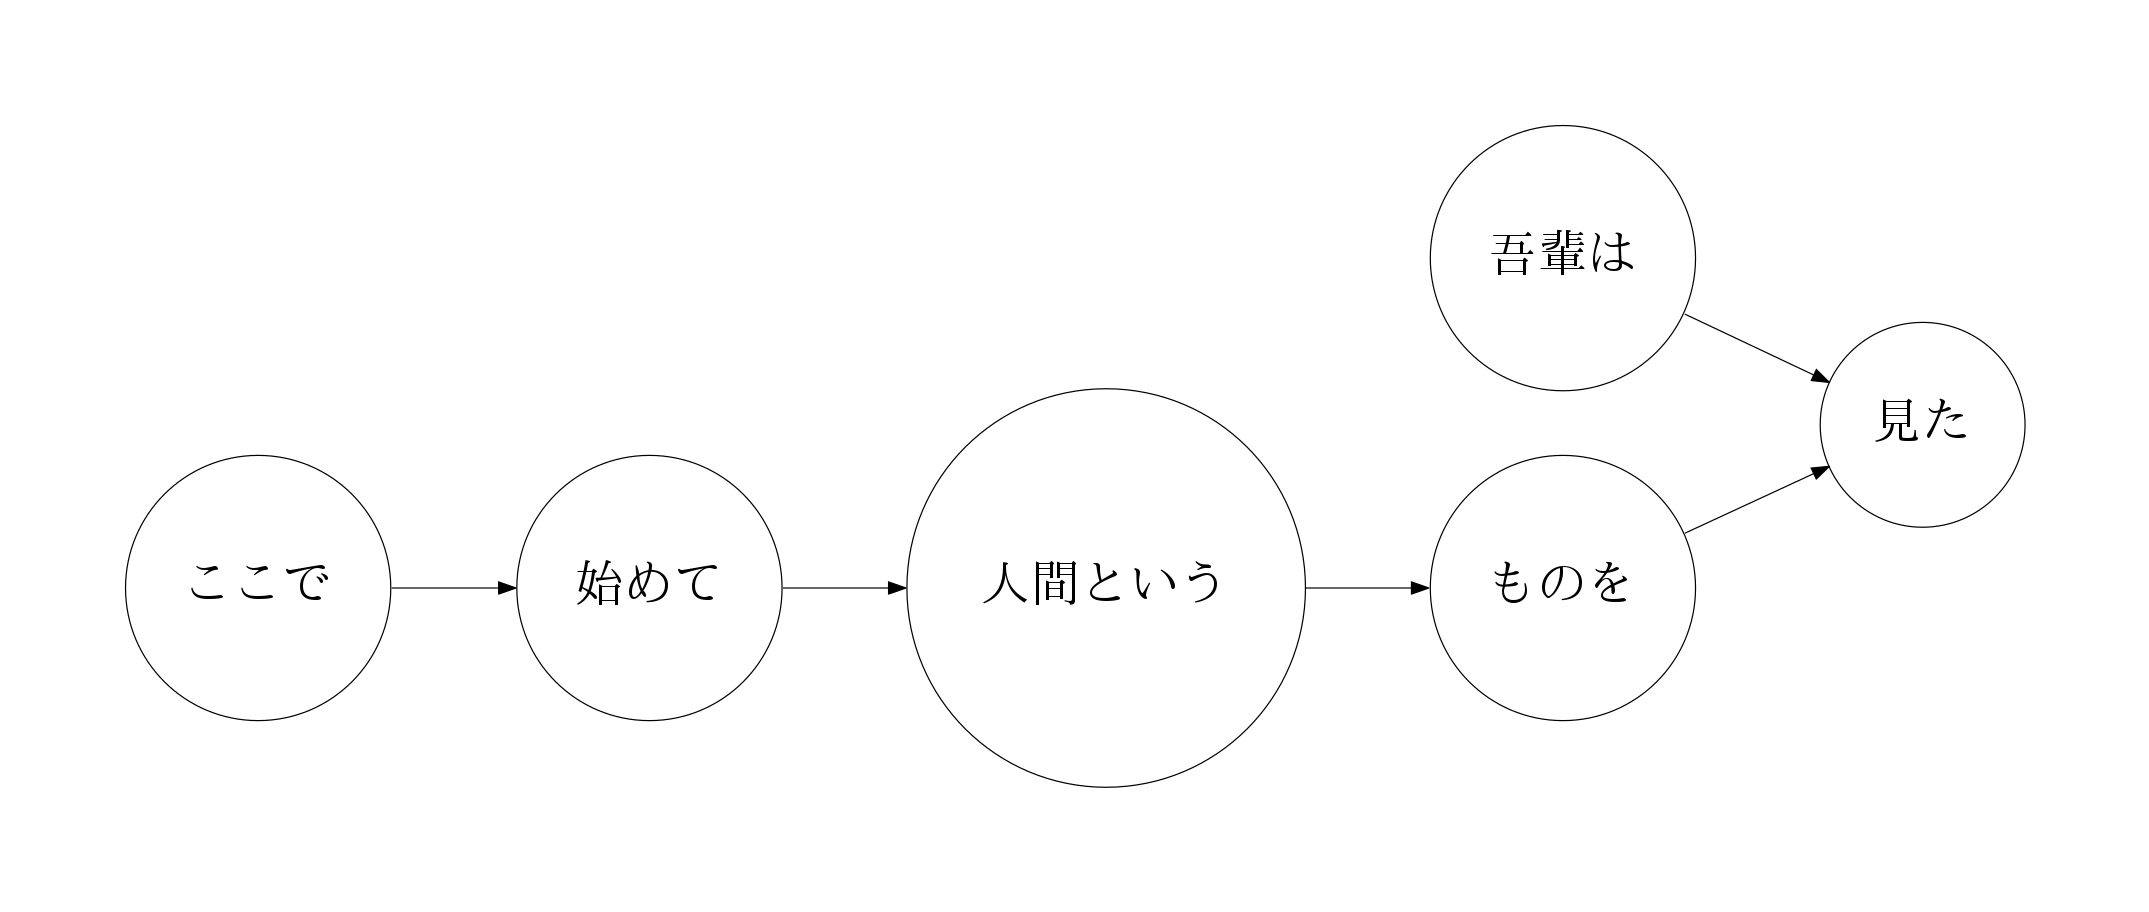

In [24]:
line = "吾輩はここで始めて人間というものを見た。"
graph = create_dependency_analysis_graph(line)
Image(graph.create_png(prog=[ "dot", "-Nname=IPAGothic"]))

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める  で
見る    は を
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [25]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

    def phrase(self):
        return "".join([_morph.surface for _morph in self.morphs if _morph.pos != "記号"])

    def include_pos(self, pos):
        return any([_morph.pos == pos for _morph in self.morphs])
    
    def get_morphs_by_pos(self, pos, pos1=None):
        if pos1 is None:
            return [_morph for _morph in self.morphs if _morph.pos == pos]
        else:
            return [_morph for _morph in self.morphs if (_morph.pos == pos) and (_morph.pos1 == pos1)]

In [26]:
def verb_case_patterns_in_line(_chunks):
    _verb_case_patterns = []
    
    for _chunk in _chunks:
        if not (_chunk.srcs and _chunk.include_pos("動詞")):
            continue

        prts = [
            _chunks[src].get_morphs_by_pos("助詞")[-1].base 
            for src in _chunk.srcs 
            if _chunks[src].include_pos("助詞") > 0
        ]
        
        if not prts:
            continue
        
        _verb_case_patterns.append("%s\t%s" % 
                                   (_chunk.get_morphs_by_pos("動詞")[0].base, " ".join(prts))
                                  )
    
    return _verb_case_patterns

In [27]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [28]:
with open("neko_verb_case_patterns.txt", mode="w") as f:
    for line_index in chunks:
        verb_case_patterns = verb_case_patterns_in_line(chunks[line_index])
        if not verb_case_patterns:
            continue

        f.write("%s\n" % "\n".join(verb_case_patterns))

In [29]:
! cat neko_verb_case_patterns.txt | sort | uniq -c | sort -r

    697 云う	と
    447 する	を
    327 思う	と
    201 ある	が
    193 なる	に
    188 する	に
    173 見る	て
    150 する	と
    119 する	が
     97 見る	を
     95 見える	と
     82 する	て を
     81 する	は
     66 する	を に
     58 もつ	を
     58 する	て
     58 する	が を
     55 云う	を
     54 ある	の
     52 する	から
     50 出来る	が
     50 行く	へ
     50 する	も
     50 する	に を
     50 ある	も
     46 聞く	を
     46 する	と を
     45 なる	が に
     44 ある	は が
     40 する	で を
     40 ある	に
     39 食う	を
     39 する	は を
     39 する	の
     39 ある	は
     37 いう	と
     36 至る	に
     35 知る	を
     35 する	で
     34 聞く	と
     33 来る	が
     33 する	から を
     32 やる	を
     32 ある	に が
     31 よる	に
     31 なる	と
     30 なる	は
     29 持つ	を
     27 出る	が
     27 出す	を
     26 云う	が と
     26 なる	て に
     24 云う	と が
     24 なる	が
     24 とる	を
     23 読む	を
     23 云う	は と
     23 云う	とか
     23 云う	から と
     23 いる	に
     22 行く	に
     22 云う	て と
     22 なる	は に
     22 する	は に
     22 する	と が
     22 する	が に
     21 見る	て て
     20 入る	に
     20 向う	に
     20 云う	に と
     20 つける	を
     20 する	て に
     19 分

      1 滅する	て
      1 鳴る	ほど
      1 鳴る	は で が と
      1 鳴る	として が で
      1 鳴る	として
      1 鳴る	と て
      1 鳴る	で が に
      1 鳴る	て
      1 鳴る	が と
      1 鳴らす	は に を
      1 鳴らす	と に
      1 鳴らす	て を に
      1 鳴らす	て を
      1 鳴らす	たり と は を
      1 鳴く	ば
      1 鳴く	は が
      1 鳴く	に と ばかり
      1 鳴く	に
      1 鳴く	と で が
      1 鳴く	で
      1 鳴く	て と
      1 鳴く	て で が
      1 鳴く	て て
      1 鳴く	て
      1 鳴く	が か と
      1 鳴く	から と ばかり
      1 迷わす	は に
      1 迷わす	に
      1 迷う	と は
      1 迷う	と
      1 迷う	でも が
      1 迷う	が に
      1 迷い込む	へ
      1 明け放つ	と を に
      1 明け放す	と が
      1 明け放す	と
      1 明く	を
      1 明く	も
      1 明く	の
      1 明く	が と
      1 命ずる	も を
      1 命ずる	へ を
      1 命ずる	は から
      1 命ずる	て に を
      1 命ずる	て と が に
      1 命ずる	が を
      1 命じる	を
      1 命じる	に か を
      1 命じる	と
      1 名乗る	を
      1 名乗る	と
      1 名乗る	が で と
      1 名づける	を と
      1 名づける	を が は
      1 名づける	を
      1 名づける	も と
      1 名づける	と
      1 無くなる	が
      1 務まる	も は
      1 務まる	て が
      1 眠れる	と
      1 眠れる	が は て
      1 眠る	を
    

      1 出る	が くらい が
      1 出る	が から
      1 出る	が か
      1 出る	から を
      1 出る	から へ
      1 出る	から て へ に
      1 出る	から て へ
      1 出る	から て て
      1 出る	から て が
      1 出る	から から
      1 出る	か へ
      1 出る	か は が
      1 出る	か が
      1 出せる	も が も
      1 出せる	で が
      1 出せる	が
      1 出せる	から に を
      1 出す	やいなや は を と
      1 出す	も を
      1 出す	も の に を
      1 出す	も
      1 出す	へ を
      1 出す	へ
      1 出す	ば を
      1 出す	は も
      1 出す	は に へ を
      1 出す	は に と を
      1 出す	は ながら が
      1 出す	は と を
      1 出す	は て と を
      1 出す	は て
      1 出す	は が
      1 出す	は から を に
      1 出す	は か て
      1 出す	ので に へ を
      1 出す	に対して
      1 出す	に を へ
      1 出す	に へ を
      1 出す	ながら を
      1 出す	ながら から を
      1 出す	ながら から に を
      1 出す	として
      1 出す	と も を
      1 出す	と は も
      1 出す	と は に を
      1 出す	と は ながら を
      1 出す	と は が を
      1 出す	と は
      1 出す	と の を へ
      1 出す	と て へ
      1 出す	と て に へ
      1 出す	と が を を
      1 出す	と が
      1 出す	と から を
      1 出す	で に を
      1 出す	で が を へ
      1 出す	で から を
      1 出す	て 

In [30]:
! cat neko_verb_case_patterns.txt | grep する | sort | uniq -c | sort -r

    447 する	を
    188 する	に
    150 する	と
    119 する	が
     82 する	て を
     81 する	は
     66 する	を に
     58 する	て
     58 する	が を
     52 する	から
     50 する	も
     50 する	に を
     46 する	と を
     40 する	で を
     39 する	は を
     39 する	の
     35 する	で
     33 する	から を
     22 する	は に
     22 する	と が
     22 する	が に
     20 する	て に
     19 する	と は を
     19 する	と は
     18 する	は と
     13 する	ば
     13 する	か
     12 する	も を
     12 する	て と
     12 する	から に
     11 する	まで
     11 する	に が
     10 する	は も
     10 する	に に
     10 する	と が を
      9 する	は て を
      9 する	は て
      9 する	と は に
      9 する	と に
      9 する	と で
      9 する	が と
      8 する	も に
      8 する	でも
      8 する	で に
      8 する	で が
      7 する	を と
      7 する	へ
      7 する	は が
      7 する	さえ
      7 する	が に を
      6 する	を が
      6 する	も が
      6 する	まで を
      6 する	ば を
      6 する	と も
      6 する	で に を
      6 する	て を に
      6 する	て て
      6 する	くらい
      6 する	が を に
      6 する	が で を
      5 称する	と
      5 する	をもって
      5 する	も を に
      5 する	へ を
      5 する	に を に
      5 する	なん

In [31]:
! cat neko_verb_case_patterns.txt | grep 見る | sort | uniq -c | sort -r

    173 見る	て
     97 見る	を
     21 見る	て て
     19 見る	から
     18 見る	と
     14 見る	て を
     13 見る	は て
     12 見る	で
     10 見る	から て
      9 見る	に
      8 見る	が を
      8 見る	が
      6 見る	も
      6 見る	は て を
      6 見る	と て
      5 見る	と を
      4 見る	を に
      4 見る	も て
      4 見る	は て て
      4 見る	に を
      4 見る	で を
      4 見る	が て
      4 見る	から て て
      3 見る	ば て
      3 見る	は を
      3 見る	は
      3 見る	ので て
      3 見る	たり て
      3 見る	から を
      3 見る	か て
      2 見る	を て
      2 見る	は で を
      2 見る	の
      2 見る	と は て
      2 見る	で が
      2 見る	か
      1 見る	を で
      1 見る	を から
      1 見る	より で を
      1 見る	より
      1 見る	も を
      1 見る	も によって
      1 見る	も と て
      1 見る	も で ばかり
      1 見る	も て て
      1 見る	も だけ
      1 見る	まで を
      1 見る	まで て
      1 見る	まで
      1 見る	へ と
      1 見る	ば て て
      1 見る	ば が て
      1 見る	は も
      1 見る	は は
      1 見る	は の を
      1 見る	は と に を が
      1 見る	は で で
      1 見る	は で て
      1 見る	は て に を
      1 見る	は て で を
      1 見る	は が も
      1 見る	は が て
      1 見る	は から て
      1 見る	は か

In [32]:
! cat neko_verb_case_patterns.txt | grep 与える | sort | uniq -c | sort -r

      4 与える	に を
      2 与える	て に を
      1 与える	も を
      1 与える	ば を
      1 与える	は は も
      1 与える	は て に を に
      1 与える	は て に を
      1 与える	として か
      1 与える	と は て を
      1 与える	で に を
      1 与える	て は に を
      1 与える	けれども は を
      1 与える	が を
      1 与える	が は は と て に を


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

```
始める  で      ここで
見る    は を   吾輩は ものを
```

In [33]:
def verb_case_patterns_in_line(_chunks):
    _verb_case_patterns = []
    
    for _chunk in _chunks:
        if not (_chunk.srcs and _chunk.include_pos("動詞")):
            continue
        
        prts, phrases = [], []
        for src in _chunk.srcs:
            if not _chunks[src].include_pos("助詞"):
                continue

            prts.append(_chunks[src].get_morphs_by_pos("助詞")[-1].base)
            phrases.append(_chunks[src].phrase())

        if not prts:
            continue
                
        _verb_case_patterns.append("%s\t%s\t%s" % (
            _chunk.get_morphs_by_pos("動詞")[0].base, 
            " ".join(prts),
            " ".join(phrases),
        ))
    
    return _verb_case_patterns

In [34]:
with open("neko_verb_case_patterns.txt", mode="w") as f:
    for line_index in chunks:
        verb_case_patterns = verb_case_patterns_in_line(chunks[line_index])
        if not verb_case_patterns:
            continue
        f.write("%s\n" % "\n".join(verb_case_patterns))

## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

```
返事をする      と に は        及ばんさと 手紙に 主人は
```

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [35]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

    def phrase(self):
        return "".join([_morph.surface for _morph in self.morphs if _morph.pos != "記号"])

    def include_pos(self, pos):
        return any([_morph.pos == pos for _morph in self.morphs])
    
    def get_morphs_by_pos(self, pos, pos1=None):
        if pos1 is None:
            return [_morph for _morph in self.morphs if _morph.pos == pos]
        else:
            return [_morph for _morph in self.morphs if (_morph.pos == pos) and (_morph.pos1 == pos1)]
    
    def get_sahen_wo(self):
        for idx, _morph in enumerate(self.morphs[:-1]):
            if _morph.pos == "名詞" \
            and _morph.pos1 == "サ変接続" \
            and (self.morphs[idx + 1].pos == "助詞") \
            and (self.morphs[idx + 1].surface == "を"):
                return _morph.surface + self.morphs[idx + 1].surface

        return None

In [36]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [37]:
def verb_case_patterns_in_chunks(_chunks):
    _verb_case_patterns = []
    
    for _chunk in _chunks:
        if not (_chunk.srcs and _chunk.include_pos("動詞")):
            continue

        sahen_wo_idx = None
        prts, phrases = [], []
        for src in _chunk.srcs:
            if _chunks[src].get_sahen_wo() is not None:
                sahen_wo_idx = src
            elif _chunks[src].include_pos("助詞"):
                prts.append(_chunks[src].get_morphs_by_pos("助詞")[-1].base)
                phrases.append(_chunks[src].phrase())

        if sahen_wo_idx is None or not prts:
            continue

        _verb_case_patterns.append("%s\t%s\t%s" % (
            _chunks[sahen_wo_idx].get_sahen_wo() + _chunk.get_morphs_by_pos("動詞")[0].base, 
            " ".join(prts),
            " ".join(phrases),
        ))

    return _verb_case_patterns

In [38]:
with open("neko_verb_case_patterns.txt", mode="w") as f:
    for line_index in chunks:
        verb_case_patterns = verb_case_patterns_in_chunks(chunks[line_index])
        if not verb_case_patterns:
            continue
        f.write("%s\n" % "\n".join(verb_case_patterns))

In [39]:
! cat neko_verb_case_patterns.txt | sort | awk '{ print $1}' | uniq -c | sort -r

     27 返事をする
     19 挨拶をする
     12 話をする
      8 質問をする
      7 喧嘩をする
      6 真似をする
      5 注意をする
      5 昼寝をする
      5 相談をする
      5 質問をかける
      4 辞儀をする
      4 降参をする
      4 欠伸をする
      4 休養を要する
      4 演説をする
      3 落着を告げる
      3 問答をする
      3 病気をする
      3 批評を願う
      3 同情を表する
      3 談話を聞く
      3 談話をする
      3 講釈をする
      3 決心をする
      3 活躍を試みる
      3 安心を得る
      2 話を聞く
      2 話をつづける
      2 約束をする
      2 放蕩をする
      2 迫害を加える
      2 同情を表す
      2 著述をする
      2 宙返りをする
      2 談判を聞く
      2 体操をする
      2 掃除をする
      2 撰をする
      2 出所をする
      2 修行をする
      2 自炊をする
      2 自殺をする
      2 思案を定める
      2 刺激を与える
      2 散歩をする
      2 座禅をする
      2 講義をする
      2 行水を使う
      2 抗議を申し込む
      2 結婚を申し込む
      2 結婚をする
      2 経験をする
      2 苦心をする
      2 逆上をする
      2 議論をする
      2 観察を怠る
      2 覚悟をする
      2 化粧をする
      2 往来をあるく
      2 噂をする
      2 一段落を告げる
      2 いたずらをする
      1 薨去を落ちる
      1 吶喊を喰う
      1 話を致す
      1 話を切らす
      1 話を進める
      1 話を伺う
      1 話を仕る
      1 話をなさる
      1

In [40]:
! cat neko_verb_case_patterns.txt | cut --field=1,2 | sort | uniq -c | sort -r

      7 返事をする	と
      4 挨拶をする	と
      4 挨拶をする	から
      3 返事をする	は と
      3 質問をかける	と は
      3 喧嘩をする	と
      2 同情を表する	と は て
      2 休養を要する	は
      2 議論をする	て
      2 覚悟をする	と
      2 安心を得る	が
      2 挨拶をする	と も
      1 薨去を落ちる	て
      1 吶喊を喰う	と
      1 話を聞く	まで として に
      1 話を聞く	は
      1 話を致す	が
      1 話を切らす	て
      1 話を進める	と は で
      1 話を伺う	て
      1 話を仕る	も
      1 話をなさる	が
      1 話をつづける	も は
      1 話をつづける	は
      1 話をする	は か
      1 話をする	は
      1 話をする	に
      1 話をする	ながら
      1 話をする	と て
      1 話をする	と
      1 話をする	て か
      1 話をする	て
      1 話をする	って でも も
      1 話をする	たり は て
      1 話をする	から に に
      1 話をする	から
      1 臨席を願う	から も
      1 了見を抱く	と
      1 了見を起す	ながら と
      1 旅行をする	て
      1 立見をする	は ながら
      1 履行を取り合う	て て
      1 乱暴を働く	て
      1 乱暴をかく	から て
      1 落着を告げる	は と
      1 落着を告げる	は で
      1 落着を告げる	さえ
      1 要求をする	と
      1 容赦を願う	が は
      1 遊弋をする	から て で
      1 遊戯をくだける	に
      1 由来を案ずる	て
      1 猶予を与える	に
      1 約束をする	に
      1 約束をする	て
      1 問答をやる	で
      1 問答をする	は
      1 問答をする

## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を"->"で連結する

「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
```

In [41]:
def paths_to_root_in_chunks(_chunks):
    _paths_to_root = []
    
    for _chunk in _chunks:
        if _chunk.dat == -1 or \
        not _chunk.include_pos("名詞"):
            continue
        
        _path_to_root = _chunk.phrase()
        _current_chunk = _chunk
        while _current_chunk.dat != -1:
            _current_chunk = _chunks[_current_chunk.dat]
            _path_to_root += " -> " + _current_chunk.phrase()
        
        _paths_to_root.append(_path_to_root)
    
    return _paths_to_root

In [42]:
print("\n".join(paths_to_root_in_chunks(chunks["8"])))

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"->"で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を"|"で連結して表示

例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

```
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
```

In [43]:
class Chunk:
    def __init__(self, dat, srcs):
        self.morphs = []
        self.dat = dat
        self.srcs = srcs

    def __str__(self):
        return "morphs: %s\tdat: %s\tsrcs: %s" % ("".join([_morph.surface for _morph in self.morphs]), self.dat, self.srcs)

    def phrase(self):
        return "".join([_morph.surface for _morph in self.morphs if _morph.pos != "記号"])

    def include_pos(self, pos):
        return any([_morph.pos == pos for _morph in self.morphs])
    
    def get_morphs_by_pos(self, pos, pos1=None):
        if pos1 is None:
            return [_morph for _morph in self.morphs if _morph.pos == pos]
        else:
            return [_morph for _morph in self.morphs if (_morph.pos == pos) and (_morph.pos1 == pos1)]

    def noun_masked_phrase(self, mask):
        return "".join([_morph.surface if _morph.pos != "名詞" else mask for _morph in self.morphs if _morph.pos != "記号"])

In [44]:
def get_idx_path_to_dat(_current_chunk_idx, _chunks, dat=-1):
        _current_chunk = _chunks[_current_chunk_idx]
        _chunk_idx_path = [_current_chunk_idx]
        
        while _current_chunk.dat != dat:
            _chunk_idx_path.append(_current_chunk.dat)
            _current_chunk = _chunks[_current_chunk.dat]

        return _chunk_idx_path

In [45]:
from itertools import combinations

In [46]:
def paths_between_nouns_in_line(_chunks):
    _chunk_idxs_include_noun = [idx for idx, _chunk in enumerate(_chunks) if _chunk.include_pos("名詞")]
    _paths_between_nouns = []
    
    if len(_chunk_idxs_include_noun) < 2:
        return _paths_between_nouns
    
    for x_chunk_idx, y_chunk_idx in combinations(_chunk_idxs_include_noun, 2):
        _path_between_nouns = ""

        x_chunk_idx_path = get_idx_path_to_dat(x_chunk_idx, _chunks)
        y_chunk_idx_path = get_idx_path_to_dat(y_chunk_idx, _chunks)
        
        if y_chunk_idx in x_chunk_idx_path:
            _path_between_nouns += " -> ".join([_chunks[idx].noun_masked_phrase("X") if idx == x_chunk_idx else "Y" if idx == y_chunk_idx else _chunks[idx].phrase() for idx in x_chunk_idx_path[:x_chunk_idx_path.index(y_chunk_idx) + 1]])

        elif set(x_chunk_idx_path) & set(y_chunk_idx_path):
            merge_idx = list(set(x_chunk_idx_path) & set(y_chunk_idx_path))[0]
            
            _path_between_nouns += " -> ".join([_chunks[idx].noun_masked_phrase("X") if idx == x_chunk_idx else _chunks[idx].phrase() for idx in x_chunk_idx_path[:x_chunk_idx_path.index(merge_idx)]])
            _path_between_nouns += " | "
            _path_between_nouns += " -> ".join([_chunks[idx].noun_masked_phrase("Y") if idx == y_chunk_idx else _chunks[idx].phrase() for idx in y_chunk_idx_path[:y_chunk_idx_path.index(merge_idx)]])
            _path_between_nouns += " | "
            _path_between_nouns += _chunks[merge_idx].phrase()

        else:
            continue
        
        _paths_between_nouns.append(_path_between_nouns)
    return _paths_between_nouns

In [47]:
with open("neko.txt", mode="r") as f:
    texts = f.readlines()
chunks = chunks_in_texts(texts)

In [48]:
print("\n".join(paths_between_nouns_in_line(chunks["8"])))

Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
